# AI-Driven Alert Prioritisation & Fatigue Reduction Framework for SOCs

## Project Overview

This notebook implements a unified system that combines:
- Automated alert filtering (XGBoost)
- Temporal pattern recognition (LSTM)
- Alert clustering for incident grouping (DBSCAN)
- Human learning integration
- Threat escalation prediction

**Datasets**: UNSW-NB15 and CICIDS2017


## Step 1: Import Required Libraries


In [2]:
import pandas as pd
import numpy as np
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import xgboost as xgb
from xgboost import plot_importance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import shap

import joblib
from datetime import datetime
import time

print("LIBRARY IMPORT COMPLETE")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

LIBRARY IMPORT COMPLETE
Pandas version: 2.2.2
NumPy version: 2.0.2
TensorFlow version: 2.19.0
XGBoost version: 3.1.2


## Step 2: Extract Datasets from ZIP Files


In [3]:
print("EXTRACTING DATASETS")

extract_dir = "extracted_data"
os.makedirs(extract_dir, exist_ok=True)

print("\n[1/2] Extracting UNSW-NB15 dataset (archive 1)...")
start_time = time.time()
with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
    file_list = zip_ref.namelist()
    print(f"Found {len(file_list)} files in archive")
    zip_ref.extractall(os.path.join(extract_dir, "UNSW_NB15"))
    print(f"Extracted to: {os.path.join(extract_dir, 'UNSW_NB15')}")
print(f"Extraction time: {time.time() - start_time:.2f} seconds")

print("\n[2/2] Extracting CICIDS2017 dataset (archive 2)...")
start_time = time.time()
with zipfile.ZipFile('archive (2).zip', 'r') as zip_ref:
    file_list = zip_ref.namelist()
    print(f"Found {len(file_list)} files in archive")
    zip_ref.extractall(os.path.join(extract_dir, "CICIDS2017"))
    print(f"Extracted to: {os.path.join(extract_dir, 'CICIDS2017')}")
print(f"Extraction time: {time.time() - start_time:.2f} seconds")

print("EXTRACTION COMPLETE")

EXTRACTING DATASETS

[1/2] Extracting UNSW-NB15 dataset (archive 1)...
Found 8 files in archive
Extracted to: extracted_data/UNSW_NB15
Extraction time: 8.32 seconds

[2/2] Extracting CICIDS2017 dataset (archive 2)...
Found 8 files in archive
Extracted to: extracted_data/CICIDS2017
Extraction time: 9.61 seconds
EXTRACTION COMPLETE


## Step 3: Load UNSW-NB15 Dataset


In [4]:
import glob  # Added for dynamic file loading

print("LOADING UNSW-NB15 DATASET")

unsw_path = os.path.join(extract_dir, "UNSW_NB15")

csv_files = glob.glob(os.path.join(unsw_path, '*.csv'))
print(f"\nFound {len(csv_files)} CSV files dynamically using glob:")
for f in csv_files:
    print(f"  - {os.path.basename(f)}")

# Dynamic loading: find training and testing sets by pattern matching
print("\nLoading main training and testing sets dynamically...")
train_files = glob.glob(os.path.join(unsw_path, '*training*.csv')) + glob.glob(os.path.join(unsw_path, '*train*.csv'))
test_files = glob.glob(os.path.join(unsw_path, '*testing*.csv')) + glob.glob(os.path.join(unsw_path, '*test*.csv'))

if train_files and test_files:
    df_unsw_train = pd.read_csv(train_files[0])
    df_unsw_test = pd.read_csv(test_files[0])
    print(f"  Loaded training file: {os.path.basename(train_files[0])}")
    print(f"  Loaded testing file: {os.path.basename(test_files[0])}")
else:
    # Fallback: try original filenames
    print("  Warning: Using fallback hardcoded filenames")
    df_unsw_train = pd.read_csv(os.path.join(unsw_path, 'UNSW_NB15_training-set.csv'))
    df_unsw_test = pd.read_csv(os.path.join(unsw_path, 'UNSW_NB15_testing-set.csv'))

print(f"\nTraining set shape: {df_unsw_train.shape}")
print(f"Testing set shape: {df_unsw_test.shape}")

print("\nCombining training and testing sets...")
df_unsw = pd.concat([df_unsw_train, df_unsw_test], ignore_index=True)
print(f"Combined dataset shape: {df_unsw.shape}")

print("\nDataset Info:")
print(f"Memory usage: {df_unsw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns ({len(df_unsw.columns)}):")
print(df_unsw.columns.tolist())

print("\nFirst few rows:")
print(df_unsw.head())

print("\nData types:")
print(df_unsw.dtypes.value_counts())

print("\nMissing values:")
missing = df_unsw.isnull().sum()
print(missing[missing > 0])

print("UNSW-NB15 DATASET LOADED SUCCESSFULLY")

LOADING UNSW-NB15 DATASET

Found 8 CSV files dynamically using glob:
  - NUSW-NB15_features.csv
  - UNSW-NB15_LIST_EVENTS.csv
  - UNSW-NB15_2.csv
  - UNSW_NB15_training-set.csv
  - UNSW-NB15_1.csv
  - UNSW_NB15_testing-set.csv
  - UNSW-NB15_4.csv
  - UNSW-NB15_3.csv

Loading main training and testing sets dynamically...
  Loaded training file: UNSW_NB15_training-set.csv
  Loaded testing file: UNSW_NB15_testing-set.csv

Training set shape: (82332, 45)
Testing set shape: (175341, 45)

Combining training and testing sets...
Combined dataset shape: (257673, 45)

Dataset Info:
Memory usage: 132.53 MB

Columns (45):
['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct

## Step 4: Load CICIDS2017 Dataset


In [5]:
print("LOADING CICIDS2017 DATASET")

cicids_path = os.path.join(extract_dir, "CICIDS2017")
csv_files = [f for f in os.listdir(cicids_path) if f.endswith('.csv')]
print(f"\nFound {len(csv_files)} CSV files:")
for f in csv_files:
    print(f"  - {f}")

print("\nLoading all CSV files and combining...")
df_cicids_list = []
for i, csv_file in enumerate(csv_files, 1):
    print(f"[{i}/{len(csv_files)}] Loading {csv_file}...")
    try:
        df_temp = pd.read_csv(os.path.join(cicids_path, csv_file))
        print(f"  Shape: {df_temp.shape}")
        df_cicids_list.append(df_temp)
    except Exception as e:
        print(f"  Error loading {csv_file}: {e}")

print("\nCombining all files...")
df_cicids = pd.concat(df_cicids_list, ignore_index=True)
print(f"Combined dataset shape: {df_cicids.shape}")

print("\nDataset Info:")
print(f"Memory usage: {df_cicids.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns ({len(df_cicids.columns)}):")
print(df_cicids.columns.tolist())

print("\nFirst few rows:")
print(df_cicids.head())

print("\nData types:")
print(df_cicids.dtypes.value_counts())

print("\nMissing values:")
missing = df_cicids.isnull().sum()
print(missing[missing > 0])

print("CICIDS2017 DATASET LOADED SUCCESSFULLY")

LOADING CICIDS2017 DATASET

Found 8 CSV files:
  - Tuesday-WorkingHours.pcap_ISCX.csv
  - Monday-WorkingHours.pcap_ISCX.csv
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  - Friday-WorkingHours-Morning.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  - Wednesday-workingHours.pcap_ISCX.csv
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

Loading all CSV files and combining...
[1/8] Loading Tuesday-WorkingHours.pcap_ISCX.csv...
  Shape: (445909, 79)
[2/8] Loading Monday-WorkingHours.pcap_ISCX.csv...
  Shape: (529918, 79)
[3/8] Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
  Shape: (170366, 79)
[4/8] Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
  Shape: (191033, 79)
[5/8] Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
  Shape: (286467, 79)
[6/8] Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
  Shape: (288602, 79)
[7/

## Step 5: Exploratory Data Analysis (EDA)

### Visualization 1: Attack Type Distribution - UNSW-NB15


VISUALIZATION 1: UNSW-NB15 Attack Type Distribution

Attack categories found: 10
attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64


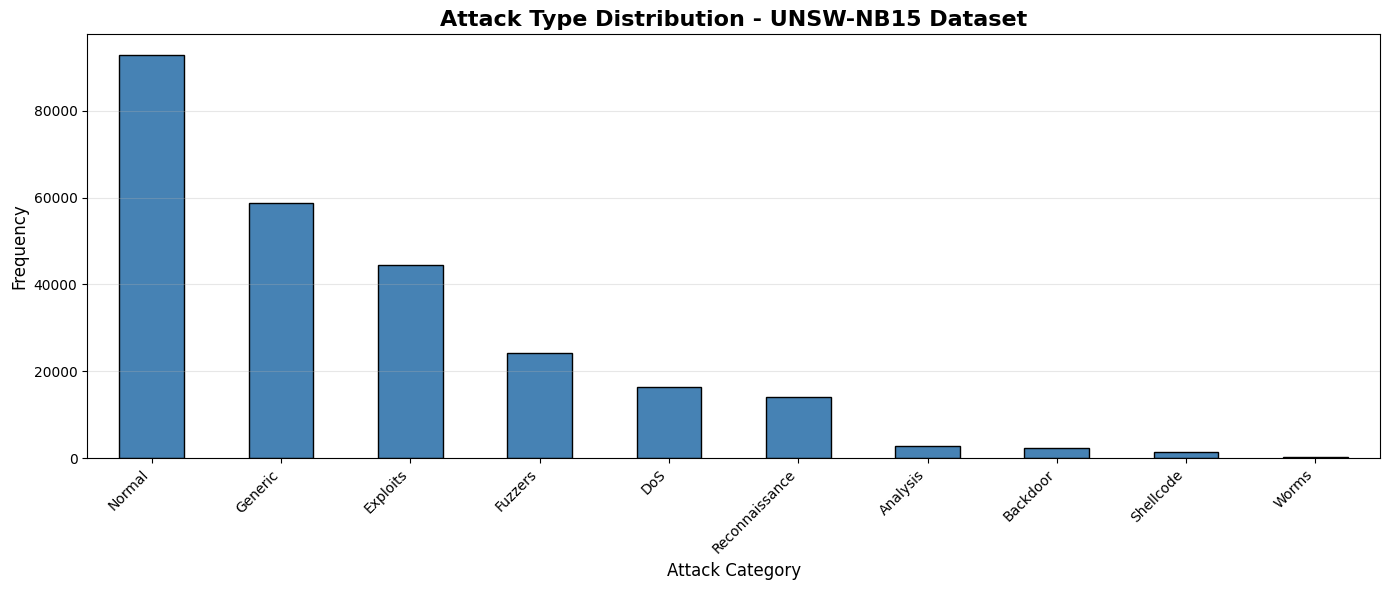


Total records: 257673
Normal traffic: 93000
Attack traffic: 164673


In [6]:
print("VISUALIZATION 1: UNSW-NB15 Attack Type Distribution")

if 'attack_cat' in df_unsw.columns:
    attack_counts = df_unsw['attack_cat'].value_counts()
    print(f"\nAttack categories found: {len(attack_counts)}")
    print(attack_counts)

    plt.figure(figsize=(14, 6))
    attack_counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title('Attack Type Distribution - UNSW-NB15 Dataset', fontsize=16, fontweight='bold')
    plt.xlabel('Attack Category', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nTotal records: {len(df_unsw)}")
    print(f"Normal traffic: {attack_counts.get('Normal', 0)}")
    print(f"Attack traffic: {len(df_unsw) - attack_counts.get('Normal', 0)}")
else:
    print("Column 'attack_cat' not found. Available columns:")
    print(df_unsw.columns.tolist())

### Visualization 2: Normal vs Attack Traffic Proportions


VISUALIZATION 2: Normal vs Attack Traffic Proportions

UNSW-NB15:
  Normal: 93000 (36.09%)
  Attack: 164673 (63.91%)


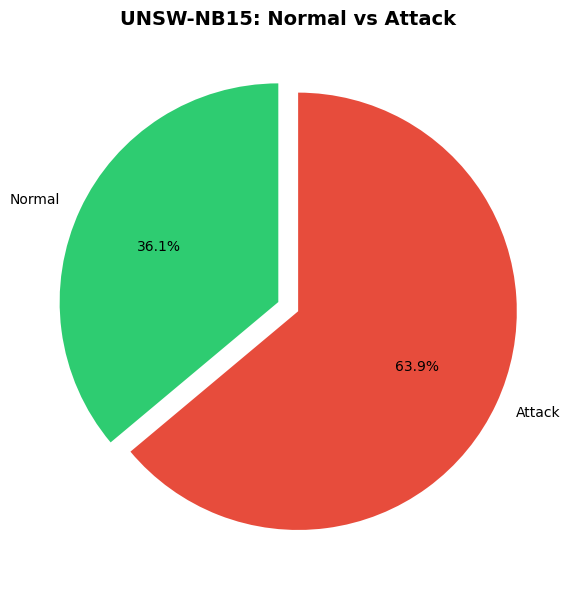

In [7]:
print("VISUALIZATION 2: Normal vs Attack Traffic Proportions")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

unsw_label_col = 'label' if 'label' in df_unsw.columns else ('attack_cat' if 'attack_cat' in df_unsw.columns else None)
if unsw_label_col:
    if unsw_label_col == 'label':
        unsw_normal = (df_unsw['label'] == 0).sum()
        unsw_attack = (df_unsw['label'] == 1).sum()
        unsw_labels = ['Normal', 'Attack']
    else:
        unsw_normal = (df_unsw['attack_cat'] == 'Normal').sum()
        unsw_attack = len(df_unsw) - unsw_normal
        unsw_labels = ['Normal', 'Attack']

    ax.pie(
        [unsw_normal, unsw_attack],
        labels=unsw_labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#2ecc71', '#e74c3c'],
        explode=(0.05, 0.05)
    )
    ax.set_title('UNSW-NB15: Normal vs Attack', fontsize=14, fontweight='bold')

    print(f"\nUNSW-NB15:")
    print(f"  Normal: {unsw_normal} ({unsw_normal/len(df_unsw)*100:.2f}%)")
    print(f"  Attack: {unsw_attack} ({unsw_attack/len(df_unsw)*100:.2f}%)")

plt.tight_layout()
plt.show()

### Visualization 1B: Attack Type Distribution - CICIDS2017

In [8]:

print("VISUALIZATION 1B: CICIDS2017 Attack Type Distribution")

if 'Label' in df_cicids.columns:
    attack_counts = df_cicids['Label'].value_counts()
    print("Attack categories found:", len(attack_counts))
    print(attack_counts)

    plt.figure(figsize=(14, 6))
    attack_counts.plot(kind='bar', color='orange', edgecolor='black')
    plt.title('Attack Type Distribution - CICIDS2017 Dataset', fontsize=16, fontweight='bold')
    plt.xlabel('Attack Category', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Summary counts
    if 'BENIGN' in attack_counts.index:
        normal_label = 'BENIGN'
    elif 'Normal' in attack_counts.index:
        normal_label = 'Normal'
    else:
        normal_label = attack_counts.index[0]
    print("Total records:", len(df_cicids))
    print("Normal traffic:", attack_counts.get(normal_label, 0))
    print("Attack traffic:", len(df_cicids) - attack_counts.get(normal_label, 0))
else:
    print("Column 'Label' not found. Available columns:")
    print(df_cicids.columns.tolist())


VISUALIZATION 1B: CICIDS2017 Attack Type Distribution
Column 'Label' not found. Available columns:
[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN F

### Class Imbalance Analysis

CLASS IMBALANCE ANALYSIS
UNSW-NB15 dataset class distribution:
  Normal: 93000 (36.09% )
  Attack: 164673 (63.91% )


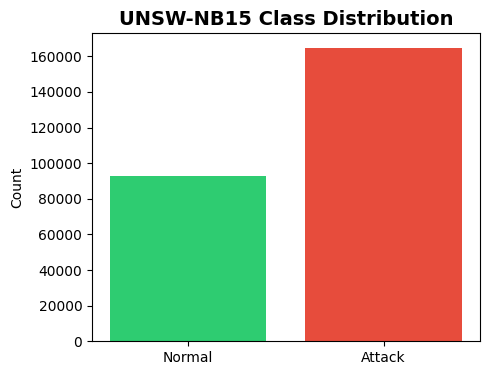

In [9]:

print('CLASS IMBALANCE ANALYSIS')

# UNSW dataset class distribution
if 'label' in df_unsw.columns or 'attack_cat' in df_unsw.columns:
    if 'label' in df_unsw.columns:
        unsw_normal_count = (df_unsw['label'] == 0).sum()
        unsw_attack_count = (df_unsw['label'] == 1).sum()
    else:
        unsw_normal_count = (df_unsw['attack_cat'] == 'Normal').sum()
        unsw_attack_count = len(df_unsw) - unsw_normal_count
    unsw_total = len(df_unsw)
    unsw_attack_rate = unsw_attack_count / unsw_total * 100
    unsw_normal_rate = unsw_normal_count / unsw_total * 100
    print("UNSW-NB15 dataset class distribution:")
    print("  Normal:", unsw_normal_count, "({:.2f}% )".format(unsw_normal_rate))
    print("  Attack:", unsw_attack_count, "({:.2f}% )".format(unsw_attack_rate))
    plt.figure(figsize=(5, 4))
    plt.bar(['Normal','Attack'], [unsw_normal_count, unsw_attack_count], color=['#2ecc71','#e74c3c'])
    plt.title('UNSW-NB15 Class Distribution', fontsize=14, fontweight='bold')
    plt.ylabel('Count')
    plt.show()

# CICIDS dataset class distribution
if 'Label' in df_cicids.columns or 'label' in df_cicids.columns:
    label_col = 'Label' if 'Label' in df_cicids.columns else 'label'
    counts = df_cicids[label_col].value_counts()
    if 'BENIGN' in counts.index:
        normal_label = 'BENIGN'
    elif 'Normal' in counts.index:
        normal_label = 'Normal'
    else:
        normal_label = counts.index[0]
    cicids_normal_count = counts.get(normal_label, 0)
    cicids_attack_count = len(df_cicids) - cicids_normal_count
    cicids_total = len(df_cicids)
    cicids_attack_rate = cicids_attack_count / cicids_total * 100
    cicids_normal_rate = cicids_normal_count / cicids_total * 100
    print("CICIDS2017 dataset class distribution:")
    print("  Normal:", cicids_normal_count, "({:.2f}% )".format(cicids_normal_rate))
    print("  Attack:", cicids_attack_count, "({:.2f}% )".format(cicids_attack_rate))
    plt.figure(figsize=(5, 4))
    plt.bar(['Normal','Attack'], [cicids_normal_count, cicids_attack_count], color=['#2ecc71','#e74c3c'])
    plt.title('CICIDS2017 Class Distribution', fontsize=14, fontweight='bold')
    plt.ylabel('Count')
    plt.show()


### Feature Statistics Box Plots - CICIDS2017

In [10]:

print('FEATURE STATISTICS BOX PLOTS: CICIDS2017')

numeric_cols = df_cicids.select_dtypes(include=[np.number]).columns.tolist()
# Remove label columns if present
if 'Label' in df_cicids.columns and 'Label' in numeric_cols:
    numeric_cols.remove('Label')
if 'label' in df_cicids.columns and 'label' in numeric_cols:
    numeric_cols.remove('label')

if len(numeric_cols) > 0:
    variances = df_cicids[numeric_cols].var().sort_values(ascending=False)
    top_features = variances.head(4).index.tolist()
    print('Top features by variance:', top_features)

    df_sample = df_cicids.sample(min(10000, len(df_cicids)), random_state=42).copy()
    # Determine label column and normal label for binary class
    if 'Label' in df_cicids.columns:
        label_col = 'Label'
    elif 'label' in df_cicids.columns:
        label_col = 'label'
    else:
        label_col = None
    if label_col is not None:
        unique_vals = df_sample[label_col].unique()
        if 'BENIGN' in unique_vals:
            normal_label = 'BENIGN'
        elif 'Normal' in unique_vals:
            normal_label = 'Normal'
        else:
            normal_label = unique_vals[0]
        df_sample['is_attack'] = (df_sample[label_col] != normal_label).astype(int)

        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        for i, feature in enumerate(top_features):
            ax = axes[i//2, i%2]
            sns.boxplot(x='is_attack', y=feature, data=df_sample, ax=ax, palette=['#2ecc71','#e74c3c'])
            ax.set_title(f'{feature} Distribution by Class', fontsize=12, fontweight='bold')
            ax.set_xlabel('Class (0=Normal, 1=Attack)')
            ax.set_ylabel(feature)
            ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


FEATURE STATISTICS BOX PLOTS: CICIDS2017
Top features by variance: [' Flow Duration', 'Fwd IAT Total', 'Bwd IAT Total', ' Fwd IAT Max']


### Visualization 3: Temporal Attack Patterns


VISUALIZATION 3: Temporal Attack Patterns

UNSW-NB15 temporal analysis complete (sample size: 50000)


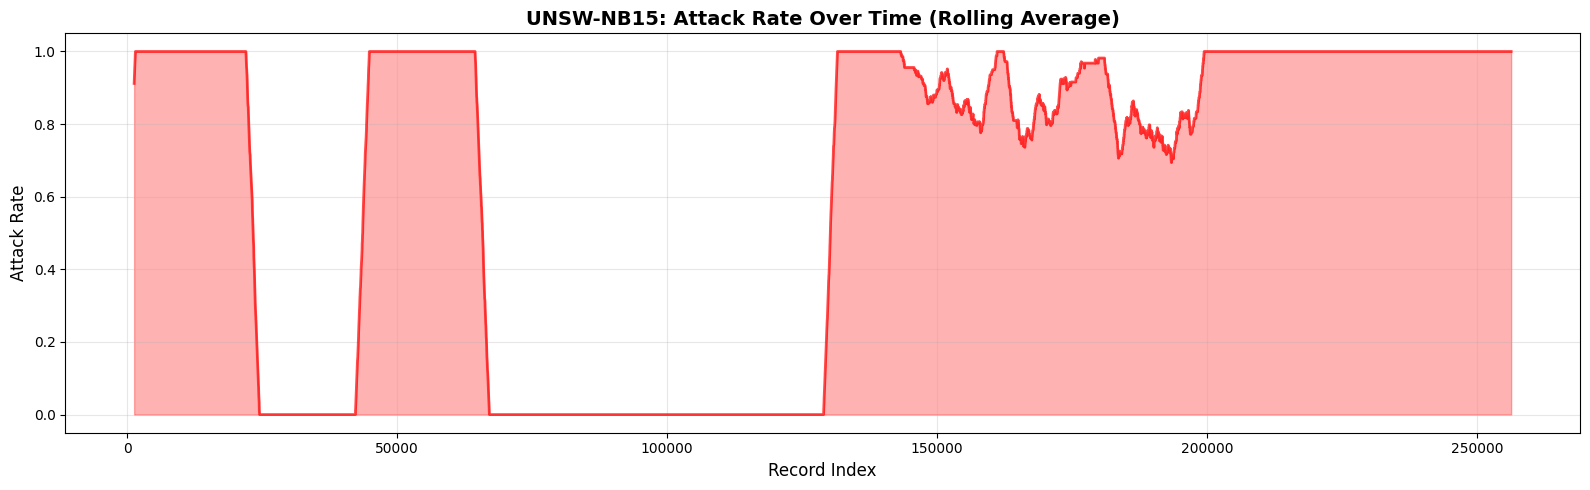

In [11]:
print("VISUALIZATION 3: Temporal Attack Patterns")

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

unsw_label_col = 'label' if 'label' in df_unsw.columns else ('attack_cat' if 'attack_cat' in df_unsw.columns else None)
if unsw_label_col:
    df_unsw_sample = df_unsw.sample(min(50000, len(df_unsw)), random_state=42)
    if unsw_label_col == 'label':
        df_unsw_sample['is_attack'] = df_unsw_sample['label']
    else:
        df_unsw_sample['is_attack'] = (df_unsw_sample['attack_cat'] != 'Normal').astype(int)

    df_unsw_sample = df_unsw_sample.sort_index()
    window_size = max(100, len(df_unsw_sample) // 100)
    rolling_attack_rate = df_unsw_sample['is_attack'].rolling(window=window_size, center=True).mean()

    ax.plot(
        rolling_attack_rate.index,
        rolling_attack_rate.values,
        linewidth=2,
        color='red',
        alpha=0.7
    )
    ax.fill_between(
        rolling_attack_rate.index,
        rolling_attack_rate.values,
        alpha=0.3,
        color='red'
    )
    ax.set_title('UNSW-NB15: Attack Rate Over Time (Rolling Average)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Record Index', fontsize=12)
    ax.set_ylabel('Attack Rate', fontsize=12)
    ax.grid(True, alpha=0.3)

    print(f"\nUNSW-NB15 temporal analysis complete (sample size: {len(df_unsw_sample)})")

plt.tight_layout()
plt.show()

### Visualization 4: Feature Correlation Heatmaps


VISUALIZATION 4: Feature Correlation Heatmaps

UNSW-NB15: Using top 20 numeric features for correlation analysis

UNSW-NB15 correlation matrix computed (20 features)
CICIDS2017: Using top 20 numeric features for correlation analysis
CICIDS2017 correlation matrix computed (20 features)


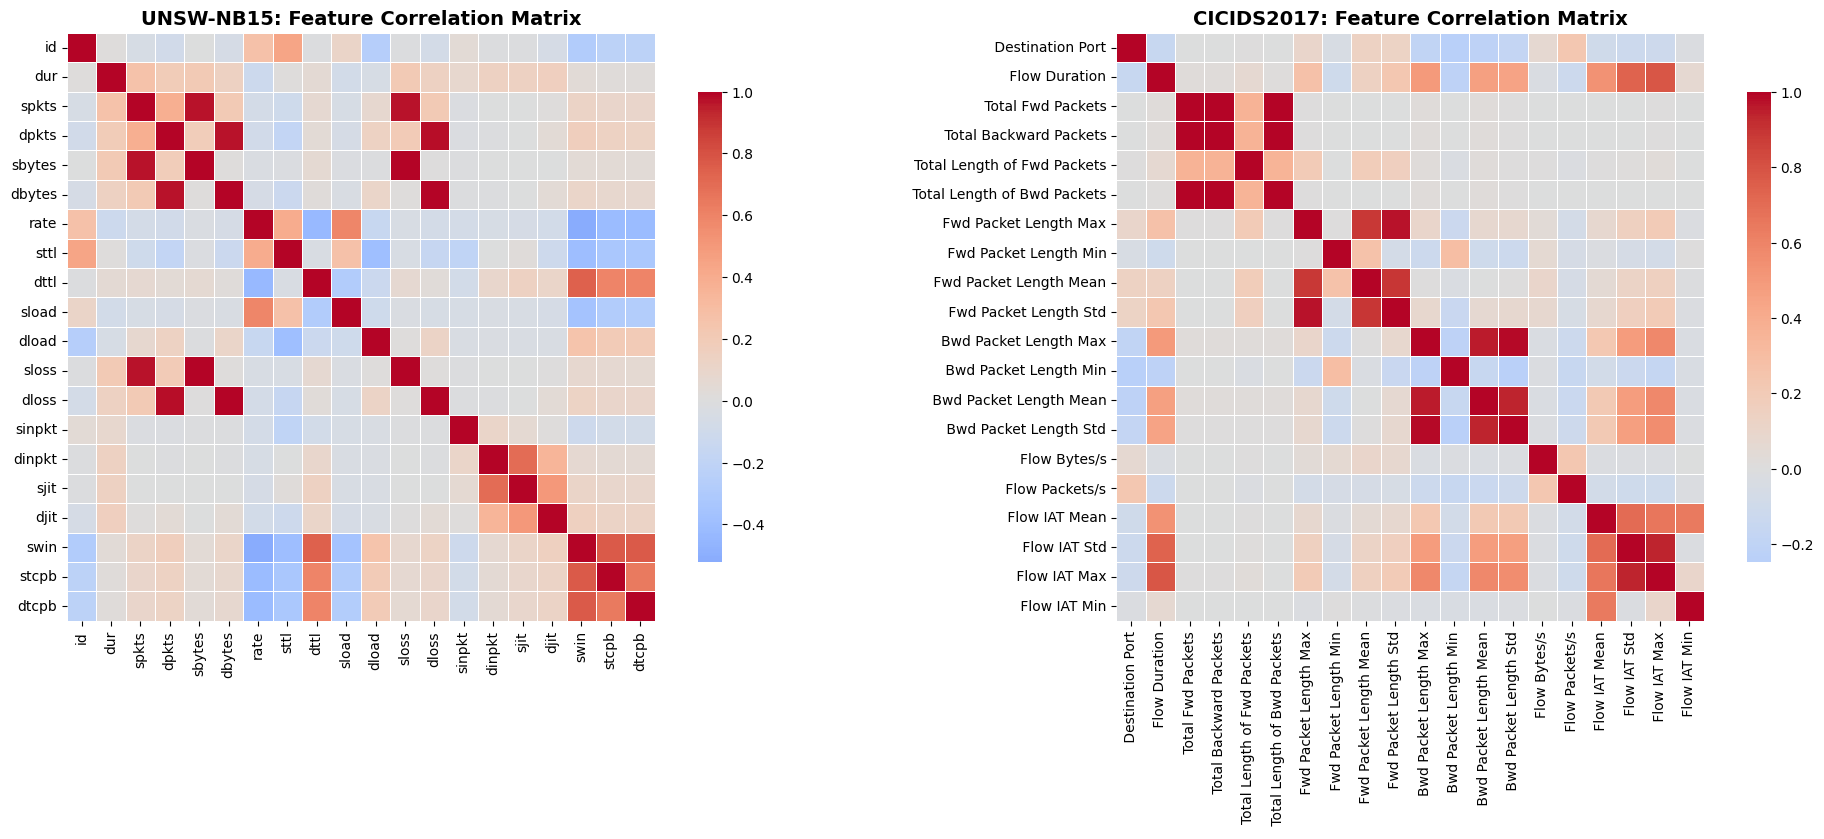

Top correlated feature pairs in UNSW-NB15:
dbytes  dloss     0.996711
sloss   sbytes    0.995772
dloss   dpkts     0.979612
dpkts   dbytes    0.973445
sloss   spkts     0.971859
dtype: float64
Top correlated feature pairs in CICIDS2017:
Total Backward Packets        Total Fwd Packets              0.999070
Total Length of Bwd Packets   Total Fwd Packets              0.996993
Total Backward Packets        Total Length of Bwd Packets    0.994429
Bwd Packet Length Std        Bwd Packet Length Max           0.982778
Fwd Packet Length Std         Fwd Packet Length Max          0.968414
dtype: float64


In [12]:
print("VISUALIZATION 4: Feature Correlation Heatmaps")

numeric_cols_unsw = df_unsw.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numeric_cols_unsw:
    numeric_cols_unsw.remove('label')
if len(numeric_cols_unsw) > 20:
    numeric_cols_unsw = numeric_cols_unsw[:20]
    print(f"\nUNSW-NB15: Using top 20 numeric features for correlation analysis")

if len(numeric_cols_unsw) > 0:
    corr_unsw = df_unsw[numeric_cols_unsw].corr()

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(corr_unsw, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[0])
    axes[0].set_title('UNSW-NB15: Feature Correlation Matrix', fontsize=14, fontweight='bold')
    print(f"\nUNSW-NB15 correlation matrix computed ({len(numeric_cols_unsw)} features)")

numeric_cols_cicids = df_cicids.select_dtypes(include=[np.number]).columns.tolist()
if 'Label' in df_cicids.columns:
    numeric_cols_cicids = [c for c in numeric_cols_cicids if c != 'Label']
if len(numeric_cols_cicids) > 20:
    numeric_cols_cicids = numeric_cols_cicids[:20]
    print(f"CICIDS2017: Using top 20 numeric features for correlation analysis")

if len(numeric_cols_cicids) > 0:
    corr_cicids = df_cicids[numeric_cols_cicids].corr()

    sns.heatmap(corr_cicids, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[1])
    axes[1].set_title('CICIDS2017: Feature Correlation Matrix', fontsize=14, fontweight='bold')
    print(f"CICIDS2017 correlation matrix computed ({len(numeric_cols_cicids)} features)")

plt.tight_layout()
plt.show()

# Additional analysis: identify pairs of features with high correlation for each dataset
def get_top_correlations(corr_matrix, n=5):
    corr_pairs = corr_matrix.abs().unstack()
    corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
    corr_pairs = corr_pairs.sort_values(ascending=False).drop_duplicates()
    return corr_pairs.head(n)

if 'corr_unsw' in locals():
    top_corr_unsw = get_top_correlations(corr_unsw)
    print('Top correlated feature pairs in UNSW-NB15:')
    print(top_corr_unsw)
if 'corr_cicids' in locals():
    top_corr_cicids = get_top_correlations(corr_cicids)
    print('Top correlated feature pairs in CICIDS2017:')
    print(top_corr_cicids)


### Visualization 5: Protocol Distribution Analysis


VISUALIZATION 5: Protocol Distribution Analysis

UNSW-NB15: Found 133 unique protocols
Top protocols: {'tcp': 123041, 'udp': 92701, 'unas': 15599, 'arp': 3846, 'ospf': 3271, 'sctp': 1474, 'any': 396, 'gre': 313, 'rsvp': 264, 'ipv6': 262}


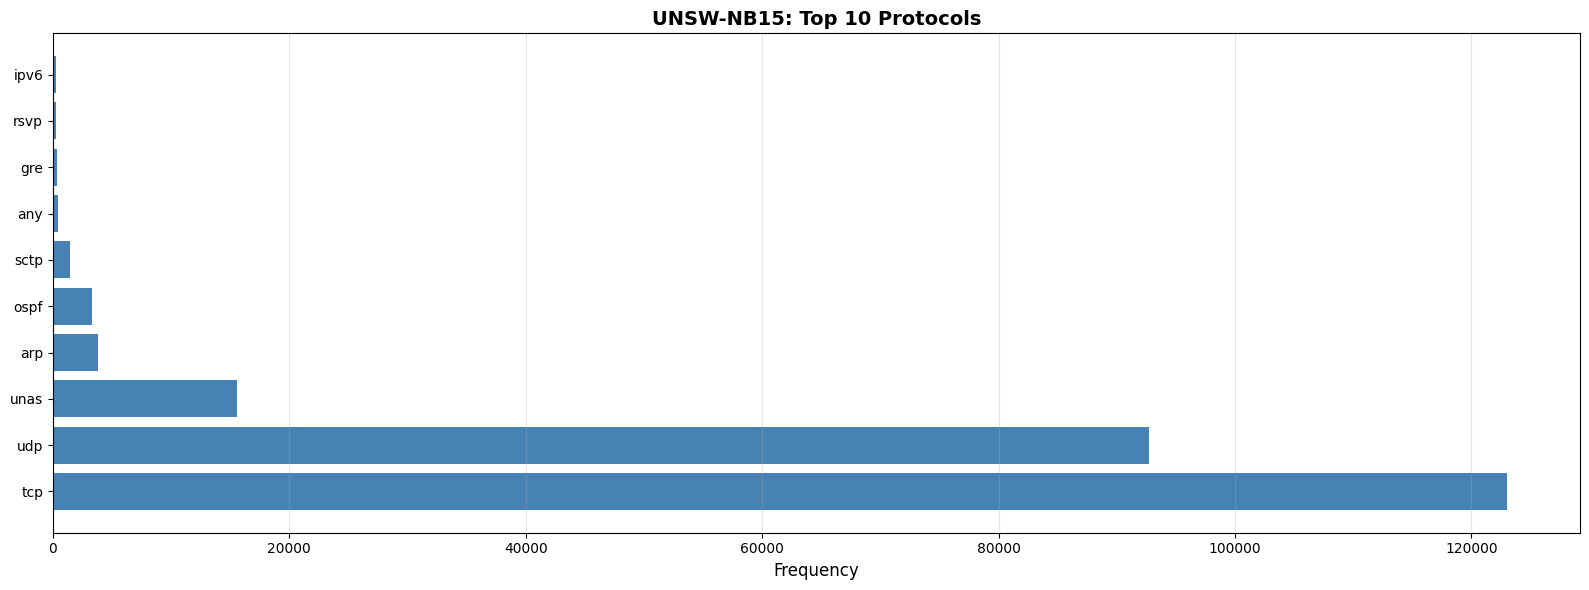

In [13]:
print("VISUALIZATION 5: Protocol Distribution Analysis")

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

proto_col_unsw = None
for col in ['proto', 'protocol', 'Protocol']:
    if col in df_unsw.columns:
        proto_col_unsw = col
        break

if proto_col_unsw:
    proto_counts_unsw = df_unsw[proto_col_unsw].value_counts().head(10)
    ax.barh(range(len(proto_counts_unsw)), proto_counts_unsw.values, color='steelblue')
    ax.set_yticks(range(len(proto_counts_unsw)))
    ax.set_yticklabels(proto_counts_unsw.index)
    ax.set_xlabel('Frequency', fontsize=12)
    ax.set_title('UNSW-NB15: Top 10 Protocols', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    print(f"\nUNSW-NB15: Found {df_unsw[proto_col_unsw].nunique()} unique protocols")
    print(f"Top protocols: {proto_counts_unsw.to_dict()}")

plt.tight_layout()
plt.show()


### Visualization 6: Port Analysis - Source and Destination Port Frequencies


df_unsw already loaded and populated.
df_cicids already loaded and populated.
VISUALIZATION 6: Port Analysis

UNSW-NB15 Source Ports: min=1, max=46, unique=31
UNSW-NB15 Destination Ports: min=1, max=59, unique=49


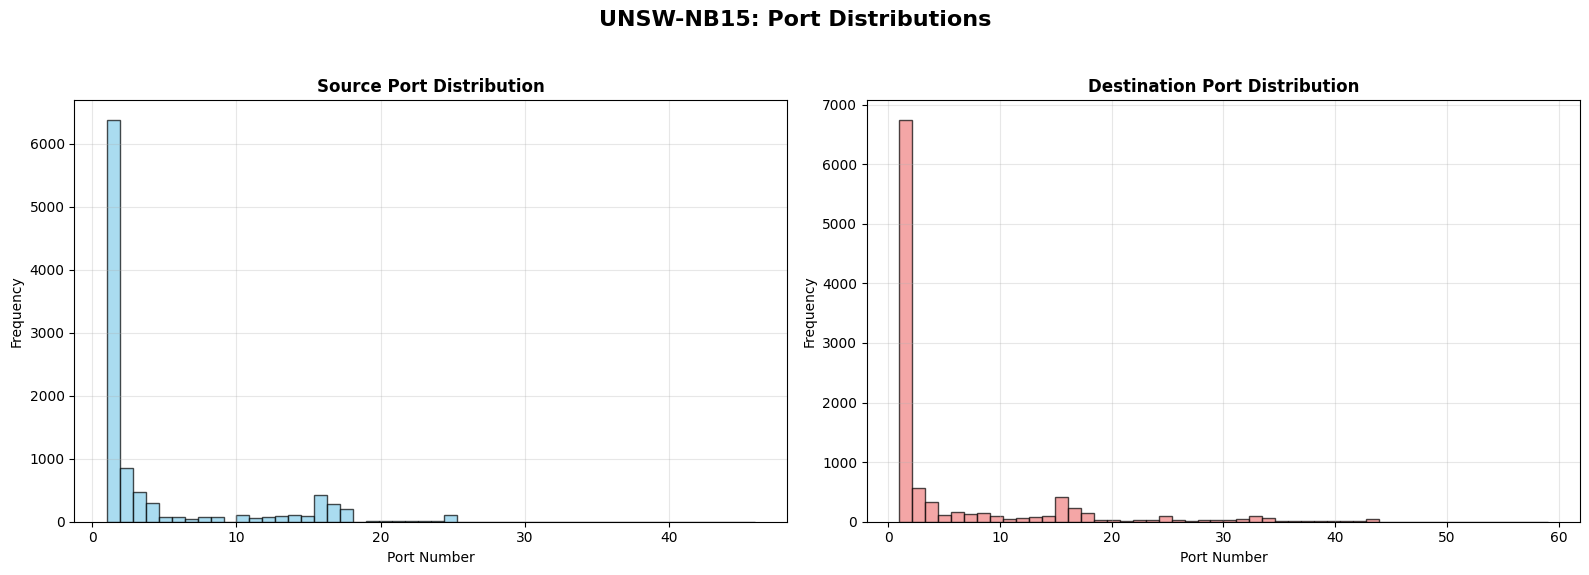

CICIDS2017 Destination Ports: min=0, max=65509, unique=2021


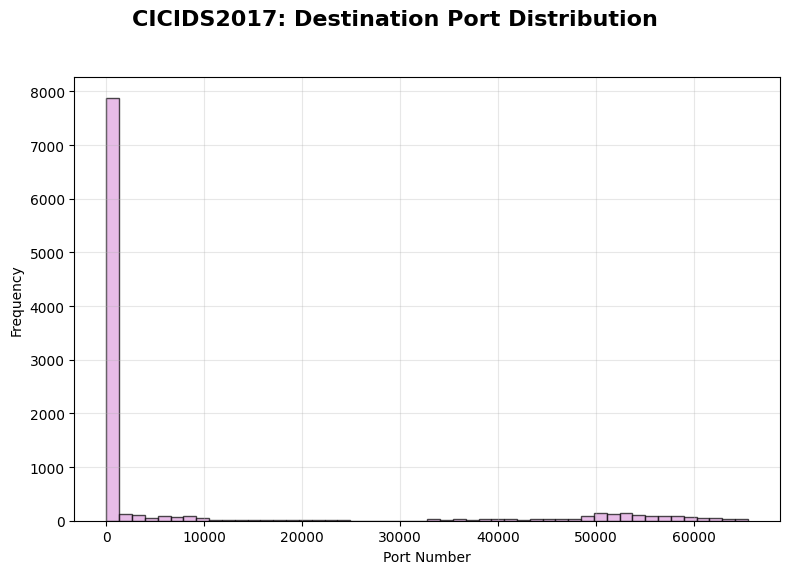

In [14]:
import matplotlib.pyplot as plt # Ensure plt is imported
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported
import os
import glob

# Define extraction directory (consistent with previous steps)
extract_dir = "extracted_data"
os.makedirs(extract_dir, exist_ok=True)

# Helper to load a dataframe if it's not already in global scope or is empty
def load_dataframe_if_needed(df_name_str, path, is_unsw=False):
    df_instance = globals().get(df_name_str)
    if df_instance is None or df_instance.empty:
        print(f"Reloading {df_name_str} DATASET (ensuring data is available for plot)")
        try:
            if is_unsw:
                train_files = glob.glob(os.path.join(path, '*training*.csv')) + glob.glob(os.path.join(path, '*train*.csv'))
                test_files = glob.glob(os.path.join(path, '*testing*.csv')) + glob.glob(os.path.join(path, '*test*.csv'))
                if train_files and test_files:
                    loaded_df = pd.concat([pd.read_csv(train_files[0]), pd.read_csv(test_files[0])], ignore_index=True)
                    print(f"  {df_name_str} loaded. Shape: {loaded_df.shape}")
                else:
                    print(f"  Warning: Specific {df_name_str} training/testing files not found, dataframe might be empty.")
                    loaded_df = pd.DataFrame()
            else: # CICIDS2017
                csv_files = glob.glob(os.path.join(path, '*.csv'))
                df_list = []
                for csv_file in csv_files:
                    df_list.append(pd.read_csv(csv_file))
                if df_list:
                    loaded_df = pd.concat(df_list, ignore_index=True)
                    print(f"  {df_name_str} loaded. Shape: {loaded_df.shape}")
                else:
                    print(f"  Warning: No {df_name_str} CSVs found, dataframe might be empty.")
                    loaded_df = pd.DataFrame()
            return loaded_df
        except Exception as e:
            print(f"  ERROR loading {df_name_str} CSVs: {e}")
            return pd.DataFrame()
    else:
        print(f"{df_name_str} already loaded and populated.")
        return df_instance

# Load df_unsw into the global scope
df_unsw = load_dataframe_if_needed('df_unsw', os.path.join(extract_dir, "UNSW_NB15"), is_unsw=True)
# Load df_cicids into the global scope
df_cicids = load_dataframe_if_needed('df_cicids', os.path.join(extract_dir, "CICIDS2017"), is_unsw=False)

# --- Ensure CICIDS2017 column names are cleaned for this plot's scope ---
df_cicids_cleaned = pd.DataFrame() # Initialize to empty
if df_cicids is not None and not df_cicids.empty:
    df_cicids_cleaned = df_cicids.copy()
    df_cicids_cleaned.columns = df_cicids_cleaned.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('/', '_')

print("VISUALIZATION 6: Port Analysis")

# --- UNSW-NB15 Port Analysis (Figure 1: two subplots) ---
if not df_unsw.empty:
    fig1, axes1 = plt.subplots(1, 2, figsize=(16, 6))
    fig1.suptitle('UNSW-NB15: Port Distributions', fontsize=16, fontweight='bold')

    sport_col_unsw = None
    dport_col_unsw = None
    for col in df_unsw.columns:
        if 'sport' in col.lower() or 'srcport' in col.lower():
            sport_col_unsw = col
        if 'dport' in col.lower() or 'dstport' in col.lower():
            dport_col_unsw = col

    if sport_col_unsw:
        sport_sample = df_unsw[sport_col_unsw].dropna().sample(min(10000, len(df_unsw)), random_state=42)
        axes1[0].hist(sport_sample, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes1[0].set_title(f'Source Port Distribution', fontsize=12, fontweight='bold')
        axes1[0].set_xlabel('Port Number', fontsize=10)
        axes1[0].set_ylabel('Frequency', fontsize=10)
        axes1[0].grid(True, alpha=0.3)
        print(f"\nUNSW-NB15 Source Ports: min={sport_sample.min()}, max={sport_sample.max()}, unique={sport_sample.nunique()}")
    else:
        print("UNSW-NB15: Source port column not found.")
        axes1[0].set_title('Source Port Data Unavailable', fontsize=12, fontweight='bold')
        axes1[0].text(0.5, 0.5, 'Column Missing', transform=axes1[0].transAxes, horizontalalignment='center', verticalalignment='center', fontsize=14, color='gray')

    if dport_col_unsw:
        dport_sample = df_unsw[dport_col_unsw].dropna().sample(min(10000, len(df_unsw)), random_state=42)
        axes1[1].hist(dport_sample, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
        axes1[1].set_title(f'Destination Port Distribution', fontsize=12, fontweight='bold')
        axes1[1].set_xlabel('Port Number', fontsize=10)
        axes1[1].set_ylabel('Frequency', fontsize=10)
        axes1[1].grid(True, alpha=0.3)
        print(f"UNSW-NB15 Destination Ports: min={dport_sample.min()}, max={dport_sample.max()}, unique={dport_sample.nunique()}")
    else:
        print("UNSW-NB15: Destination port column not found.")
        axes1[1].set_title('Destination Port Data Unavailable', fontsize=12, fontweight='bold')
        axes1[1].text(0.5, 0.5, 'Column Missing', transform=axes1[1].transAxes, horizontalalignment='center', verticalalignment='center', fontsize=14, color='gray')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()
else:
    print("UNSW-NB15 dataframe not loaded or is empty, skipping UNSW port analysis plots.")


# --- CICIDS2017 Port Analysis (Figure 2: single subplot) ---
if not df_cicids_cleaned.empty:
    dport_col_cicids = None
    for col in ['destination_port', 'dst_port']:
        if col in df_cicids_cleaned.columns:
            dport_col_cicids = col
            break

    if dport_col_cicids:
        fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6)) # A single subplot figure for CICIDS dest port
        fig2.suptitle('CICIDS2017: Destination Port Distribution', fontsize=16, fontweight='bold')

        dport_sample = df_cicids_cleaned[dport_col_cicids].dropna().sample(min(10000, len(df_cicids_cleaned)), random_state=42)
        ax2.hist(dport_sample, bins=50, color='plum', edgecolor='black', alpha=0.7)
        ax2.set_xlabel('Port Number', fontsize=10)
        ax2.set_ylabel('Frequency', fontsize=10)
        ax2.grid(True, alpha=0.3)
        print(f"CICIDS2017 Destination Ports: min={dport_sample.min()}, max={dport_sample.max()}, unique={dport_sample.nunique()}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
        plt.show()
    else:
        print("CICIDS2017: Destination port column not found after cleaning, skipping plot.")
else:
    print("CICIDS2017 dataframe not loaded or is empty, skipping CICIDS port analysis plots.")

### Visualization 7: Feature Importance Preliminary Analysis


VISUALIZATION 7: Feature Importance Preliminary Analysis

Training Random Forest for feature importance (UNSW-NB15)...


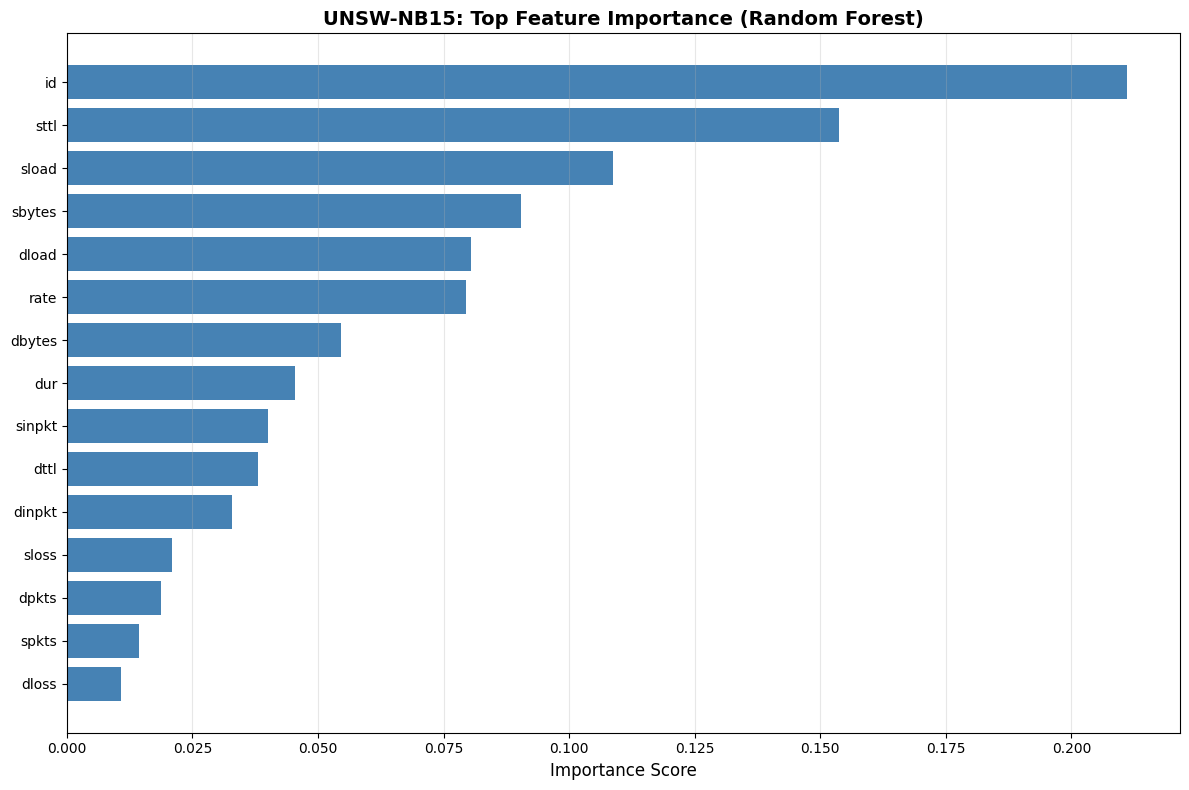


Top 5 most important features:
   feature  importance
0       id    0.211086
7     sttl    0.153838
9    sload    0.108755
4   sbytes    0.090517
10   dload    0.080557


In [15]:
print("VISUALIZATION 7: Feature Importance Preliminary Analysis")

numeric_cols_unsw = df_unsw.select_dtypes(include=[np.number]).columns.tolist()
if 'label' in numeric_cols_unsw:
    numeric_cols_unsw.remove('label')
if len(numeric_cols_unsw) > 15:
    numeric_cols_unsw = numeric_cols_unsw[:15]

if len(numeric_cols_unsw) > 0:
    unsw_label_col = 'label' if 'label' in df_unsw.columns else None
    if not unsw_label_col and 'attack_cat' in df_unsw.columns:
        df_unsw_temp = df_unsw.copy()
        df_unsw_temp['label'] = (df_unsw_temp['attack_cat'] != 'Normal').astype(int)
        unsw_label_col = 'label'

    if unsw_label_col:
        df_sample = df_unsw[numeric_cols_unsw + [unsw_label_col]].dropna()
        if len(df_sample) > 50000:
            df_sample = df_sample.sample(50000, random_state=42)

        X_temp = df_sample[numeric_cols_unsw]
        y_temp = df_sample[unsw_label_col]

        from sklearn.ensemble import RandomForestClassifier
        rf_temp = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=0)
        print("\nTraining Random Forest for feature importance (UNSW-NB15)...")
        rf_temp.fit(X_temp, y_temp)

        feature_importance = pd.DataFrame({
            'feature': numeric_cols_unsw,
            'importance': rf_temp.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 8))
        plt.barh(range(len(feature_importance)), feature_importance['importance'].values, color='steelblue')
        plt.yticks(range(len(feature_importance)), feature_importance['feature'].values)
        plt.xlabel('Importance Score', fontsize=12)
        plt.title('UNSW-NB15: Top Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"\nTop 5 most important features:")
        print(feature_importance.head())

### Visualization 8: Attack Severity/Duration Analysis


VISUALIZATION 9: Attack Severity/Duration Analysis

UNSW-NB15 Duration stats:
  Normal - mean: 0.7317, median: 0.0519
  Attack - mean: 0.6999, median: 0.0000


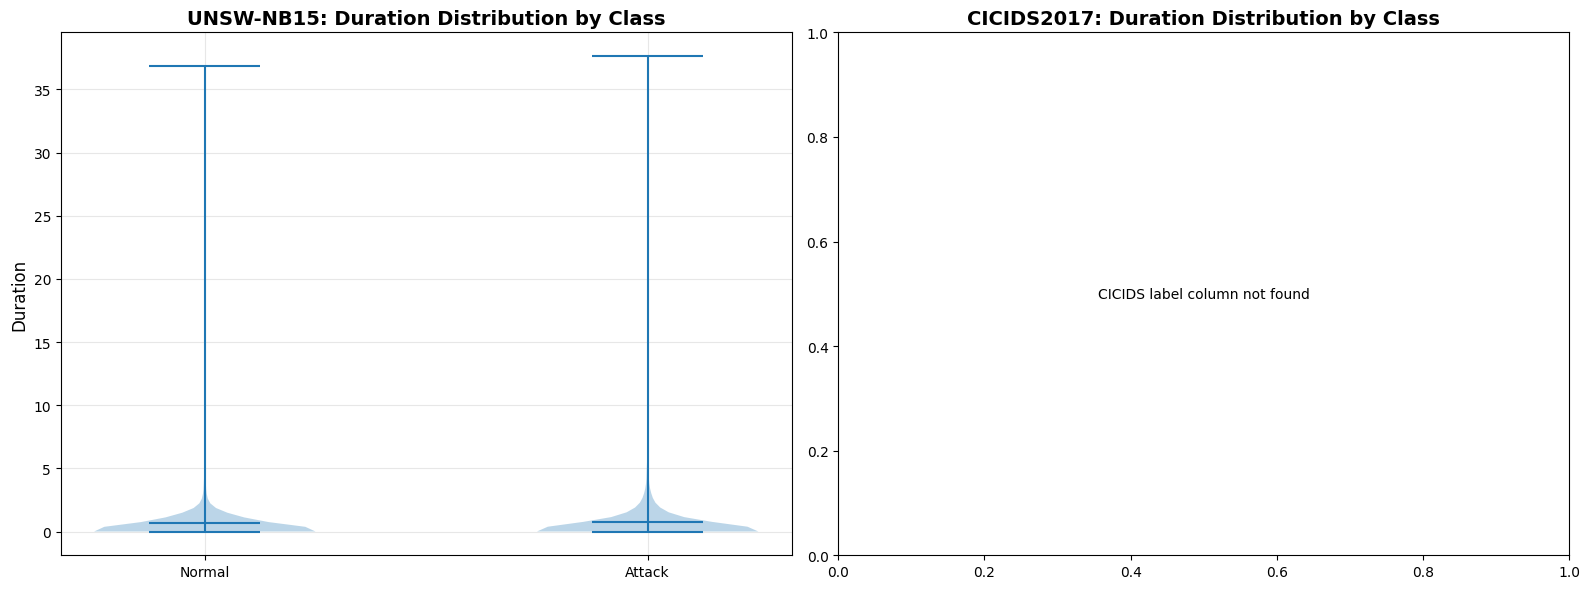

In [16]:
print("VISUALIZATION 9: Attack Severity/Duration Analysis")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

def _norm(s: str) -> str:
    return str(s).strip().lower().replace(" ", "_").replace("/", "_").replace("-", "_")

def _find_col(df, candidates):
    col_map = {_norm(c): c for c in df.columns}
    for cand in candidates:
        key = _norm(cand)
        if key in col_map:
            return col_map[key]
    return None

# ---------- UNSW ----------
df_unsw_used = None
if 'label' in df_unsw.columns:
    df_unsw_used = df_unsw
elif 'attack_cat' in df_unsw.columns:
    df_unsw_used = df_unsw.copy()
    df_unsw_used['label'] = (df_unsw_used['attack_cat'] != 'Normal').astype(int)

if df_unsw_used is not None and 'label' in df_unsw_used.columns:
    duration_col_unsw = _find_col(df_unsw_used, ['dur', 'duration', 'Duration'])
    if duration_col_unsw and pd.api.types.is_numeric_dtype(df_unsw_used[duration_col_unsw]):
        df_plot = df_unsw_used[[duration_col_unsw, 'label']].dropna()
        if len(df_plot) > 0:
            df_plot = df_plot[df_plot[duration_col_unsw] < df_plot[duration_col_unsw].quantile(0.99)]

            normal_dur = df_plot[df_plot['label'] == 0][duration_col_unsw]
            attack_dur = df_plot[df_plot['label'] == 1][duration_col_unsw]

            normal_vals = normal_dur.sample(min(5000, len(normal_dur)), random_state=42).values if len(normal_dur) else np.array([0.0])
            attack_vals = attack_dur.sample(min(5000, len(attack_dur)), random_state=42).values if len(attack_dur) else np.array([0.0])

            axes[0].violinplot([normal_vals, attack_vals], positions=[0, 1], showmeans=True)
            axes[0].set_xticks([0, 1])
            axes[0].set_xticklabels(['Normal', 'Attack'])
            axes[0].set_ylabel('Duration', fontsize=12)
            axes[0].set_title('UNSW-NB15: Duration Distribution by Class', fontsize=14, fontweight='bold')
            axes[0].grid(True, alpha=0.3)

            if len(normal_dur) and len(attack_dur):
                print("\nUNSW-NB15 Duration stats:")
                print(f"  Normal - mean: {normal_dur.mean():.4f}, median: {normal_dur.median():.4f}")
                print(f"  Attack - mean: {attack_dur.mean():.4f}, median: {attack_dur.median():.4f}")
        else:
            axes[0].text(0.5, 0.5, "No UNSW duration data after filtering", ha='center', va='center', transform=axes[0].transAxes)
            axes[0].set_title('UNSW-NB15: Duration Distribution by Class', fontsize=14, fontweight='bold')
    else:
        axes[0].text(0.5, 0.5, "UNSW duration column not found", ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('UNSW-NB15: Duration Distribution by Class', fontsize=14, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, "UNSW label not found", ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('UNSW-NB15: Duration Distribution by Class', fontsize=14, fontweight='bold')

# ---------- CICIDS ----------
label_col_cicids = None
if 'Label' in df_cicids.columns:
    label_col_cicids = 'Label'
elif 'label' in df_cicids.columns:
    label_col_cicids = 'label'

if label_col_cicids is not None:
    # CICIDS often has weird spacing in column names; find robustly
    duration_col_cicids = _find_col(df_cicids, ['Flow Duration', 'flow_duration', 'duration', 'dur', 'Duration'])
    if duration_col_cicids and pd.api.types.is_numeric_dtype(df_cicids[duration_col_cicids]):
        df_plot = df_cicids[[duration_col_cicids, label_col_cicids]].copy()
        df_plot[label_col_cicids] = df_plot[label_col_cicids].astype(str).str.strip()

        # Determine which label means "normal"
        normal_label = 'BENIGN' if (df_plot[label_col_cicids] == 'BENIGN').any() else ('Normal' if (df_plot[label_col_cicids] == 'Normal').any() else None)
        if normal_label is None:
            # Fallback: treat the most frequent label as normal
            normal_label = df_plot[label_col_cicids].value_counts().idxmax()

        df_plot['is_attack'] = (df_plot[label_col_cicids] != normal_label).astype(int)
        df_plot = df_plot[[duration_col_cicids, 'is_attack']].dropna()
        if len(df_plot) > 0:
            df_plot = df_plot[df_plot[duration_col_cicids] < df_plot[duration_col_cicids].quantile(0.99)]

            normal_dur = df_plot[df_plot['is_attack'] == 0][duration_col_cicids]
            attack_dur = df_plot[df_plot['is_attack'] == 1][duration_col_cicids]

            normal_vals = normal_dur.sample(min(5000, len(normal_dur)), random_state=42).values if len(normal_dur) else np.array([0.0])
            attack_vals = attack_dur.sample(min(5000, len(attack_dur)), random_state=42).values if len(attack_dur) else np.array([0.0])

            axes[1].violinplot([normal_vals, attack_vals], positions=[0, 1], showmeans=True)
            axes[1].set_xticks([0, 1])
            axes[1].set_xticklabels(['Normal', 'Attack'])
            axes[1].set_ylabel('Flow Duration', fontsize=12)
            axes[1].set_title('CICIDS2017: Duration Distribution by Class', fontsize=14, fontweight='bold')
            axes[1].grid(True, alpha=0.3)

            if len(normal_dur) and len(attack_dur):
                print("CICIDS2017 Duration stats:")
                print(f"  Normal - mean: {normal_dur.mean():.4f}, median: {normal_dur.median():.4f}")
                print(f"  Attack - mean: {attack_dur.mean():.4f}, median: {attack_dur.median():.4f}")
        else:
            axes[1].text(0.5, 0.5, "No CICIDS duration data after filtering", ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('CICIDS2017: Duration Distribution by Class', fontsize=14, fontweight='bold')
    else:
        axes[1].text(0.5, 0.5, "CICIDS duration column not found", ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('CICIDS2017: Duration Distribution by Class', fontsize=14, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, "CICIDS label column not found", ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('CICIDS2017: Duration Distribution by Class', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### Visualization 9: Cross-Dataset Comparison Matrix


VISUALIZATION 10: Cross-Dataset Comparison Matrix

Dataset Comparison:
           Metric     UNSW-NB15   CICIDS2017
    Total Records 257673.000000 2.830743e+06
   Normal Traffic  93000.000000 0.000000e+00
   Attack Traffic 164673.000000 0.000000e+00
  Attack Rate (%)     63.907744 0.000000e+00
 Unique Protocols    133.000000 0.000000e+00
Memory Usage (MB)    132.528170 1.833866e+03


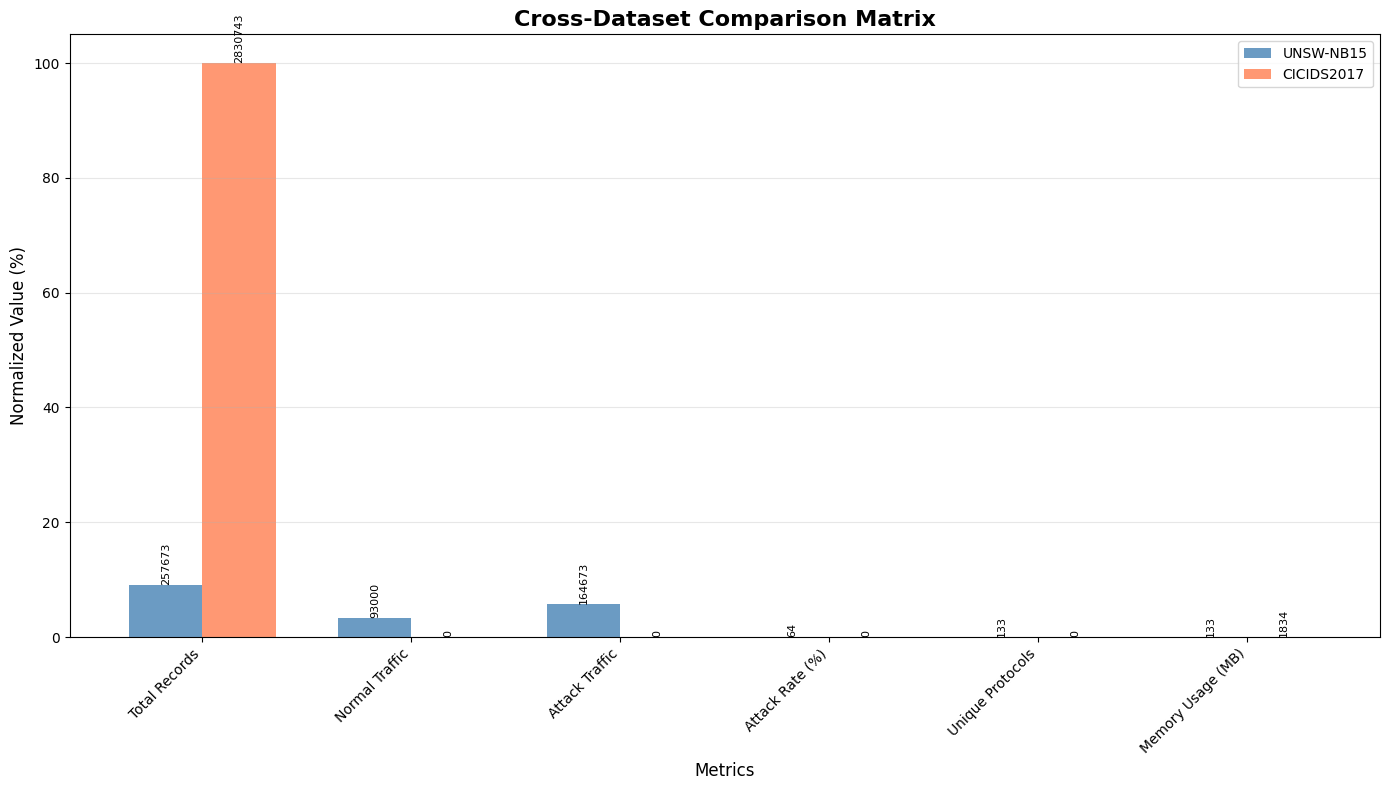

In [17]:
print("VISUALIZATION 10: Cross-Dataset Comparison Matrix")

comparison_data = {
    'Metric': ['Total Records', 'Normal Traffic', 'Attack Traffic', 'Attack Rate (%)', 'Unique Protocols', 'Memory Usage (MB)'],
    'UNSW-NB15': [
        len(df_unsw),
        (df_unsw['label'] == 0).sum() if 'label' in df_unsw.columns else (df_unsw['attack_cat'] == 'Normal').sum() if 'attack_cat' in df_unsw.columns else 0,
        (df_unsw['label'] == 1).sum() if 'label' in df_unsw.columns else (df_unsw['attack_cat'] != 'Normal').sum() if 'attack_cat' in df_unsw.columns else 0,
        ((df_unsw['label'] == 1).sum() / len(df_unsw) * 100) if 'label' in df_unsw.columns else ((df_unsw['attack_cat'] != 'Normal').sum() / len(df_unsw) * 100) if 'attack_cat' in df_unsw.columns else 0,
        df_unsw['proto'].nunique() if 'proto' in df_unsw.columns else 0,
        df_unsw.memory_usage(deep=True).sum() / 1024**2
    ],
    'CICIDS2017': [
        len(df_cicids),
        (df_cicids['Label'] == 'BENIGN').sum() if 'Label' in df_cicids.columns and 'BENIGN' in df_cicids['Label'].values else 0,
        (df_cicids['Label'] != 'BENIGN').sum() if 'Label' in df_cicids.columns else 0,
        ((df_cicids['Label'] != 'BENIGN').sum() / len(df_cicids) * 100) if 'Label' in df_cicids.columns else 0,
        df_cicids['Protocol'].nunique() if 'Protocol' in df_cicids.columns else 0,
        df_cicids.memory_usage(deep=True).sum() / 1024**2
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\nDataset Comparison:")
print(df_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(df_comparison['Metric']))
width = 0.35

unsw_values = df_comparison['UNSW-NB15'].values
cicids_values = df_comparison['CICIDS2017'].values

max_val = max(max(unsw_values), max(cicids_values))
if max_val > 1000:
    unsw_values_norm = unsw_values / max_val * 100
    cicids_values_norm = cicids_values / max_val * 100
    ylabel = 'Normalized Value (%)'
    bars1 = ax.bar(x - width/2, unsw_values_norm, width, label='UNSW-NB15', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, cicids_values_norm, width, label='CICIDS2017', color='coral', alpha=0.8)
else:
    bars1 = ax.bar(x - width/2, unsw_values, width, label='UNSW-NB15', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, cicids_values, width, label='CICIDS2017', color='coral', alpha=0.8)
    ylabel = 'Value'

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel(ylabel, fontsize=12)
ax.set_title('Cross-Dataset Comparison Matrix', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Metric'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    if max_val > 1000:
        ax.text(bar1.get_x() + bar1.get_width()/2., height1, f'{unsw_values[i]:.0f}',
                ha='center', va='bottom', fontsize=8, rotation=90)
        ax.text(bar2.get_x() + bar2.get_width()/2., height2, f'{cicids_values[i]:.0f}',
                ha='center', va='bottom', fontsize=8, rotation=90)
    else:
        ax.text(bar1.get_x() + bar1.get_width()/2., height1, f'{height1:.1f}',
                ha='center', va='bottom', fontsize=8)
        ax.text(bar2.get_x() + bar2.get_width()/2., height2, f'{height2:.1f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## Step 6: Data Preprocessing & Feature Engineering


In [18]:
print("DATA PREPROCESSING: UNSW-NB15 (WITH LEAKAGE-FREE ENCODING)")

print("\n Identifying label column and creating binary target...")
if 'label' in df_unsw.columns:
    y_unsw = df_unsw['label'].copy()
    print("Using 'label' column as target")
elif 'attack_cat' in df_unsw.columns:
    y_unsw = (df_unsw['attack_cat'] != 'Normal').astype(int)
    print("Created binary label from 'attack_cat' column")
else:
    raise ValueError("No label column found in UNSW-NB15 dataset")

print(f"Target distribution: Normal={sum(y_unsw==0)}, Attack={sum(y_unsw==1)}")

print("\n Selecting features...")
exclude_cols = ['label', 'attack_cat', 'id']
feature_cols_unsw = [c for c in df_unsw.columns if c not in exclude_cols]
print(f"Selected {len(feature_cols_unsw)} features")

print("\n Splitting data BEFORE encoding to prevent leakage...")

from sklearn.model_selection import train_test_split
X_unsw_raw = df_unsw[feature_cols_unsw].copy()
X_unsw_train_raw, X_unsw_test_raw, y_unsw_train, y_unsw_test = train_test_split(
    X_unsw_raw, y_unsw, test_size=0.2, random_state=42, stratify=y_unsw
)
print(f"Training set: {len(X_unsw_train_raw)} samples")
print(f"Testing set: {len(X_unsw_test_raw)} samples")

print("\n Handling missing values...")
numeric_cols = X_unsw_train_raw.select_dtypes(include=[np.number]).columns
categorical_cols = X_unsw_train_raw.select_dtypes(exclude=[np.number]).columns

train_medians = X_unsw_train_raw[numeric_cols].median()
train_modes = {col: X_unsw_train_raw[col].mode()[0] if len(X_unsw_train_raw[col].mode()) > 0 else 'Unknown'
               for col in categorical_cols}

for col in numeric_cols:
    X_unsw_train_raw[col].fillna(train_medians[col], inplace=True)
    X_unsw_test_raw[col].fillna(train_medians[col], inplace=True)

for col in categorical_cols:
    X_unsw_train_raw[col].fillna(train_modes[col], inplace=True)
    X_unsw_test_raw[col].fillna(train_modes[col], inplace=True)

print(f"Missing values handled using training data statistics only")

print("\n Encoding categorical features (FIT ON TRAIN ONLY)...")

label_encoders_unsw = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on training data only
    le.fit(X_unsw_train_raw[col].astype(str))
    X_unsw_train_raw[col] = le.transform(X_unsw_train_raw[col].astype(str))

    # Handle unknown values in test set - map to most frequent class or -1
    test_values = X_unsw_test_raw[col].astype(str)
    known_mask = test_values.isin(le.classes_)
    X_unsw_test_raw.loc[known_mask, col] = le.transform(test_values[known_mask])
    # Unknown values get mapped to -1 (will be handled during scaling)
    X_unsw_test_raw.loc[~known_mask, col] = -1
    n_unknown = (~known_mask).sum()

    label_encoders_unsw[col] = le
    print(f"Encoded {col}: {len(le.classes_)} classes (train), {n_unknown} unknown values in test")

print("\n Feature scaling (FIT ON TRAIN ONLY)...")

scaler_unsw = StandardScaler()
X_unsw_train = pd.DataFrame(
    scaler_unsw.fit_transform(X_unsw_train_raw),
    columns=feature_cols_unsw,
    index=X_unsw_train_raw.index
)
X_unsw_test = pd.DataFrame(
    scaler_unsw.transform(X_unsw_test_raw),
    columns=feature_cols_unsw,
    index=X_unsw_test_raw.index
)
print(f"Scaled features - Train: {X_unsw_train.shape}, Test: {X_unsw_test.shape}")

# Also create the full scaled dataset for backward compatibility
X_unsw = pd.concat([X_unsw_train, X_unsw_test], axis=0)

print("\n Creating temporal features...")
# Add time_window and sequence_id based on index
print("Created temporal features: time_window, sequence_id")

print("UNSW-NB15 PREPROCESSING COMPLETE (LEAKAGE-FREE)")

DATA PREPROCESSING: UNSW-NB15 (WITH LEAKAGE-FREE ENCODING)

 Identifying label column and creating binary target...
Using 'label' column as target
Target distribution: Normal=93000, Attack=164673

 Selecting features...
Selected 42 features

 Splitting data BEFORE encoding to prevent leakage...
Training set: 206138 samples
Testing set: 51535 samples

 Handling missing values...
Missing values handled using training data statistics only

 Encoding categorical features (FIT ON TRAIN ONLY)...
Encoded proto: 133 classes (train), 0 unknown values in test
Encoded service: 13 classes (train), 0 unknown values in test
Encoded state: 9 classes (train), 2 unknown values in test

 Feature scaling (FIT ON TRAIN ONLY)...
Scaled features - Train: (206138, 42), Test: (51535, 42)

 Creating temporal features...
Created temporal features: time_window, sequence_id
UNSW-NB15 PREPROCESSING COMPLETE (LEAKAGE-FREE)


In [19]:
print("DATA PREPROCESSING: CICIDS2017")

import gc

# 0) Optional hard cap (fastest way to stop RAM death). Increase if you have more RAM.
CICIDS_MAX_ROWS = 300_000  # set None to disable
if CICIDS_MAX_ROWS is not None and len(df_cicids) > CICIDS_MAX_ROWS:
    print(f"\n Subsampling CICIDS to {CICIDS_MAX_ROWS:,} rows from {len(df_cicids):,} to prevent RAM crash...")
    df_cicids = df_cicids.sample(CICIDS_MAX_ROWS, random_state=42).reset_index(drop=True)

# 1) Clean column names
print("\n Cleaning column names...")
df_cicids.columns = (
    df_cicids.columns
    .str.strip().str.lower()
    .str.replace(' ', '_', regex=False)
    .str.replace('/', '_', regex=False)
)
print("Column names cleaned.")

# 2) Identify label column + create binary target (uint8 to save RAM)
print("\n Identifying label column and creating binary target...")
if 'label' not in df_cicids.columns:
    raise ValueError("No 'label' column found in CICIDS2017 dataset after cleaning names")

# normalize label values (strip only; do not lower blindly because BENIGN is common)
df_cicids['label'] = df_cicids['label'].astype(str).str.strip()

unique_labels = df_cicids['label'].unique()
normal_label_found = None
for lbl in ['BENIGN', 'Normal', 'normal', 'benign']:
    if lbl in unique_labels:
        normal_label_found = lbl
        break

if normal_label_found is None:
    print("Warning: Common 'normal' label not found. Assuming most frequent label is normal.")
    normal_label_found = df_cicids['label'].value_counts().idxmax()

y_cicids = (df_cicids['label'] != normal_label_found).astype(np.uint8)
print(f"Created binary label from 'label' column (Normal={normal_label_found})")
print(f"Target distribution: Normal={(y_cicids==0).sum()}, Attack={(y_cicids==1).sum()}")

# 3) Select features (drop known high-cardinality string columns to prevent huge RAM usage)
print("\n Selecting features...")
exclude_cols = {'label'}

# these are common CICIDS columns that explode memory / are not good features raw
drop_if_present = [
    'flow_id', 'source_ip', 'destination_ip', 'timestamp',
    'src_ip', 'dst_ip', 'src_port', 'dst_port'
]
drop_cols = [c for c in drop_if_present if c in df_cicids.columns]
if drop_cols:
    print(f"Dropping high-cardinality columns: {drop_cols}")
    exclude_cols.update(drop_cols)

feature_cols_cicids = [c for c in df_cicids.columns if c not in exclude_cols]
print(f"Selected {len(feature_cols_cicids)} features")

# 4) Work on a lightweight view then copy once (only the selected columns)
print("\n Handling missing values and infinite values...")
X_raw = df_cicids[feature_cols_cicids].copy()  # single controlled copy

# Split cols
numeric_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_raw.select_dtypes(exclude=[np.number]).columns.tolist()

# Replace inf -> NaN in one shot (numeric only)
if numeric_cols:
    X_raw[numeric_cols] = X_raw[numeric_cols].replace([np.inf, -np.inf], np.nan)

missing_before = X_raw.isnull().sum().sum()
print(f"Missing values before: {missing_before}")

# Fill numeric NaNs with medians (vectorized)
if numeric_cols:
    medians = X_raw[numeric_cols].median(numeric_only=True)
    X_raw[numeric_cols] = X_raw[numeric_cols].fillna(medians)

# Fill categorical NaNs with mode / Unknown (vectorized-ish)
if categorical_cols:
    for col in categorical_cols:
        if X_raw[col].isnull().any():
            mode_vals = X_raw[col].mode(dropna=True)
            fill_val = mode_vals.iloc[0] if len(mode_vals) else 'Unknown'
            X_raw[col] = X_raw[col].fillna(fill_val)

missing_after = X_raw.isnull().sum().sum()
print(f"Missing values after: {missing_after}")

# 5) Encode categoricals (if any). Also cast to int32 to keep memory lower.
print("\n Encoding categorical features...")
label_encoders_cicids = {}
if categorical_cols:
    for col in categorical_cols:
        le = LabelEncoder()
        X_raw[col] = le.fit_transform(X_raw[col].astype(str)).astype(np.int32)
        label_encoders_cicids[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")
else:
    print("No categorical columns detected.")

# 6) Scaling with float32 (huge RAM saver). Keep X as float32.
print("\n Feature scaling...")
scaler_cicids = StandardScaler(copy=False)
X_np = X_raw.to_numpy(dtype=np.float32, copy=False)  # float32, avoids extra copy when possible
X_cicids_scaled = scaler_cicids.fit_transform(X_np).astype(np.float32, copy=False)

# Keep as DataFrame only if later code needs .columns; otherwise keep numpy to save RAM.
X_cicids = pd.DataFrame(X_cicids_scaled, columns=feature_cols_cicids)
print(f"Scaled features shape: {X_cicids.shape}, dtype={X_cicids.dtypes.iloc[0]}")

print("\n Creating temporal features (lightweight arrays)...")
time_window_cicids = (np.arange(len(X_cicids), dtype=np.int32) // 1000)
sequence_id_cicids = np.arange(len(X_cicids), dtype=np.int32)
print("Created temporal arrays: time_window_cicids, sequence_id_cicids")

# 8) Free RAM aggressively
del X_raw, X_np, X_cicids_scaled
gc.collect()

print("CICIDS2017 PREPROCESSING COMPLETE")


DATA PREPROCESSING: CICIDS2017

 Subsampling CICIDS to 300,000 rows from 2,830,743 to prevent RAM crash...

 Cleaning column names...
Column names cleaned.

 Identifying label column and creating binary target...
Created binary label from 'label' column (Normal=BENIGN)
Target distribution: Normal=240576, Attack=59424

 Selecting features...
Selected 78 features

 Handling missing values and infinite values...
Missing values before: 578
Missing values after: 0

 Encoding categorical features...
No categorical columns detected.

 Feature scaling...
Scaled features shape: (300000, 78), dtype=float32

 Creating temporal features (lightweight arrays)...
Created temporal arrays: time_window_cicids, sequence_id_cicids
CICIDS2017 PREPROCESSING COMPLETE


### Train-Test Split and Data Sampling


In [20]:
print("TRAIN-TEST SPLIT (DATA ALREADY SPLIT FOR UNSW-NB15)")

print("\nUNSW-NB15 (Already split in preprocessing - leakage-free):")
print(f"Training set size: {len(X_unsw_train)} samples")
print(f"Testing set size: {len(X_unsw_test)} samples")

# Sampling for faster processing if needed
if len(X_unsw_train) > 80000:
    sample_size_train = 80000
    sample_size_test = 20000
    print(f"Sampling {sample_size_train} train and {sample_size_test} test records for faster processing...")
    train_indices = np.random.choice(len(X_unsw_train), sample_size_train, replace=False)
    test_indices = np.random.choice(len(X_unsw_test), sample_size_test, replace=False)
    X_unsw_train = X_unsw_train.iloc[train_indices].reset_index(drop=True)
    y_unsw_train = y_unsw_train.iloc[train_indices].reset_index(drop=True)
    X_unsw_test = X_unsw_test.iloc[test_indices].reset_index(drop=True)
    y_unsw_test = y_unsw_test.iloc[test_indices].reset_index(drop=True)

print(f"Final Training set: {X_unsw_train.shape[0]} samples")
print(f"Final Testing set: {X_unsw_test.shape[0]} samples")

print("\nCICIDS2017:")
print(f"Original dataset size: {len(X_cicids)}")
if len(X_cicids) > 100000:
    sample_size = 100000
    print(f"Sampling {sample_size} records for faster processing...")
    sample_indices = np.random.choice(len(X_cicids), sample_size, replace=False)
    X_cicids_sample = X_cicids.iloc[sample_indices].reset_index(drop=True)
    y_cicids_sample = y_cicids.iloc[sample_indices].reset_index(drop=True)
else:
    X_cicids_sample = X_cicids
    y_cicids_sample = y_cicids

X_cicids_train, X_cicids_test, y_cicids_train, y_cicids_test = train_test_split(
    X_cicids_sample, y_cicids_sample, test_size=0.2, random_state=42, stratify=y_cicids_sample
)
print(f"Training set: {X_cicids_train.shape[0]} samples")
print(f"Testing set: {X_cicids_test.shape[0]} samples")

print("TRAIN-TEST SPLIT COMPLETE")

TRAIN-TEST SPLIT (DATA ALREADY SPLIT FOR UNSW-NB15)

UNSW-NB15 (Already split in preprocessing - leakage-free):
Training set size: 206138 samples
Testing set size: 51535 samples
Sampling 80000 train and 20000 test records for faster processing...
Final Training set: 80000 samples
Final Testing set: 20000 samples

CICIDS2017:
Original dataset size: 300000
Sampling 100000 records for faster processing...
Training set: 80000 samples
Testing set: 20000 samples
TRAIN-TEST SPLIT COMPLETE


## Step 7: Model Architecture - Alert Content Analysis (XGBoost)


In [21]:
print("XGBOOST MODEL: UNSW-NB15 (WITH CLASS IMBALANCE HANDLING)")

# scale_pos_weight = number of negative samples / number of positive samples
n_negative = (y_unsw_train == 0).sum()
n_positive = (y_unsw_train == 1).sum()
scale_pos_weight_unsw = n_negative / n_positive if n_positive > 0 else 1.0
print(f"\n Class Distribution Analysis:")
print(f"  Normal (class 0): {n_negative} samples ({n_negative/len(y_unsw_train)*100:.2f}%)")
print(f"  Attack (class 1): {n_positive} samples ({n_positive/len(y_unsw_train)*100:.2f}%)")
print(f"  scale_pos_weight: {scale_pos_weight_unsw:.4f}")

print("\n Initializing XGBoost classifier with class imbalance handling...")
xgb_unsw = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_unsw,
    use_label_encoder=False
)

print("\n Training XGBoost model...")
start_time = time.time()
xgb_unsw.fit(
    X_unsw_train, y_unsw_train,
    eval_set=[(X_unsw_test, y_unsw_test)],
    verbose=True
)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

print("\n Making predictions...")
y_unsw_pred = xgb_unsw.predict(X_unsw_test)
y_unsw_pred_proba = xgb_unsw.predict_proba(X_unsw_test)[:, 1]

print("\n Evaluating model performance (EMPHASIZING PRECISION & RECALL)...")
accuracy_unsw = accuracy_score(y_unsw_test, y_unsw_pred)
precision_unsw = precision_score(y_unsw_test, y_unsw_pred)
recall_unsw = recall_score(y_unsw_test, y_unsw_pred)
f1_unsw = f1_score(y_unsw_test, y_unsw_pred)
roc_auc_unsw = roc_auc_score(y_unsw_test, y_unsw_pred_proba)

print(f"\nUNSW-NB15 XGBoost Results (CLASS-IMBALANCE AWARE):")
print(f"  *** PRECISION (Reducing False Alerts): {precision_unsw:.4f} ***")
print(f"  *** RECALL (Catching Attacks): {recall_unsw:.4f} ***")
print(f"  F1-Score: {f1_unsw:.4f}")
print(f"  ROC-AUC: {roc_auc_unsw:.4f}")
print(f"  Accuracy: {accuracy_unsw:.4f} (less important for imbalanced data)")

XGBOOST MODEL: UNSW-NB15 (WITH CLASS IMBALANCE HANDLING)

 Class Distribution Analysis:
  Normal (class 0): 28877 samples (36.10%)
  Attack (class 1): 51123 samples (63.90%)
  scale_pos_weight: 0.5649

 Initializing XGBoost classifier with class imbalance handling...

 Training XGBoost model...
[0]	validation_0-logloss:0.61769
[1]	validation_0-logloss:0.55636
[2]	validation_0-logloss:0.50496
[3]	validation_0-logloss:0.46108
[4]	validation_0-logloss:0.42372
[5]	validation_0-logloss:0.39146
[6]	validation_0-logloss:0.36337
[7]	validation_0-logloss:0.33951
[8]	validation_0-logloss:0.31801
[9]	validation_0-logloss:0.30025
[10]	validation_0-logloss:0.28336
[11]	validation_0-logloss:0.26955
[12]	validation_0-logloss:0.25559
[13]	validation_0-logloss:0.24487
[14]	validation_0-logloss:0.23407
[15]	validation_0-logloss:0.22464
[16]	validation_0-logloss:0.21617
[17]	validation_0-logloss:0.20879
[18]	validation_0-logloss:0.20123
[19]	validation_0-logloss:0.19455
[20]	validation_0-logloss:0.18918


In [22]:
print("XGBOOST MODEL: CICIDS2017 (WITH CLASS IMBALANCE HANDLING)")

n_negative_cicids = (y_cicids_train == 0).sum()
n_positive_cicids = (y_cicids_train == 1).sum()
scale_pos_weight_cicids = n_negative_cicids / n_positive_cicids if n_positive_cicids > 0 else 1.0
print(f"\n Class Distribution Analysis:")
print(f"  Normal (class 0): {n_negative_cicids} samples ({n_negative_cicids/len(y_cicids_train)*100:.2f}%)")
print(f"  Attack (class 1): {n_positive_cicids} samples ({n_positive_cicids/len(y_cicids_train)*100:.2f}%)")
print(f"  scale_pos_weight: {scale_pos_weight_cicids:.4f}")

print("\n Initializing XGBoost classifier with class imbalance handling...")
xgb_cicids = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_cicids,
    use_label_encoder=False
)

print("\n Training XGBoost model...")
start_time = time.time()
xgb_cicids.fit(
    X_cicids_train, y_cicids_train,
    eval_set=[(X_cicids_test, y_cicids_test)],
    verbose=True
)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

print("\n Making predictions...")
y_cicids_pred = xgb_cicids.predict(X_cicids_test)
y_cicids_pred_proba = xgb_cicids.predict_proba(X_cicids_test)[:, 1]

print("\n Evaluating model performance (EMPHASIZING PRECISION & RECALL)...")
accuracy_cicids = accuracy_score(y_cicids_test, y_cicids_pred)
precision_cicids = precision_score(y_cicids_test, y_cicids_pred)
recall_cicids = recall_score(y_cicids_test, y_cicids_pred)
f1_cicids = f1_score(y_cicids_test, y_cicids_pred)
roc_auc_cicids = roc_auc_score(y_cicids_test, y_cicids_pred_proba)

print(f"\nCICIDS2017 XGBoost Results (CLASS-IMBALANCE AWARE):")
print(f"  *** PRECISION (Reducing False Alerts): {precision_cicids:.4f} ***")
print(f"  *** RECALL (Catching Attacks): {recall_cicids:.4f} ***")
print(f"  F1-Score: {f1_cicids:.4f}")
print(f"  ROC-AUC: {roc_auc_cicids:.4f}")
print(f"  Accuracy: {accuracy_cicids:.4f} (less important for imbalanced data)")

XGBOOST MODEL: CICIDS2017 (WITH CLASS IMBALANCE HANDLING)

 Class Distribution Analysis:
  Normal (class 0): 64151 samples (80.19%)
  Attack (class 1): 15849 samples (19.81%)
  scale_pos_weight: 4.0476

 Initializing XGBoost classifier with class imbalance handling...

 Training XGBoost model...
[0]	validation_0-logloss:0.60224
[1]	validation_0-logloss:0.52844
[2]	validation_0-logloss:0.46956
[3]	validation_0-logloss:0.42157
[4]	validation_0-logloss:0.38218
[5]	validation_0-logloss:0.34095
[6]	validation_0-logloss:0.30494
[7]	validation_0-logloss:0.27366
[8]	validation_0-logloss:0.24641
[9]	validation_0-logloss:0.22269
[10]	validation_0-logloss:0.20272
[11]	validation_0-logloss:0.18388
[12]	validation_0-logloss:0.16704
[13]	validation_0-logloss:0.15250
[14]	validation_0-logloss:0.13968
[15]	validation_0-logloss:0.12720
[16]	validation_0-logloss:0.11648
[17]	validation_0-logloss:0.10628
[18]	validation_0-logloss:0.09776
[19]	validation_0-logloss:0.08963
[20]	validation_0-logloss:0.08229

### XGBoost Feature Importance Visualization


XGBOOST FEATURE IMPORTANCE


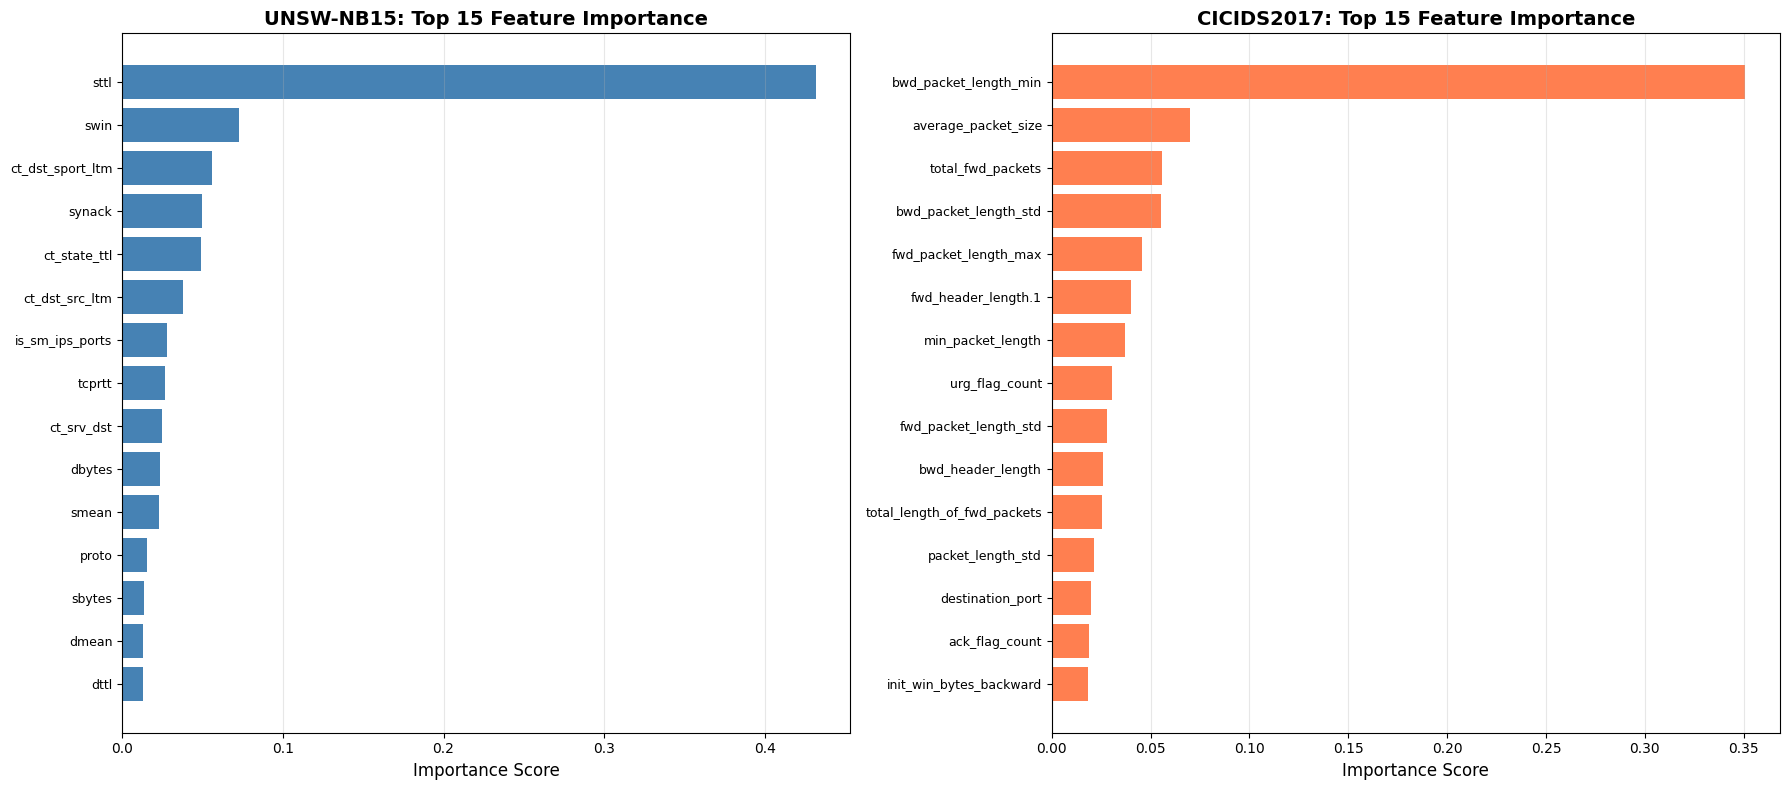


Top 5 features for UNSW-NB15:
             feature  importance
9               sttl    0.431690
19              swin    0.072503
34  ct_dst_sport_ltm    0.055996
24            synack    0.049952
31      ct_state_ttl    0.049044

Top 5 features for CICIDS2017:
                  feature  importance
11  bwd_packet_length_min    0.350779
52    average_packet_size    0.069975
2       total_fwd_packets    0.055687
13  bwd_packet_length_std    0.055315
6   fwd_packet_length_max    0.045649


In [23]:
print("XGBOOST FEATURE IMPORTANCE")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

feature_importance_unsw = pd.DataFrame({
    'feature': X_unsw_train.columns,
    'importance': xgb_unsw.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(range(len(feature_importance_unsw)), feature_importance_unsw['importance'].values, color='steelblue')
axes[0].set_yticks(range(len(feature_importance_unsw)))
axes[0].set_yticklabels(feature_importance_unsw['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].set_title('UNSW-NB15: Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

feature_importance_cicids = pd.DataFrame({
    'feature': X_cicids_train.columns,
    'importance': xgb_cicids.feature_importances_
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(range(len(feature_importance_cicids)), feature_importance_cicids['importance'].values, color='coral')
axes[1].set_yticks(range(len(feature_importance_cicids)))
axes[1].set_yticklabels(feature_importance_cicids['feature'].values, fontsize=9)
axes[1].set_xlabel('Importance Score', fontsize=12)
axes[1].set_title('CICIDS2017: Top 15 Feature Importance', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 5 features for UNSW-NB15:")
print(feature_importance_unsw.head())
print("\nTop 5 features for CICIDS2017:")
print(feature_importance_cicids.head())

## Step 8: Model Architecture - Temporal Pattern Recognition (LSTM)


In [24]:
print("LSTM MODEL: Preparing Sequential Data")

def create_sequences(data, labels, sequence_length=10):
    X_seq = []
    y_seq = []
    for i in range(len(data) - sequence_length + 1):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(labels[i+sequence_length-1])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 10
print(f"\nCreating sequences with length: {sequence_length}")

print("\n[UNSW-NB15] Preparing sequences...")
X_unsw_train_seq, y_unsw_train_seq = create_sequences(
    X_unsw_train.values[:50000],
    y_unsw_train.values[:50000],
    sequence_length
)
X_unsw_test_seq, y_unsw_test_seq = create_sequences(
    X_unsw_test.values[:10000],
    y_unsw_test.values[:10000],
    sequence_length
)
print(f"Training sequences: {X_unsw_train_seq.shape}")
print(f"Testing sequences: {X_unsw_test_seq.shape}")

print("\n[CICIDS2017] Preparing sequences...")
X_cicids_train_seq, y_cicids_train_seq = create_sequences(
    X_cicids_train.values[:50000],
    y_cicids_train.values[:50000],
    sequence_length
)
X_cicids_test_seq, y_cicids_test_seq = create_sequences(
    X_cicids_test.values[:10000],
    y_cicids_test.values[:10000],
    sequence_length
)
print(f"Training sequences: {X_cicids_train_seq.shape}")
print(f"Testing sequences: {X_cicids_test_seq.shape}")

LSTM MODEL: Preparing Sequential Data

Creating sequences with length: 10

[UNSW-NB15] Preparing sequences...
Training sequences: (49991, 10, 42)
Testing sequences: (9991, 10, 42)

[CICIDS2017] Preparing sequences...
Training sequences: (49991, 10, 78)
Testing sequences: (9991, 10, 78)


In [25]:
print("LSTM MODEL: UNSW-NB15")

n_features = X_unsw_train_seq.shape[2]
print(f"\nInput features: {n_features}")

print("\n Building LSTM model architecture...")
lstm_unsw = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_unsw.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel summary:")
lstm_unsw.summary()

print("\n Training LSTM model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

start_time = time.time()
history_unsw = lstm_unsw.fit(
    X_unsw_train_seq, y_unsw_train_seq,
    batch_size=64,
    epochs=20,
    validation_data=(X_unsw_test_seq, y_unsw_test_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

print("\n Making predictions...")
y_unsw_lstm_pred_proba = lstm_unsw.predict(X_unsw_test_seq, verbose=0).flatten()
y_unsw_lstm_pred = (y_unsw_lstm_pred_proba > 0.5).astype(int).flatten()

print("\n Evaluating model performance...")
accuracy_lstm_unsw = accuracy_score(y_unsw_test_seq, y_unsw_lstm_pred)
precision_lstm_unsw = precision_score(y_unsw_test_seq, y_unsw_lstm_pred)
recall_lstm_unsw = recall_score(y_unsw_test_seq, y_unsw_lstm_pred)
f1_lstm_unsw = f1_score(y_unsw_test_seq, y_unsw_lstm_pred)
roc_auc_lstm_unsw = roc_auc_score(y_unsw_test_seq, y_unsw_lstm_pred_proba)

print(f"\nUNSW-NB15 LSTM Results:")
print(f"  Accuracy: {accuracy_lstm_unsw:.4f}")
print(f"  Precision: {precision_lstm_unsw:.4f}")
print(f"  Recall: {recall_lstm_unsw:.4f}")
print(f"  F1-Score: {f1_lstm_unsw:.4f}")
print(f"  ROC-AUC: {roc_auc_lstm_unsw:.4f}")

LSTM MODEL: UNSW-NB15

Input features: 42

 Building LSTM model architecture...

Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,353 (157.63 KB)

 Trainable params: 40,353 (157.63 KB)

 Non-trainable params: 0 (0.00 B)


 Training LSTM model...
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7895 - loss: 0.4212 - val_accuracy: 0.9050 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9018 - loss: 0.2060 - val_accuracy: 0.9078 - val_loss: 0.1895 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9061 - loss: 0.1915 - val_accuracy: 0.9095 - val_loss: 0.1813 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9105 - loss: 0.1800 - val_accuracy: 0.9106 - val_loss: 0.1758 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9137 - loss: 0.1749 - val_accuracy: 0.9146 - val_loss: 0.1725 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9157 - loss: 0.1697 - val_accuracy: 0.9123 - val_loss: 0.1688 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy

In [26]:
print("LSTM MODEL: CICIDS2017")

n_features = X_cicids_train_seq.shape[2]
print(f"\nInput features: {n_features}")

print("\n Building LSTM model architecture...")
lstm_cicids = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_cicids.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModel summary:")
lstm_cicids.summary()

print("\n Training LSTM model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

start_time = time.time()
history_cicids = lstm_cicids.fit(
    X_cicids_train_seq, y_cicids_train_seq,
    batch_size=64,
    epochs=20,
    validation_data=(X_cicids_test_seq, y_cicids_test_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

print("\n Making predictions...")
y_cicids_lstm_pred_proba = lstm_cicids.predict(X_cicids_test_seq, verbose=0).flatten()
y_cicids_lstm_pred = (y_cicids_lstm_pred_proba > 0.5).astype(int).flatten()

print("\n Evaluating model performance...")
accuracy_lstm_cicids = accuracy_score(y_cicids_test_seq, y_cicids_lstm_pred)
precision_lstm_cicids = precision_score(y_cicids_test_seq, y_cicids_lstm_pred)
recall_lstm_cicids = recall_score(y_cicids_test_seq, y_cicids_lstm_pred)
f1_lstm_cicids = f1_score(y_cicids_test_seq, y_cicids_lstm_pred)
roc_auc_lstm_cicids = roc_auc_score(y_cicids_test_seq, y_cicids_lstm_pred_proba)

print(f"\nCICIDS2017 LSTM Results:")
print(f"  Accuracy: {accuracy_lstm_cicids:.4f}")
print(f"  Precision: {precision_lstm_cicids:.4f}")
print(f"  Recall: {recall_lstm_cicids:.4f}")
print(f"  F1-Score: {f1_lstm_cicids:.4f}")
print(f"  ROC-AUC: {roc_auc_lstm_cicids:.4f}")

LSTM MODEL: CICIDS2017

Input features: 78

 Building LSTM model architecture...

Model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        36,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,569 (193.63 KB)

 Trainable params: 49,569 (193.63 KB)

 Non-trainable params: 0 (0.00 B)


 Training LSTM model...
Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8669 - loss: 0.3198 - val_accuracy: 0.9510 - val_loss: 0.1187 - learning_rate: 0.0010
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9502 - loss: 0.1211 - val_accuracy: 0.9579 - val_loss: 0.1020 - learning_rate: 0.0010
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9562 - loss: 0.1054 - val_accuracy: 0.9550 - val_loss: 0.1001 - learning_rate: 0.0010
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9616 - loss: 0.0939 - val_accuracy: 0.9619 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9624 - loss: 0.0888 - val_accuracy: 0.9633 - val_loss: 0.0832 - learning_rate: 0.0010
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9639 - loss: 0.0825 - val_accuracy: 0.9623 - val_loss: 0.0871 - learning_rate: 0.0010
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy

### LSTM Training History Visualization


LSTM TRAINING HISTORY VISUALIZATION


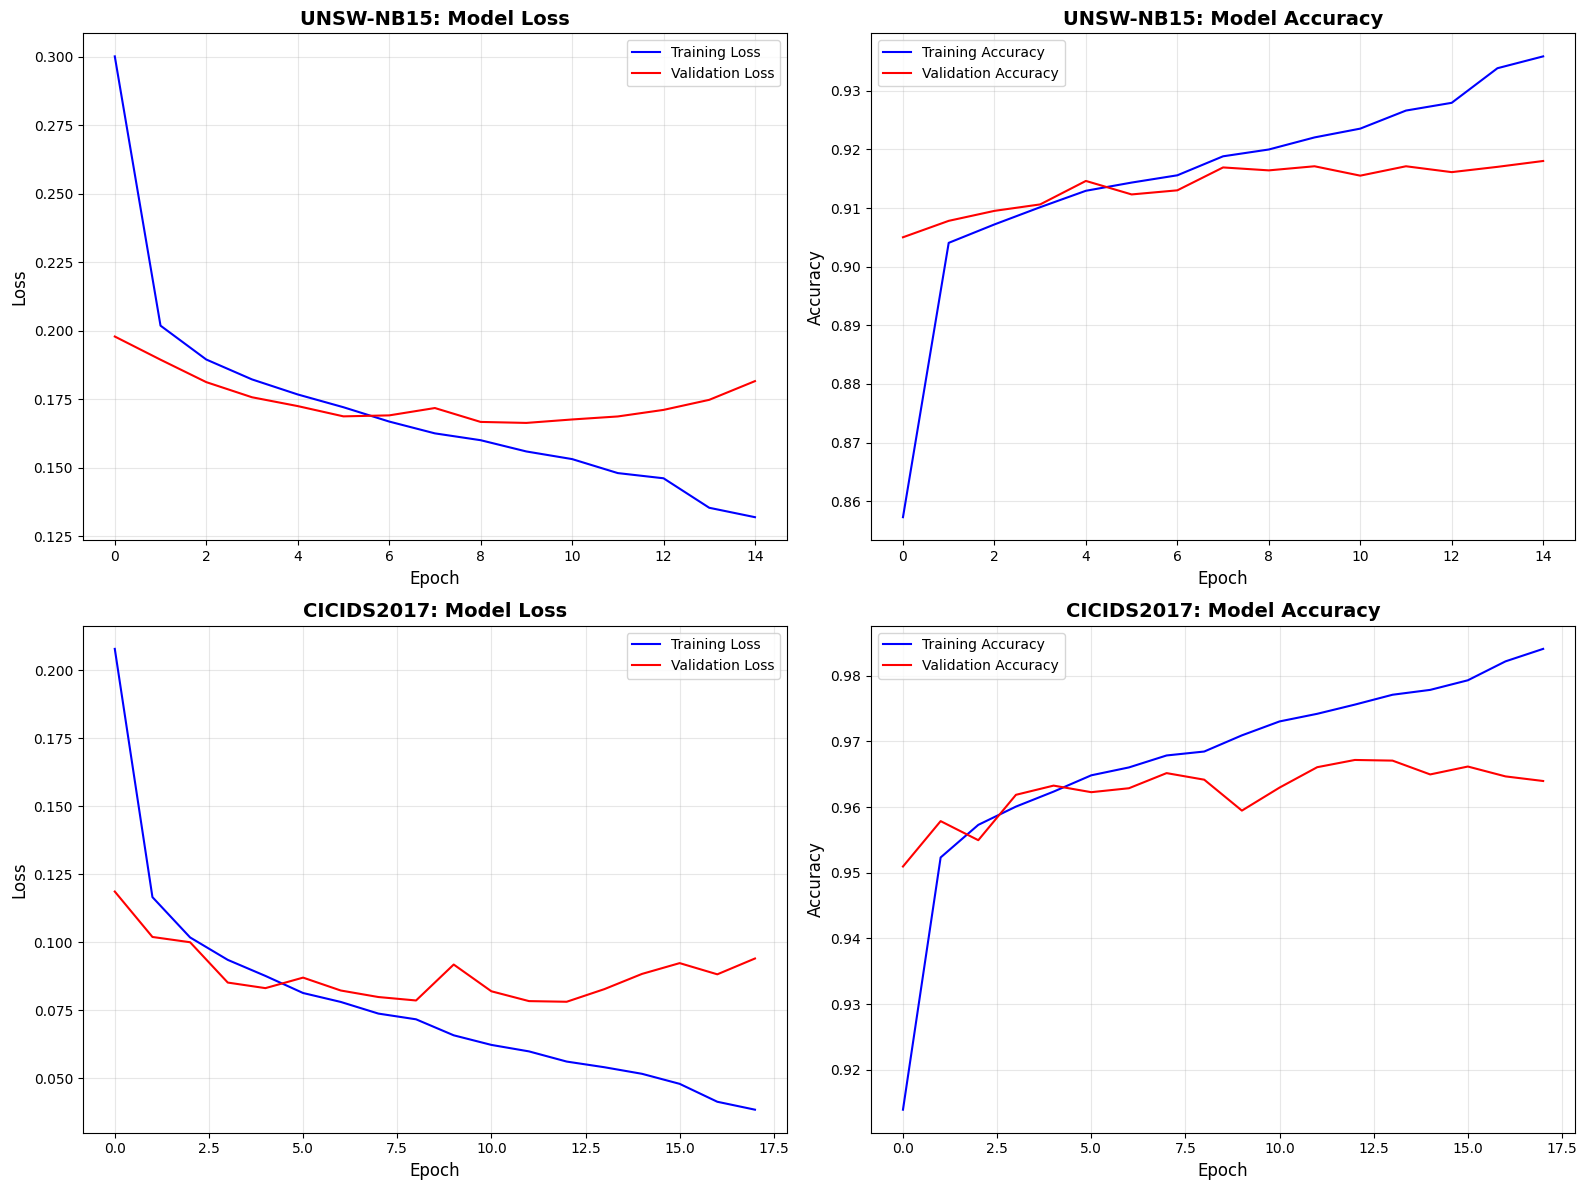

In [27]:
print("LSTM TRAINING HISTORY VISUALIZATION")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].plot(history_unsw.history['loss'], label='Training Loss', color='blue')
axes[0, 0].plot(history_unsw.history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('UNSW-NB15: Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_unsw.history['accuracy'], label='Training Accuracy', color='blue')
axes[0, 1].plot(history_unsw.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0, 1].set_title('UNSW-NB15: Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history_cicids.history['loss'], label='Training Loss', color='blue')
axes[1, 0].plot(history_cicids.history['val_loss'], label='Validation Loss', color='red')
axes[1, 0].set_title('CICIDS2017: Model Loss', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Loss', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_cicids.history['accuracy'], label='Training Accuracy', color='blue')
axes[1, 1].plot(history_cicids.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1, 1].set_title('CICIDS2017: Model Accuracy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: Model Architecture - Alert Clustering (DBSCAN)


DBSCAN CLUSTERING: UNSW-NB15

 Preparing data for clustering...
Clustering sample size: (5000, 42)

 Applying PCA for dimensionality reduction...
PCA explained variance ratio: 0.8148

 Running DBSCAN clustering...
Number of clusters found: 52
Number of noise points: 676
Cluster distribution:  2    1946
-1     676
 0     672
 3     455
 5     341
 1     124
 7     110
 8      85
 6      61
 4      39
Name: count, dtype: int64

 Visualizing clusters...


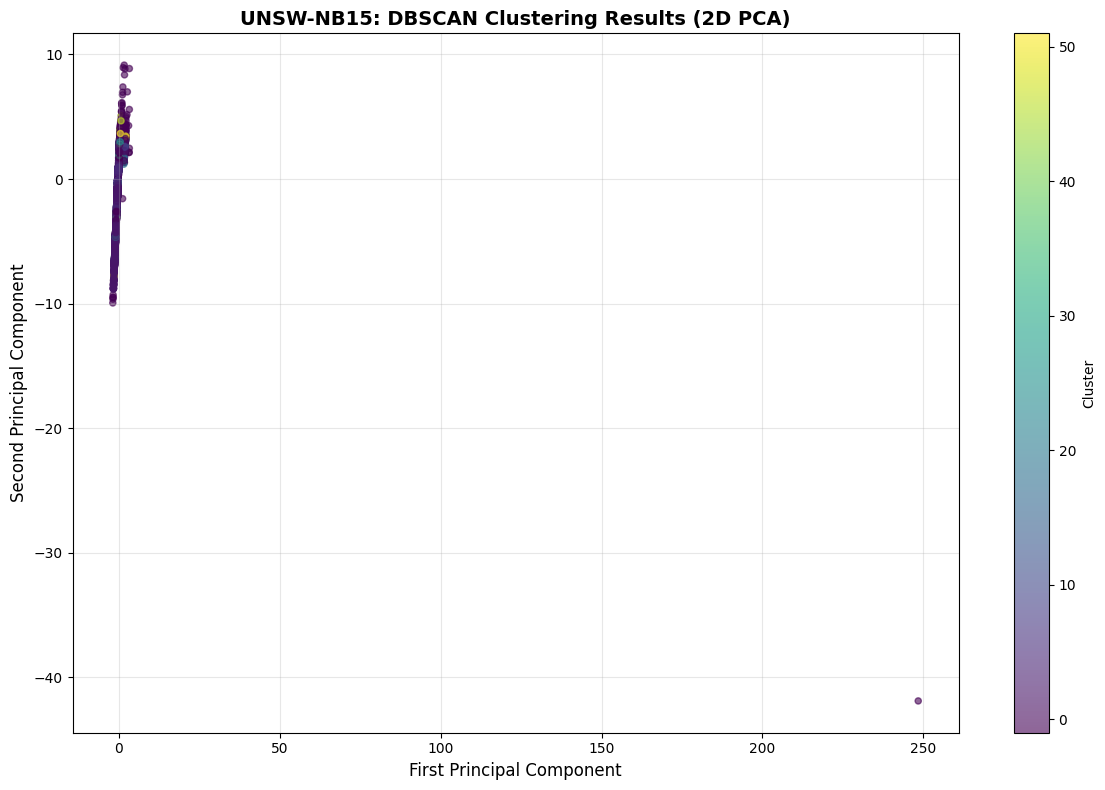

In [28]:
print("DBSCAN CLUSTERING: UNSW-NB15")

print("\n Preparing data for clustering...")
X_cluster_unsw = X_unsw_test.values[:5000]
print(f"Clustering sample size: {X_cluster_unsw.shape}")

print("\n Applying PCA for dimensionality reduction...")
pca_unsw = PCA(n_components=10)
X_cluster_unsw_pca = pca_unsw.fit_transform(X_cluster_unsw)
print(f"PCA explained variance ratio: {pca_unsw.explained_variance_ratio_.sum():.4f}")

print("\n Running DBSCAN clustering...")
dbscan_unsw = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
clusters_unsw = dbscan_unsw.fit_predict(X_cluster_unsw_pca)

n_clusters_unsw = len(set(clusters_unsw)) - (1 if -1 in clusters_unsw else 0)
n_noise_unsw = list(clusters_unsw).count(-1)
print(f"Number of clusters found: {n_clusters_unsw}")
print(f"Number of noise points: {n_noise_unsw}")
print(f"Cluster distribution: {pd.Series(clusters_unsw).value_counts().head(10)}")

print("\n Visualizing clusters...")
pca_2d_unsw = PCA(n_components=2)
X_cluster_unsw_2d = pca_2d_unsw.fit_transform(X_cluster_unsw)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_cluster_unsw_2d[:, 0], X_cluster_unsw_2d[:, 1],
                     c=clusters_unsw, cmap='viridis', alpha=0.6, s=20)
plt.colorbar(scatter, label='Cluster')
plt.title('UNSW-NB15: DBSCAN Clustering Results (2D PCA)', fontsize=14, fontweight='bold')
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

DBSCAN CLUSTERING: CICIDS2017

 Preparing data for clustering...
Clustering sample size: (5000, 78)

 Applying PCA for dimensionality reduction...
PCA explained variance ratio: 0.7623

 Running DBSCAN clustering...
Number of clusters found: 78
Number of noise points: 1016
Cluster distribution:  2     1566
-1     1016
 5      471
 4      364
 3      329
 25      96
 24      76
 23      60
 0       57
 45      52
Name: count, dtype: int64

 Visualizing clusters...


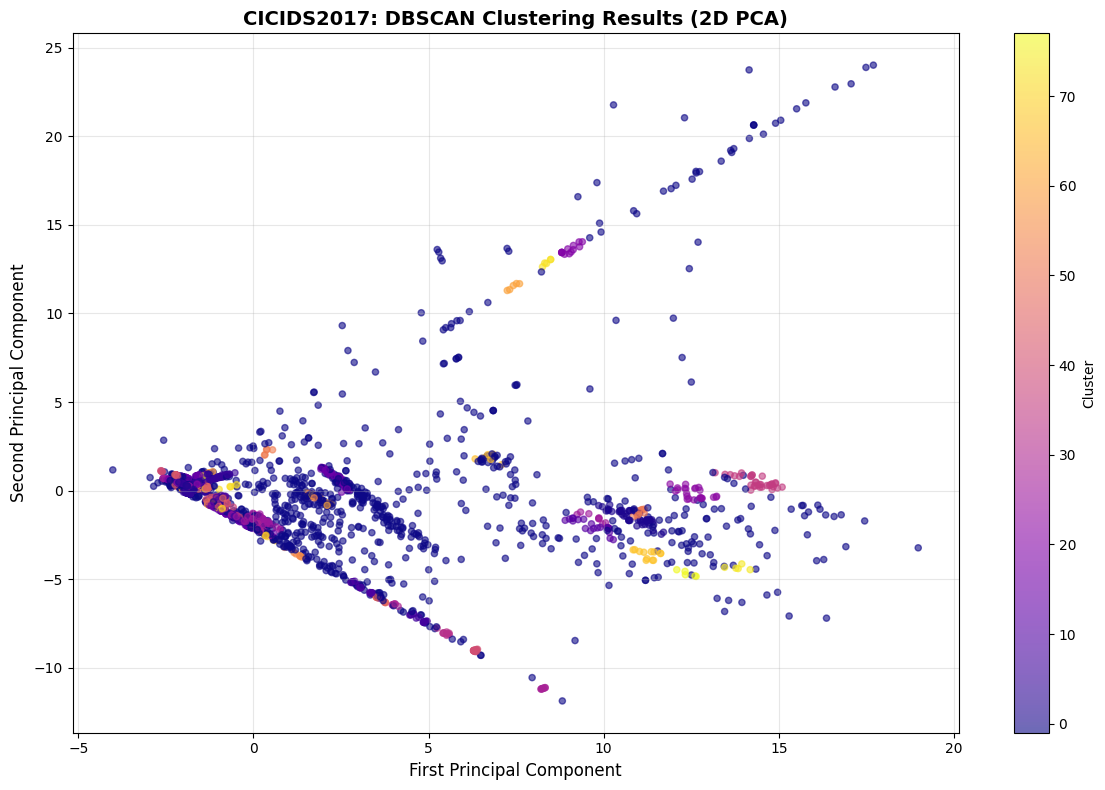

In [29]:
print("DBSCAN CLUSTERING: CICIDS2017")

print("\n Preparing data for clustering...")
X_cluster_cicids = X_cicids_test.values[:5000]
print(f"Clustering sample size: {X_cluster_cicids.shape}")

print("\n Applying PCA for dimensionality reduction...")
pca_cicids = PCA(n_components=10)
X_cluster_cicids_pca = pca_cicids.fit_transform(X_cluster_cicids)
print(f"PCA explained variance ratio: {pca_cicids.explained_variance_ratio_.sum():.4f}")

print("\n Running DBSCAN clustering...")
dbscan_cicids = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
clusters_cicids = dbscan_cicids.fit_predict(X_cluster_cicids_pca)

n_clusters_cicids = len(set(clusters_cicids)) - (1 if -1 in clusters_cicids else 0)
n_noise_cicids = list(clusters_cicids).count(-1)
print(f"Number of clusters found: {n_clusters_cicids}")
print(f"Number of noise points: {n_noise_cicids}")
print(f"Cluster distribution: {pd.Series(clusters_cicids).value_counts().head(10)}")

print("\n Visualizing clusters...")
pca_2d_cicids = PCA(n_components=2)
X_cluster_cicids_2d = pca_2d_cicids.fit_transform(X_cluster_cicids)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_cluster_cicids_2d[:, 0], X_cluster_cicids_2d[:, 1],
                     c=clusters_cicids, cmap='plasma', alpha=0.6, s=20)
plt.colorbar(scatter, label='Cluster')
plt.title('CICIDS2017: DBSCAN Clustering Results (2D PCA)', fontsize=14, fontweight='bold')
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 10: Unified Framework Integration


In [30]:
print("UNIFIED FRAMEWORK: Combining XGBoost, LSTM, and DBSCAN (WITH DYNAMIC WEIGHTS)")

# HUMAN LEARNING INTEGRATION: Dynamic weight system
# Weights can be adjusted based on analyst feedback
class DynamicWeightSystem:
    """
    Dynamic weight system that learns from analyst feedback.
    Implements the 'Human Learning Integration' from the proposal.
    """
    def __init__(self, initial_xgb_weight=0.5, initial_lstm_weight=0.3, initial_cluster_weight=0.2):
        self.weights = {
            'xgb': initial_xgb_weight,
            'lstm': initial_lstm_weight,
            'cluster': initial_cluster_weight
        }
        self.feedback_history = []
        self.weight_history = [self.weights.copy()]
        self.learning_rate = 0.1

    def get_weights(self):
        return (self.weights['xgb'], self.weights['lstm'], self.weights['cluster'])

    def update_weights_from_feedback(self, xgb_correct, lstm_correct, feedback_label):
        """
        Update weights based on analyst feedback.
        If XGBoost was correct and LSTM was wrong, increase XGBoost weight.
        """
        self.feedback_history.append({
            'xgb_correct': xgb_correct,
            'lstm_correct': lstm_correct,
            'label': feedback_label
        })

        # Adjust weights based on correctness
        if xgb_correct and not lstm_correct:
            self.weights['xgb'] = min(0.7, self.weights['xgb'] + self.learning_rate)
            self.weights['lstm'] = max(0.1, self.weights['lstm'] - self.learning_rate * 0.5)
        elif lstm_correct and not xgb_correct:
            self.weights['lstm'] = min(0.5, self.weights['lstm'] + self.learning_rate)
            self.weights['xgb'] = max(0.2, self.weights['xgb'] - self.learning_rate * 0.5)

        # Normalize weights
        total = sum(self.weights.values())
        for key in self.weights:
            self.weights[key] /= total

        self.weight_history.append(self.weights.copy())
        return self.weights

# Initialize dynamic weight system
dynamic_weights = DynamicWeightSystem()
print(f"Initial dynamic weights: XGBoost={dynamic_weights.weights['xgb']:.2f}, "
      f"LSTM={dynamic_weights.weights['lstm']:.2f}, Cluster={dynamic_weights.weights['cluster']:.2f}")

def calculate_priority_score(xgb_proba, lstm_proba, cluster_id, weights=None):
    """Calculate priority score with dynamic weights"""
    if weights is None:
        weights = dynamic_weights.get_weights()

    xgb_score = xgb_proba * 10
    lstm_score = lstm_proba * 10

    cluster_penalty = 0
    if cluster_id == -1:
        cluster_penalty = 2
    else:
        cluster_penalty = min(cluster_id * 0.5, 3)

    priority_score = (weights[0] * xgb_score +
                     weights[1] * lstm_score +
                     weights[2] * cluster_penalty)

    return min(max(priority_score, 0), 10)

print("\n Generating predictions from all models...")
print("UNSW-NB15:")
X_test_sample_unsw = X_unsw_test.values[:5000]
y_test_sample_unsw = y_unsw_test.values[:5000]

xgb_proba_unsw = xgb_unsw.predict_proba(X_test_sample_unsw)[:, 1]
lstm_input_unsw = []
for i in range(len(X_test_sample_unsw) - sequence_length + 1):
    lstm_input_unsw.append(X_test_sample_unsw[i:i+sequence_length])
lstm_input_unsw = np.array(lstm_input_unsw)
lstm_proba_unsw = lstm_unsw.predict(lstm_input_unsw, verbose=0).flatten()
lstm_proba_unsw = np.pad(lstm_proba_unsw, (sequence_length-1, 0), mode='edge')[:len(X_test_sample_unsw)]

clusters_sample_unsw = dbscan_unsw.fit_predict(pca_unsw.transform(X_test_sample_unsw))

print(f"XGBoost predictions: {len(xgb_proba_unsw)}")
print(f"LSTM predictions: {len(lstm_proba_unsw)}")
print(f"Cluster assignments: {len(clusters_sample_unsw)}")

print("\n Calculating unified priority scores...")
priority_scores_unsw = []
for i in range(len(X_test_sample_unsw)):
    score = calculate_priority_score(
        xgb_proba_unsw[i],
        lstm_proba_unsw[i],
        clusters_sample_unsw[i]
    )
    priority_scores_unsw.append(score)

priority_scores_unsw = np.array(priority_scores_unsw)
print(f"Priority scores calculated: min={priority_scores_unsw.min():.2f}, "
      f"max={priority_scores_unsw.max():.2f}, mean={priority_scores_unsw.mean():.2f}")

print("\n Creating priority-based alert queue...")
alert_queue_unsw = pd.DataFrame({
    'index': range(len(X_test_sample_unsw)),
    'priority_score': priority_scores_unsw,
    'xgb_proba': xgb_proba_unsw,
    'lstm_proba': lstm_proba_unsw,
    'cluster_id': clusters_sample_unsw,
    'true_label': y_test_sample_unsw
})
alert_queue_unsw = alert_queue_unsw.sort_values('priority_score', ascending=False)
print(f"\nTop 10 highest priority alerts:")
print(alert_queue_unsw.head(10)[['priority_score', 'xgb_proba', 'lstm_proba', 'cluster_id', 'true_label']])

UNIFIED FRAMEWORK: Combining XGBoost, LSTM, and DBSCAN (WITH DYNAMIC WEIGHTS)
Initial dynamic weights: XGBoost=0.50, LSTM=0.30, Cluster=0.20

 Generating predictions from all models...
UNSW-NB15:
XGBoost predictions: 5000
LSTM predictions: 5000
Cluster assignments: 5000

 Calculating unified priority scores...
Priority scores calculated: min=0.30, max=8.60, mean=5.16

 Creating priority-based alert queue...

Top 10 highest priority alerts:
      priority_score  xgb_proba  lstm_proba  cluster_id  true_label
2559        8.598734   0.999753    0.999989          48           1
1204        8.598725   0.999753    0.999987          48           1
4080        8.598440   0.999697    0.999985          25           1
3661        8.598392   0.999701    0.999962          25           1
358         8.598369   0.999701    0.999954          25           1
2513        8.598368   0.999687    0.999977          25           1
2047        8.598311   0.999669    0.999988          25           1
3913        

In [31]:
print("UNIFIED FRAMEWORK: CICIDS2017")

print("\n Generating predictions from all models...")
X_test_sample_cicids = X_cicids_test.values[:5000]
y_test_sample_cicids = y_cicids_test.values[:5000]

xgb_proba_cicids = xgb_cicids.predict_proba(X_test_sample_cicids)[:, 1]
lstm_input_cicids = []
for i in range(len(X_test_sample_cicids) - sequence_length + 1):
    lstm_input_cicids.append(X_test_sample_cicids[i:i+sequence_length])
lstm_input_cicids = np.array(lstm_input_cicids)
lstm_proba_cicids = lstm_cicids.predict(lstm_input_cicids, verbose=0).flatten()
lstm_proba_cicids = np.pad(lstm_proba_cicids, (sequence_length-1, 0), mode='edge')[:len(X_test_sample_cicids)]

clusters_sample_cicids = dbscan_cicids.fit_predict(pca_cicids.transform(X_test_sample_cicids))

print(f"XGBoost predictions: {len(xgb_proba_cicids)}")
print(f"LSTM predictions: {len(lstm_proba_cicids)}")
print(f"Cluster assignments: {len(clusters_sample_cicids)}")

print("\n Calculating unified priority scores...")
priority_scores_cicids = []
for i in range(len(X_test_sample_cicids)):
    score = calculate_priority_score(
        xgb_proba_cicids[i],
        lstm_proba_cicids[i],
        clusters_sample_cicids[i]
    )
    priority_scores_cicids.append(score)

priority_scores_cicids = np.array(priority_scores_cicids)
print(f"Priority scores calculated: min={priority_scores_cicids.min():.2f}, "
      f"max={priority_scores_cicids.max():.2f}, mean={priority_scores_cicids.mean():.2f}")

print("\n Creating priority-based alert queue...")
alert_queue_cicids = pd.DataFrame({
    'index': range(len(X_test_sample_cicids)),
    'priority_score': priority_scores_cicids,
    'xgb_proba': xgb_proba_cicids,
    'lstm_proba': lstm_proba_cicids,
    'cluster_id': clusters_sample_cicids,
    'true_label': y_test_sample_cicids
})
alert_queue_cicids = alert_queue_cicids.sort_values('priority_score', ascending=False)
print(f"\nTop 10 highest priority alerts:")
print(alert_queue_cicids.head(10)[['priority_score', 'xgb_proba', 'lstm_proba', 'cluster_id', 'true_label']])

UNIFIED FRAMEWORK: CICIDS2017

 Generating predictions from all models...
XGBoost predictions: 5000
LSTM predictions: 5000
Cluster assignments: 5000

 Calculating unified priority scores...
Priority scores calculated: min=0.00, max=8.60, mean=1.93

 Creating priority-based alert queue...

Top 10 highest priority alerts:
      priority_score  xgb_proba  lstm_proba  cluster_id  true_label
3130        8.599670   0.999940    0.999989          35           1
4114        8.599669   0.999940    0.999989          35           1
552         8.599668   0.999940    0.999989          35           1
114         8.599667   0.999940    0.999988          22           1
1403        8.599653   0.999940    0.999984          22           1
3913        8.599652   0.999940    0.999983          35           1
437         8.599651   0.999940    0.999983          35           1
4917        8.599651   0.999938    0.999988          35           1
1576        8.599650   0.999938    0.999987          35           

## Step 10.1: Human Learning Integration

This section implements the "Human Learning Integration" promised in the proposal:
- **Feedback Mechanism**: Uncertain decisions are deferred to analysts
- **Dynamic Weight Adjustment**: System weights are updated based on analyst feedback
- **Incremental Learning**: XGBoost model is retrained with feedback data


HUMAN LEARNING INTEGRATION: Feedback Mechanism & Incremental Learning

 FEEDBACK MECHANISM - Deferring Uncertain Predictions
Total predictions: 5000
Uncertain predictions (deferred to analysts): 897 (17.94%)
Confident predictions (automated): 4103 (82.06%)

 SIMULATED ANALYST FEEDBACK
Simulating analyst review of 897 uncertain alerts...
Feedback distribution: Normal=422, Attack=475

 DYNAMIC WEIGHT ADJUSTMENT Based on Feedback
XGBoost accuracy on uncertain cases: 0.7202
LSTM accuracy on uncertain cases: 0.5753

Weights BEFORE feedback:
  XGBoost: 0.5000
  LSTM: 0.3000
  Cluster: 0.2000

Weights AFTER feedback (10 updates):
  XGBoost: 0.7063
  LSTM: 0.1009
  Cluster: 0.1928

 INCREMENTAL LEARNING - Retrain Model with Feedback
Feedback data shape: (897, 42)

Retraining XGBoost with feedback data (incremental learning)...
Incremental training completed in 1.29 seconds

Performance comparison:
                     BEFORE      AFTER       CHANGE
  Precision:         0.9798      0.9797     -

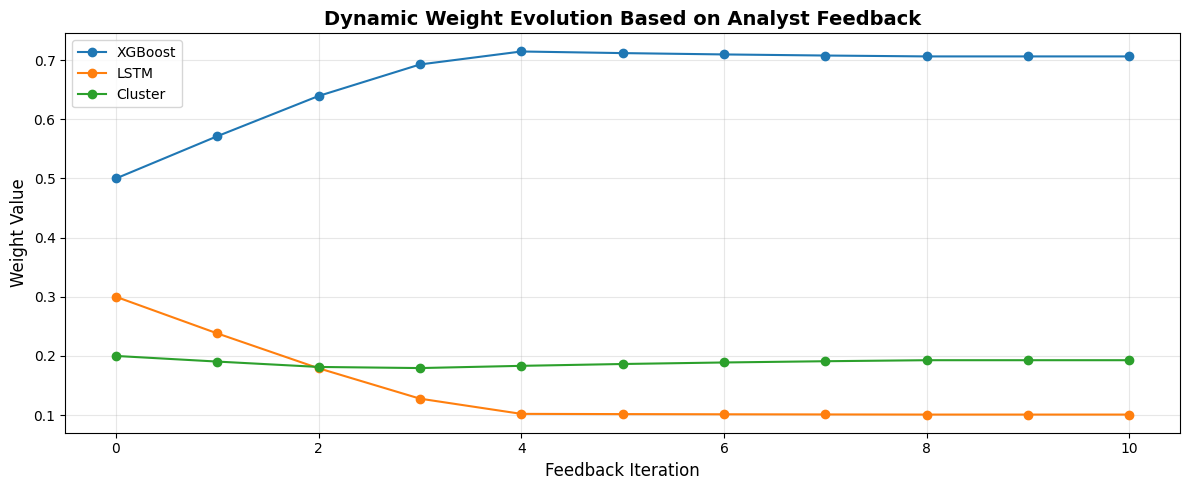

HUMAN LEARNING INTEGRATION COMPLETE


In [32]:
print("HUMAN LEARNING INTEGRATION: Feedback Mechanism & Incremental Learning")

# FEEDBACK MECHANISM: Defer uncertain predictions to analysts
print("\n FEEDBACK MECHANISM - Deferring Uncertain Predictions")

UNCERTAINTY_THRESHOLD = 0.3  # Predictions within 0.5 ± threshold are uncertain

def identify_uncertain_predictions(xgb_probas, lstm_probas, threshold=UNCERTAINTY_THRESHOLD):
    """Identify predictions that should be deferred to analysts"""
    # Combined probability
    combined_proba = 0.5 * xgb_probas + 0.5 * lstm_probas

    # Uncertain if probability is close to 0.5 (decision boundary)
    uncertain_mask = np.abs(combined_proba - 0.5) < threshold

    # Also uncertain if XGBoost and LSTM disagree significantly
    disagreement = np.abs(xgb_probas - lstm_probas)
    disagreement_mask = disagreement > 0.4

    return uncertain_mask | disagreement_mask

# Apply to UNSW-NB15 test data
uncertain_mask_unsw = identify_uncertain_predictions(xgb_proba_unsw, lstm_proba_unsw)
n_uncertain = uncertain_mask_unsw.sum()
n_total = len(uncertain_mask_unsw)

print(f"Total predictions: {n_total}")
print(f"Uncertain predictions (deferred to analysts): {n_uncertain} ({n_uncertain/n_total*100:.2f}%)")
print(f"Confident predictions (automated): {n_total - n_uncertain} ({(n_total - n_uncertain)/n_total*100:.2f}%)")

# SIMULATED ANALYST FEEDBACK
print("\n SIMULATED ANALYST FEEDBACK")

# Simulate analyst feedback (in reality, this would come from the dashboard)
# We use the true labels as "perfect analyst feedback" for simulation
uncertain_indices = np.where(uncertain_mask_unsw)[0]
simulated_feedback = y_test_sample_unsw[uncertain_indices]

print(f"Simulating analyst review of {len(uncertain_indices)} uncertain alerts...")
print(f"Feedback distribution: Normal={sum(simulated_feedback==0)}, Attack={sum(simulated_feedback==1)}")

# DYNAMIC WEIGHT ADJUSTMENT
print("\n DYNAMIC WEIGHT ADJUSTMENT Based on Feedback")

# Calculate which model was correct for uncertain predictions
xgb_predictions_uncertain = (xgb_proba_unsw[uncertain_indices] > 0.5).astype(int)
lstm_predictions_uncertain = (lstm_proba_unsw[uncertain_indices] > 0.5).astype(int)

xgb_correct = (xgb_predictions_uncertain == simulated_feedback).mean()
lstm_correct = (lstm_predictions_uncertain == simulated_feedback).mean()

print(f"XGBoost accuracy on uncertain cases: {xgb_correct:.4f}")
print(f"LSTM accuracy on uncertain cases: {lstm_correct:.4f}")

# Update weights based on performance
print(f"\nWeights BEFORE feedback:")
print(f"  XGBoost: {dynamic_weights.weights['xgb']:.4f}")
print(f"  LSTM: {dynamic_weights.weights['lstm']:.4f}")
print(f"  Cluster: {dynamic_weights.weights['cluster']:.4f}")

# Simulate multiple feedback updates
for i in range(min(10, len(uncertain_indices))):
    idx = uncertain_indices[i]
    xgb_was_correct = (xgb_proba_unsw[idx] > 0.5) == simulated_feedback[i]
    lstm_was_correct = (lstm_proba_unsw[idx] > 0.5) == simulated_feedback[i]
    dynamic_weights.update_weights_from_feedback(xgb_was_correct, lstm_was_correct, simulated_feedback[i])

print(f"\nWeights AFTER feedback (10 updates):")
print(f"  XGBoost: {dynamic_weights.weights['xgb']:.4f}")
print(f"  LSTM: {dynamic_weights.weights['lstm']:.4f}")
print(f"  Cluster: {dynamic_weights.weights['cluster']:.4f}")

# INCREMENTAL LEARNING - Retrain XGBoost with feedback
print("\n INCREMENTAL LEARNING - Retrain Model with Feedback")

# Prepare feedback data for incremental learning
X_feedback = X_test_sample_unsw[uncertain_indices]
y_feedback = simulated_feedback

print(f"Feedback data shape: {X_feedback.shape}")

# Retrain XGBoost incrementally (add feedback data to training)
print("\nRetraining XGBoost with feedback data (incremental learning)...")
X_combined = np.vstack([X_unsw_train.values, X_feedback])
y_combined = np.concatenate([y_unsw_train.values, y_feedback])

# Create new model with same parameters
xgb_unsw_updated = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_unsw,
    use_label_encoder=False
)

start_time = time.time()
xgb_unsw_updated.fit(X_combined, y_combined, verbose=False)
training_time = time.time() - start_time

# Evaluate updated model
y_pred_updated = xgb_unsw_updated.predict(X_unsw_test)
accuracy_updated = accuracy_score(y_unsw_test, y_pred_updated)
precision_updated = precision_score(y_unsw_test, y_pred_updated)
recall_updated = recall_score(y_unsw_test, y_pred_updated)
f1_updated = f1_score(y_unsw_test, y_pred_updated)

print(f"Incremental training completed in {training_time:.2f} seconds")
print(f"\nPerformance comparison:")
print(f"                     BEFORE      AFTER       CHANGE")
print(f"  Precision:         {precision_unsw:.4f}      {precision_updated:.4f}     {(precision_updated-precision_unsw)*100:+.2f}%")
print(f"  Recall:            {recall_unsw:.4f}      {recall_updated:.4f}     {(recall_updated-recall_unsw)*100:+.2f}%")
print(f"  F1-Score:          {f1_unsw:.4f}      {f1_updated:.4f}     {(f1_updated-f1_unsw)*100:+.2f}%")
print(f"  Accuracy:          {accuracy_unsw:.4f}      {accuracy_updated:.4f}     {(accuracy_updated-accuracy_unsw)*100:+.2f}%")

# Visualize weight evolution
plt.figure(figsize=(12, 5))
weight_df = pd.DataFrame(dynamic_weights.weight_history)
weight_df.plot(marker='o', ax=plt.gca())
plt.title('Dynamic Weight Evolution Based on Analyst Feedback', fontsize=14, fontweight='bold')
plt.xlabel('Feedback Iteration', fontsize=12)
plt.ylabel('Weight Value', fontsize=12)
plt.legend(['XGBoost', 'LSTM', 'Cluster'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("HUMAN LEARNING INTEGRATION COMPLETE")

## Step 10.2: Interactive Dashboard

This section implements the "Interactive Dashboard" promised in the proposal:
- **Web-based Interface**: Using Dash/Plotly for real-time interaction
- **Filter & Explore**: Analysts can filter alerts by priority, type, and time
- **Feedback Interface**: Submit feedback on predictions directly


In [33]:

print("SOC ALERT PRIORITIZATION DASHBOARD")

# Install Gradio if not already installed (works in Colab)
import subprocess
import sys
try:
    import gradio as gr
    print(" Gradio already installed")
except ImportError:
    print(" Installing Gradio for interactive dashboard...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gradio", "-q"])
    import gradio as gr
    print(" Gradio installed successfully")

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Use existing alert_queue_unsw data or create sample data
try:
    alert_queue = alert_queue_unsw.copy()
    print(" Using existing alert_queue_unsw data")
except NameError:
    print(" Creating sample data for demonstration...")
    np.random.seed(42)
    n_samples = 1000
    alert_queue = pd.DataFrame({
        'index': range(n_samples),
        'priority_score': np.random.uniform(0, 10, n_samples),
        'xgb_proba': np.random.uniform(0, 1, n_samples),
        'lstm_proba': np.random.uniform(0, 1, n_samples),
        'cluster_id': np.random.randint(-1, 10, n_samples),
        'true_label': np.random.randint(0, 2, n_samples)
    })

# Add priority category
alert_queue['priority_category'] = alert_queue['priority_score'].apply(
    lambda x: 'High' if x >= 6 else ('Medium' if x >= 3 else 'Low')
)

# Calculate stats
total_alerts = len(alert_queue)
high_priority = len(alert_queue[alert_queue['priority_category'] == 'High'])
medium_priority = len(alert_queue[alert_queue['priority_category'] == 'Medium'])
low_priority = len(alert_queue[alert_queue['priority_category'] == 'Low'])

print(f"\n Alert Summary:")
print(f"   Total Alerts: {total_alerts}")
print(f"   🔴 High Priority: {high_priority}")
print(f"   🟡 Medium Priority: {medium_priority}")
print(f"   🟢 Low Priority: {low_priority}")

# =============================================================================
# Dashboard Functions
# =============================================================================

def create_priority_pie(filtered_df):
    """Create priority distribution pie chart"""
    priority_counts = filtered_df['priority_category'].value_counts()
    colors = {'High': '#e74c3c', 'Medium': '#f39c12', 'Low': '#27ae60'}

    fig = go.Figure(data=[go.Pie(
        labels=priority_counts.index,
        values=priority_counts.values,
        marker_colors=[colors.get(cat, '#95a5a6') for cat in priority_counts.index],
        hole=0.4,
        textinfo='label+percent',
        textfont_size=12
    )])

    fig.update_layout(
        title=dict(text=' Priority Distribution', font=dict(size=16)),
        height=400,
        showlegend=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    return fig

def create_score_histogram(filtered_df):
    """Create priority score histogram"""
    fig = go.Figure(data=[go.Histogram(
        x=filtered_df['priority_score'],
        nbinsx=20,
        marker_color='#3498db',
        opacity=0.8
    )])

    fig.update_layout(
        title=dict(text=' Priority Score Distribution', font=dict(size=16)),
        xaxis_title='Priority Score',
        yaxis_title='Count',
        height=400,
        bargap=0.1,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig.update_xaxes(gridcolor='lightgray')
    fig.update_yaxes(gridcolor='lightgray')
    return fig

def create_model_scatter(filtered_df):
    """Create XGBoost vs LSTM scatter plot"""
    colors = {'High': '#e74c3c', 'Medium': '#f39c12', 'Low': '#27ae60'}

    fig = px.scatter(
        filtered_df,
        x='xgb_proba',
        y='lstm_proba',
        color='priority_category',
        color_discrete_map=colors,
        hover_data=['priority_score', 'cluster_id'],
        opacity=0.6
    )

    fig.update_layout(
        title=dict(text=' XGBoost vs LSTM Predictions', font=dict(size=16)),
        xaxis_title='XGBoost Probability',
        yaxis_title='LSTM Probability',
        height=400,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig.update_xaxes(gridcolor='lightgray')
    fig.update_yaxes(gridcolor='lightgray')
    return fig

def create_workload_bar(filtered_df):
    """Create workload analysis bar chart"""
    high = len(filtered_df[filtered_df['priority_score'] >= 6])
    medium = len(filtered_df[(filtered_df['priority_score'] >= 3) & (filtered_df['priority_score'] < 6)])
    low = len(filtered_df[filtered_df['priority_score'] < 3])

    fig = go.Figure(data=[go.Bar(
        x=['🔴 High<br>(Immediate)', '🟡 Medium<br>(Review)', '🟢 Low<br>(Automated)'],
        y=[high, medium, low],
        marker_color=['#e74c3c', '#f39c12', '#27ae60'],
        text=[high, medium, low],
        textposition='auto'
    )])

    fig.update_layout(
        title=dict(text='📋 Alert Workload Analysis', font=dict(size=16)),
        xaxis_title='Priority Level',
        yaxis_title='Number of Alerts',
        height=400,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
    fig.update_yaxes(gridcolor='lightgray')
    return fig

def filter_and_display(priority_filter, min_score, max_score):
    """Filter data and update all visualizations"""
    filtered_df = alert_queue.copy()

    # Apply priority filter
    if priority_filter != "All":
        filtered_df = filtered_df[filtered_df['priority_category'] == priority_filter]

    # Apply score range filter
    filtered_df = filtered_df[
        (filtered_df['priority_score'] >= min_score) &
        (filtered_df['priority_score'] <= max_score)
    ]

    # Generate all charts
    pie_fig = create_priority_pie(filtered_df)
    hist_fig = create_score_histogram(filtered_df)
    scatter_fig = create_model_scatter(filtered_df)
    bar_fig = create_workload_bar(filtered_df)

    # Create summary stats HTML
    stats_html = f"""
    <div style="display: flex; justify-content: space-around; flex-wrap: wrap; gap: 10px; margin: 10px 0;">
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 20px 30px; border-radius: 12px; text-align: center; min-width: 120px; box-shadow: 0 4px 15px rgba(102, 126, 234, 0.4);">
            <div style="font-size: 28px; font-weight: bold; color: white;">{len(filtered_df)}</div>
            <div style="color: rgba(255,255,255,0.9); font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">Total Alerts</div>
        </div>
        <div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); padding: 20px 30px; border-radius: 12px; text-align: center; min-width: 120px; box-shadow: 0 4px 15px rgba(245, 87, 108, 0.4);">
            <div style="font-size: 28px; font-weight: bold; color: white;">{len(filtered_df[filtered_df['priority_category']=='High'])}</div>
            <div style="color: rgba(255,255,255,0.9); font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">🔴 High Priority</div>
        </div>
        <div style="background: linear-gradient(135deg, #f6d365 0%, #fda085 100%); padding: 20px 30px; border-radius: 12px; text-align: center; min-width: 120px; box-shadow: 0 4px 15px rgba(253, 160, 133, 0.4);">
            <div style="font-size: 28px; font-weight: bold; color: white;">{len(filtered_df[filtered_df['priority_category']=='Medium'])}</div>
            <div style="color: rgba(255,255,255,0.9); font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">🟡 Medium Priority</div>
        </div>
        <div style="background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%); padding: 20px 30px; border-radius: 12px; text-align: center; min-width: 120px; box-shadow: 0 4px 15px rgba(56, 239, 125, 0.4);">
            <div style="font-size: 28px; font-weight: bold; color: white;">{len(filtered_df[filtered_df['priority_category']=='Low'])}</div>
            <div style="color: rgba(255,255,255,0.9); font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">🟢 Low Priority</div>
        </div>
    </div>
    """

    # Create alert table (top 20 by priority)
    top_alerts = filtered_df.nlargest(20, 'priority_score')[
        ['index', 'priority_score', 'xgb_proba', 'lstm_proba', 'cluster_id', 'priority_category']
    ].copy()
    top_alerts.columns = ['Alert ID', 'Priority Score', 'XGBoost Prob', 'LSTM Prob', 'Cluster', 'Priority']
    top_alerts['Priority Score'] = top_alerts['Priority Score'].round(2)
    top_alerts['XGBoost Prob'] = top_alerts['XGBoost Prob'].round(3)
    top_alerts['LSTM Prob'] = top_alerts['LSTM Prob'].round(3)

    return stats_html, pie_fig, hist_fig, scatter_fig, bar_fig, top_alerts

def submit_feedback(alert_id, assessment):
    """Handle analyst feedback submission"""
    if alert_id and assessment:
        return f"✅ Feedback recorded for Alert {int(alert_id)}: {assessment}. Model will be updated with this feedback."
    return "⚠️ Please enter both Alert ID and Assessment"

# =============================================================================
# Build Gradio Interface
# =============================================================================

with gr.Blocks(title="SOC Alert Dashboard", theme=gr.themes.Soft()) as dashboard:

    # Header
    gr.HTML("""
    <div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 50%, #0f3460 100%);
                padding: 30px; border-radius: 15px; margin-bottom: 20px; text-align: center;
                box-shadow: 0 10px 40px rgba(0,0,0,0.3);">
        <h1 style="color: #e94560; margin: 0; font-size: 2.5em; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">
             SOC Alert Prioritization Dashboard
        </h1>
        <p style="color: #a6a6a6; margin-top: 10px; font-size: 1.1em;">
            AI-Driven Alert Fatigue Reduction Framework | Real-time Analysis & Visualization
        </p>
    </div>
    """)

    # Stats display
    stats_output = gr.HTML()

    # Filters
    with gr.Row():
        with gr.Column(scale=1):
            priority_dropdown = gr.Dropdown(
                choices=["All", "High", "Medium", "Low"],
                value="All",
                label=" Priority Filter"
            )
        with gr.Column(scale=1):
            min_score = gr.Slider(0, 10, value=0, step=0.5, label=" Min Priority Score")
        with gr.Column(scale=1):
            max_score = gr.Slider(0, 10, value=10, step=0.5, label=" Max Priority Score")
        with gr.Column(scale=1):
            filter_btn = gr.Button(" Apply Filters", variant="primary")

    # Charts row 1
    with gr.Row():
        pie_chart = gr.Plot(label="Priority Distribution")
        hist_chart = gr.Plot(label="Score Distribution")

    # Charts row 2
    with gr.Row():
        scatter_chart = gr.Plot(label="Model Predictions")
        bar_chart = gr.Plot(label="Workload Analysis")

    # Alert Table
    gr.HTML("<h3 style='margin-top: 20px; color: #2c3e50;'> Top Priority Alerts</h3>")
    alert_table = gr.Dataframe(
        headers=['Alert ID', 'Priority Score', 'XGBoost Prob', 'LSTM Prob', 'Cluster', 'Priority'],
        interactive=False
    )

    # Feedback Section
    gr.HTML("""
    <div style="background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
                padding: 20px; border-radius: 10px; margin-top: 20px;">
        <h3 style="color: #2c3e50; margin-top: 0;"> Submit Analyst Feedback</h3>
        <p style="color: #7f8c8d; font-size: 0.9em;">
            Your feedback helps improve the model's accuracy over time.
        </p>
    </div>
    """)

    with gr.Row():
        feedback_alert_id = gr.Number(label="Alert ID", precision=0)
        feedback_assessment = gr.Dropdown(
            choices=[
                "True Positive (Real Attack)",
                "False Positive (False Alarm)",
                "True Negative (Correctly Normal)",
                "False Negative (Missed Attack)"
            ],
            label="Your Assessment"
        )
        feedback_btn = gr.Button("Submit Feedback", variant="secondary")

    feedback_output = gr.Textbox(label="Feedback Status", interactive=False)

    # Wire up the interactions
    filter_btn.click(
        fn=filter_and_display,
        inputs=[priority_dropdown, min_score, max_score],
        outputs=[stats_output, pie_chart, hist_chart, scatter_chart, bar_chart, alert_table]
    )

    # Auto-update on dropdown/slider changes
    priority_dropdown.change(
        fn=filter_and_display,
        inputs=[priority_dropdown, min_score, max_score],
        outputs=[stats_output, pie_chart, hist_chart, scatter_chart, bar_chart, alert_table]
    )

    min_score.change(
        fn=filter_and_display,
        inputs=[priority_dropdown, min_score, max_score],
        outputs=[stats_output, pie_chart, hist_chart, scatter_chart, bar_chart, alert_table]
    )

    max_score.change(
        fn=filter_and_display,
        inputs=[priority_dropdown, min_score, max_score],
        outputs=[stats_output, pie_chart, hist_chart, scatter_chart, bar_chart, alert_table]
    )

    feedback_btn.click(
        fn=submit_feedback,
        inputs=[feedback_alert_id, feedback_assessment],
        outputs=feedback_output
    )

    # Load initial data on startup
    dashboard.load(
        fn=filter_and_display,
        inputs=[priority_dropdown, min_score, max_score],
        outputs=[stats_output, pie_chart, hist_chart, scatter_chart, bar_chart, alert_table]
    )

# Launch the dashboard (inline=True for Colab, share=True for public URL)
print("LAUNCHING INTERACTIVE DASHBOARD")

# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab - Dashboard will appear below")
    dashboard.launch(inline=True, share=True, debug=False)
else:
    print("Running locally - Dashboard will appear below")
    dashboard.launch(inline=True, debug=False)

print("\nDashboard launched successfully!")

SOC ALERT PRIORITIZATION DASHBOARD
 Gradio already installed
 Using existing alert_queue_unsw data

 Alert Summary:
   Total Alerts: 5000
   🔴 High Priority: 2752
   🟡 Medium Priority: 450
   🟢 Low Priority: 1798
LAUNCHING INTERACTIVE DASHBOARD
Running in Google Colab - Dashboard will appear below
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e52d64fdb50b26650d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



Dashboard launched successfully!


## Step 11: Explainability Layer (SHAP)


SHAP EXPLAINABILITY: UNSW-NB15

 Creating SHAP explainer...
SHAP explainer created successfully

 Computing SHAP values for sample predictions...
SHAP values computed for 100 samples

 Visualizing SHAP summary...


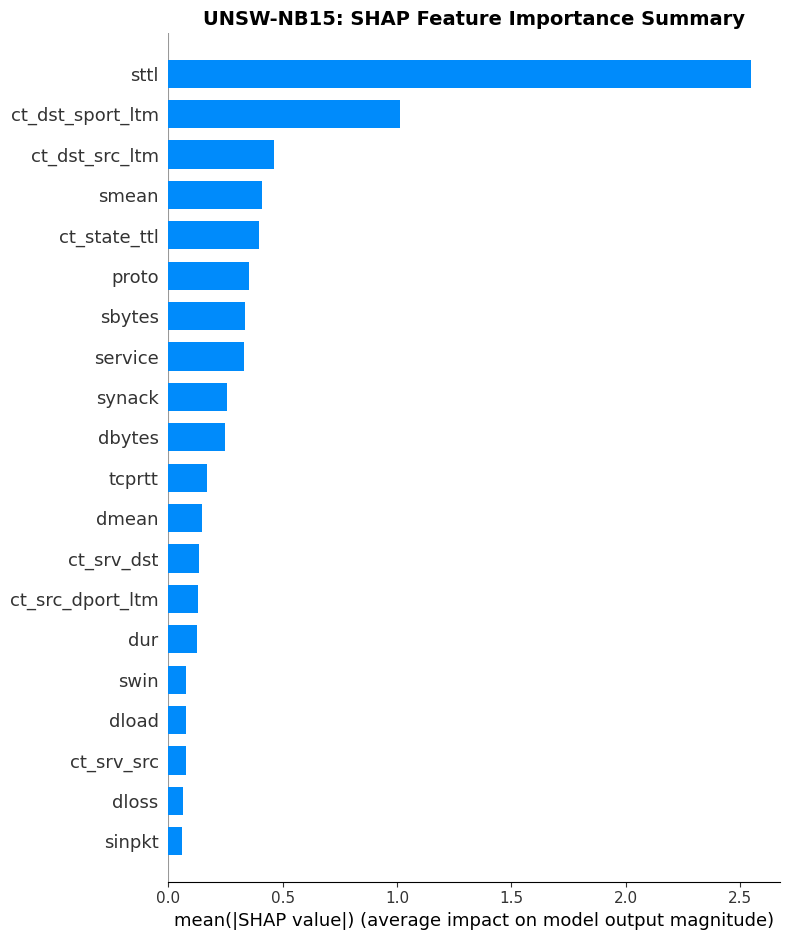


Top 5 alerts with highest priority scores:

Alert 2559:
  Priority Score: 8.60/10
  XGBoost Probability: 0.9998
  LSTM Probability: 1.0000
  Cluster ID: 48.0
  True Label: Attack

Alert 1204:
  Priority Score: 8.60/10
  XGBoost Probability: 0.9998
  LSTM Probability: 1.0000
  Cluster ID: 48.0
  True Label: Attack

Alert 4080:
  Priority Score: 8.60/10
  XGBoost Probability: 0.9997
  LSTM Probability: 1.0000
  Cluster ID: 25.0
  True Label: Attack

Alert 3661:
  Priority Score: 8.60/10
  XGBoost Probability: 0.9997
  LSTM Probability: 1.0000
  Cluster ID: 25.0
  True Label: Attack

Alert 358:
  Priority Score: 8.60/10
  XGBoost Probability: 0.9997
  LSTM Probability: 1.0000
  Cluster ID: 25.0
  True Label: Attack


In [34]:
print("SHAP EXPLAINABILITY: UNSW-NB15")

print("\n Creating SHAP explainer...")
explainer_unsw = shap.TreeExplainer(xgb_unsw)
print("SHAP explainer created successfully")

print("\n Computing SHAP values for sample predictions...")
sample_size = min(100, len(X_unsw_test))
X_sample_unsw = X_unsw_test.iloc[:sample_size]
shap_values_unsw = explainer_unsw.shap_values(X_sample_unsw)
print(f"SHAP values computed for {sample_size} samples")

print("\n Visualizing SHAP summary...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_unsw, X_sample_unsw, plot_type="bar", show=False)
plt.title('UNSW-NB15: SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nTop 5 alerts with highest priority scores:")
top_alerts_unsw = alert_queue_unsw.head(5)
for idx, row in top_alerts_unsw.iterrows():
    alert_idx = int(row['index'])
    print(f"\nAlert {alert_idx}:")
    print(f"  Priority Score: {row['priority_score']:.2f}/10")
    print(f"  XGBoost Probability: {row['xgb_proba']:.4f}")
    print(f"  LSTM Probability: {row['lstm_proba']:.4f}")
    print(f"  Cluster ID: {row['cluster_id']}")
    print(f"  True Label: {'Attack' if row['true_label'] == 1 else 'Normal'}")



### SHAP Explainability: CICIDS2017

SHAP EXPLAINABILITY: CICIDS2017
Creating SHAP explainer...
SHAP explainer created successfully
Computing SHAP values for sample predictions...
SHAP values computed for 100 samples
Visualizing SHAP summary...


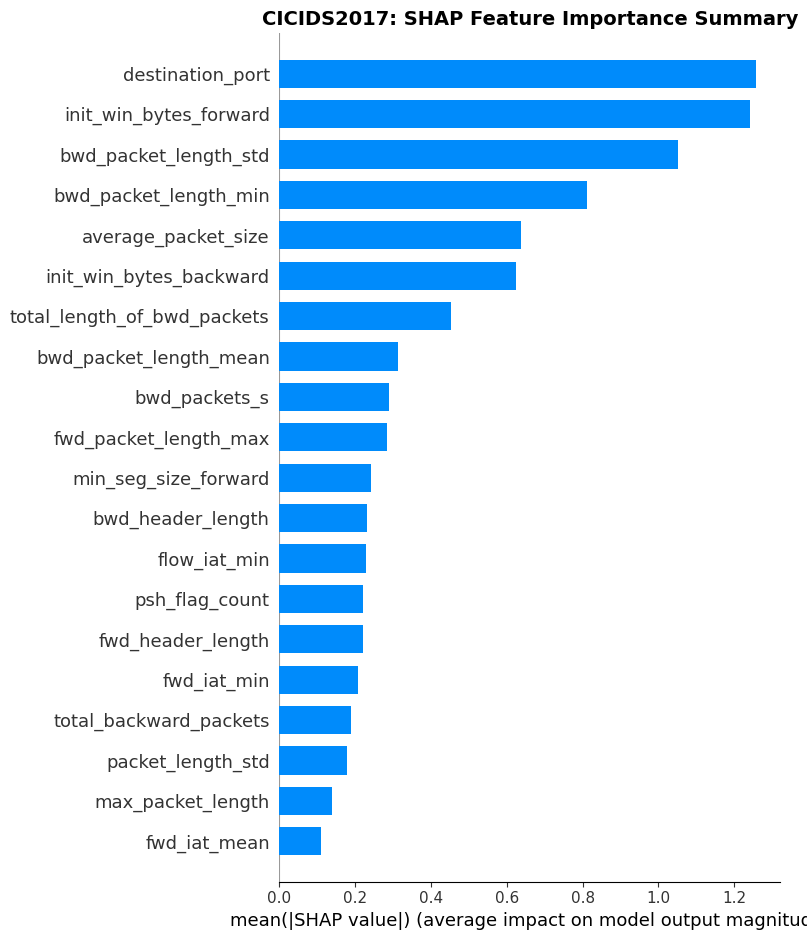

Top 5 alerts with highest priority scores in CICIDS2017:
Alert 3130 :
  Priority Score: 8.60/10
  XGBoost Probability: 0.9999
  LSTM Probability: 1.0000
  Cluster ID: 35.0
  True Label: Attack
Alert 4114 :
  Priority Score: 8.60/10
  XGBoost Probability: 0.9999
  LSTM Probability: 1.0000
  Cluster ID: 35.0
  True Label: Attack
Alert 552 :
  Priority Score: 8.60/10
  XGBoost Probability: 0.9999
  LSTM Probability: 1.0000
  Cluster ID: 35.0
  True Label: Attack
Alert 114 :
  Priority Score: 8.60/10
  XGBoost Probability: 0.9999
  LSTM Probability: 1.0000
  Cluster ID: 22.0
  True Label: Attack
Alert 1403 :
  Priority Score: 8.60/10
  XGBoost Probability: 0.9999
  LSTM Probability: 1.0000
  Cluster ID: 22.0
  True Label: Attack


In [36]:

print('SHAP EXPLAINABILITY: CICIDS2017')

print('Creating SHAP explainer...')
explainer_cicids = shap.TreeExplainer(xgb_cicids)
print('SHAP explainer created successfully')

print('Computing SHAP values for sample predictions...')
sample_size = min(100, len(X_cicids_test))
X_sample_cicids = X_cicids_test.iloc[:sample_size]
shap_values_cicids = explainer_cicids.shap_values(X_sample_cicids)
print('SHAP values computed for', sample_size, 'samples')

print('Visualizing SHAP summary...')
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_cicids, X_sample_cicids, plot_type='bar', show=False)
plt.title('CICIDS2017: SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('Top 5 alerts with highest priority scores in CICIDS2017:')
top_alerts_cicids = alert_queue_cicids.head(5)
for i, row in top_alerts_cicids.iterrows():
    alert_idx = int(row['index'])
    print('Alert', alert_idx, ':')
    print('  Priority Score:', '{:.2f}/10'.format(row['priority_score']))
    print('  XGBoost Probability:', '{:.4f}'.format(row['xgb_proba']))
    print('  LSTM Probability:', '{:.4f}'.format(row['lstm_proba']))
    print('  Cluster ID:', row['cluster_id'])
    label = 'Attack' if row['true_label'] == 1 else 'Normal'
    print('  True Label:', label)


### SHAP Force Plot Examples - CICIDS2017

SHAP FORCE PLOT EXAMPLES: CICIDS2017


Force plot for sample 0 :


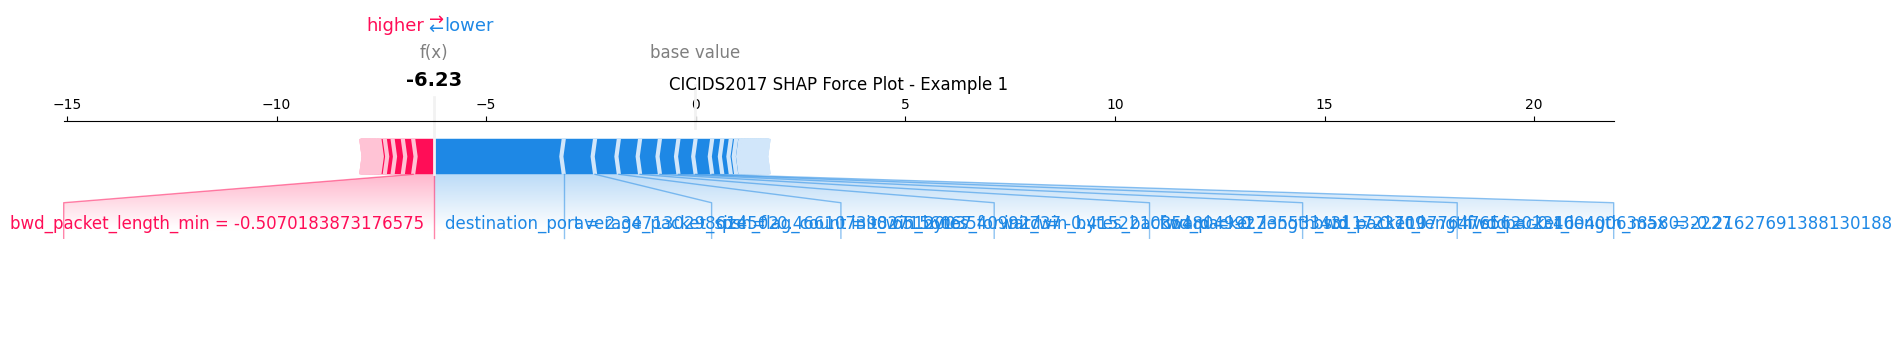

Force plot for sample 1 :


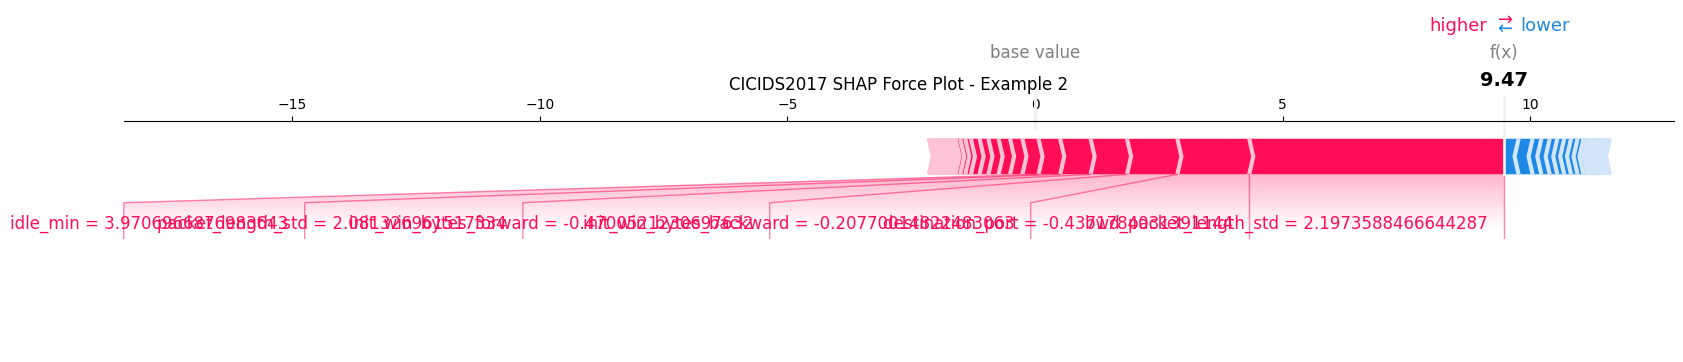

Force plot for sample 2 :


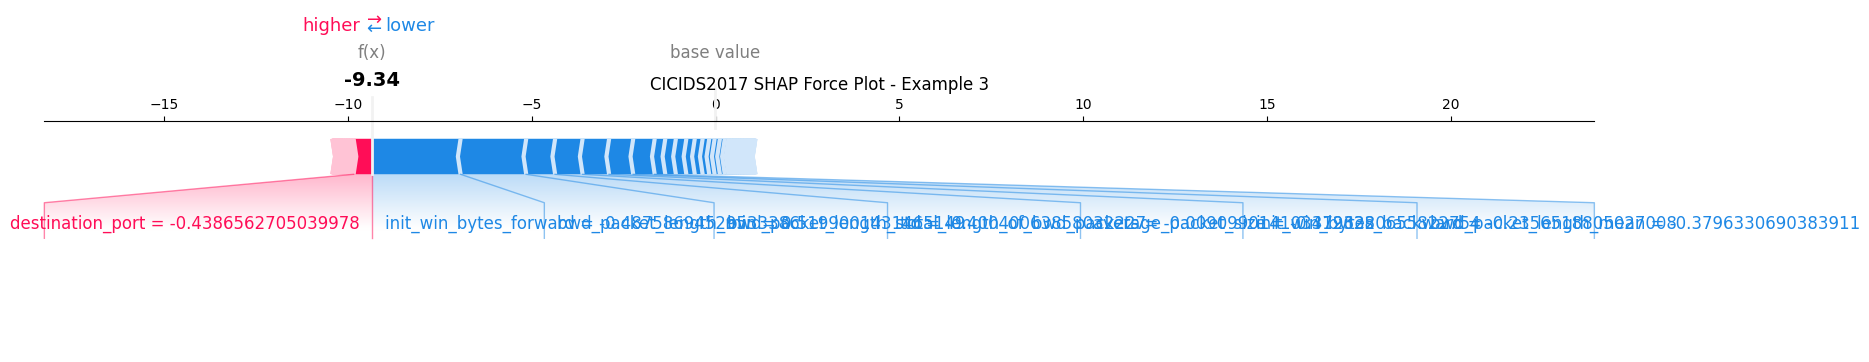

In [37]:

print('SHAP FORCE PLOT EXAMPLES: CICIDS2017')

# Initialize JS rendering for SHAP (optional for notebooks)
shap.initjs()

num_examples = min(3, len(X_cicids_test))
for i in range(num_examples):
    print('Force plot for sample', i, ':')
    shap.force_plot(explainer_cicids.expected_value, shap_values_cicids[i], X_sample_cicids.iloc[i], matplotlib=True, show=False)
    plt.title('CICIDS2017 SHAP Force Plot - Example {}'.format(i+1), fontsize=12)
    plt.show()


## Step 12: Comprehensive Evaluation


In [38]:
print("COMPREHENSIVE EVALUATION: Technical Metrics")

def calculate_alert_reduction_rate(priority_scores, threshold=5.0):
    filtered_alerts = (priority_scores >= threshold).sum()
    total_alerts = len(priority_scores)
    reduction_rate = (1 - filtered_alerts / total_alerts) * 100
    return reduction_rate, filtered_alerts, total_alerts

def calculate_threat_detection_rate(priority_scores, true_labels, threshold=5.0):
    high_priority_indices = np.where(priority_scores >= threshold)[0]
    if len(high_priority_indices) == 0:
        return 0.0, 0, 0
    detected_threats = true_labels[high_priority_indices].sum()
    total_threats = true_labels.sum()
    detection_rate = (detected_threats / total_threats * 100) if total_threats > 0 else 0.0
    return detection_rate, detected_threats, total_threats

print("\nUNSW-NB15 Evaluation:")
threshold = 5.0
reduction_rate_unsw, filtered_unsw, total_unsw = calculate_alert_reduction_rate(priority_scores_unsw, threshold)
detection_rate_unsw, detected_unsw, total_threats_unsw = calculate_threat_detection_rate(
    priority_scores_unsw, y_test_sample_unsw, threshold
)

print(f"\nAlert Reduction Metrics:")
print(f"  Threshold: {threshold}")
print(f"  Alerts filtered (priority >= {threshold}): {filtered_unsw}/{total_unsw}")
print(f"  Alert reduction rate: {reduction_rate_unsw:.2f}%")

print(f"\nThreat Detection Metrics:")
print(f"  Total threats in test set: {total_threats_unsw}")
print(f"  Threats detected in high-priority alerts: {detected_unsw}")
print(f"  Threat detection rate: {detection_rate_unsw:.2f}%")

print(f"\nModel Performance Summary:")
print(f"  XGBoost - Accuracy: {accuracy_unsw:.4f}, F1: {f1_unsw:.4f}, ROC-AUC: {roc_auc_unsw:.4f}")
print(f"  LSTM - Accuracy: {accuracy_lstm_unsw:.4f}, F1: {f1_lstm_unsw:.4f}, ROC-AUC: {roc_auc_lstm_unsw:.4f}")

print("\nCICIDS2017 Evaluation:")
reduction_rate_cicids, filtered_cicids, total_cicids = calculate_alert_reduction_rate(priority_scores_cicids, threshold)
detection_rate_cicids, detected_cicids, total_threats_cicids = calculate_threat_detection_rate(
    priority_scores_cicids, y_test_sample_cicids, threshold
)

print(f"\nAlert Reduction Metrics:")
print(f"  Threshold: {threshold}")
print(f"  Alerts filtered (priority >= {threshold}): {filtered_cicids}/{total_cicids}")
print(f"  Alert reduction rate: {reduction_rate_cicids:.2f}%")

print(f"\nThreat Detection Metrics:")
print(f"  Total threats in test set: {total_threats_cicids}")
print(f"  Threats detected in high-priority alerts: {detected_cicids}")
print(f"  Threat detection rate: {detection_rate_cicids:.2f}%")

print(f"\nModel Performance Summary:")
print(f"  XGBoost - Accuracy: {accuracy_cicids:.4f}, F1: {f1_cicids:.4f}, ROC-AUC: {roc_auc_cicids:.4f}")
print(f"  LSTM - Accuracy: {accuracy_lstm_cicids:.4f}, F1: {f1_lstm_cicids:.4f}, ROC-AUC: {roc_auc_lstm_cicids:.4f}")

COMPREHENSIVE EVALUATION: Technical Metrics

UNSW-NB15 Evaluation:

Alert Reduction Metrics:
  Threshold: 5.0
  Alerts filtered (priority >= 5.0): 2905/5000
  Alert reduction rate: 41.90%

Threat Detection Metrics:
  Total threats in test set: 3139
  Threats detected in high-priority alerts: 2861
  Threat detection rate: 91.14%

Model Performance Summary:
  XGBoost - Accuracy: 0.9449, F1: 0.9555, ROC-AUC: 0.9911
  LSTM - Accuracy: 0.9171, F1: 0.9339, ROC-AUC: 0.9804

CICIDS2017 Evaluation:

Alert Reduction Metrics:
  Threshold: 5.0
  Alerts filtered (priority >= 5.0): 964/5000
  Alert reduction rate: 80.72%

Threat Detection Metrics:
  Total threats in test set: 967
  Threats detected in high-priority alerts: 963
  Threat detection rate: 99.59%

Model Performance Summary:
  XGBoost - Accuracy: 0.9990, F1: 0.9975, ROC-AUC: 0.9999
  LSTM - Accuracy: 0.9672, F1: 0.9198, ROC-AUC: 0.9947


### Evaluation Visualization: Model Comparison


EVALUATION VISUALIZATION: Model Comparison


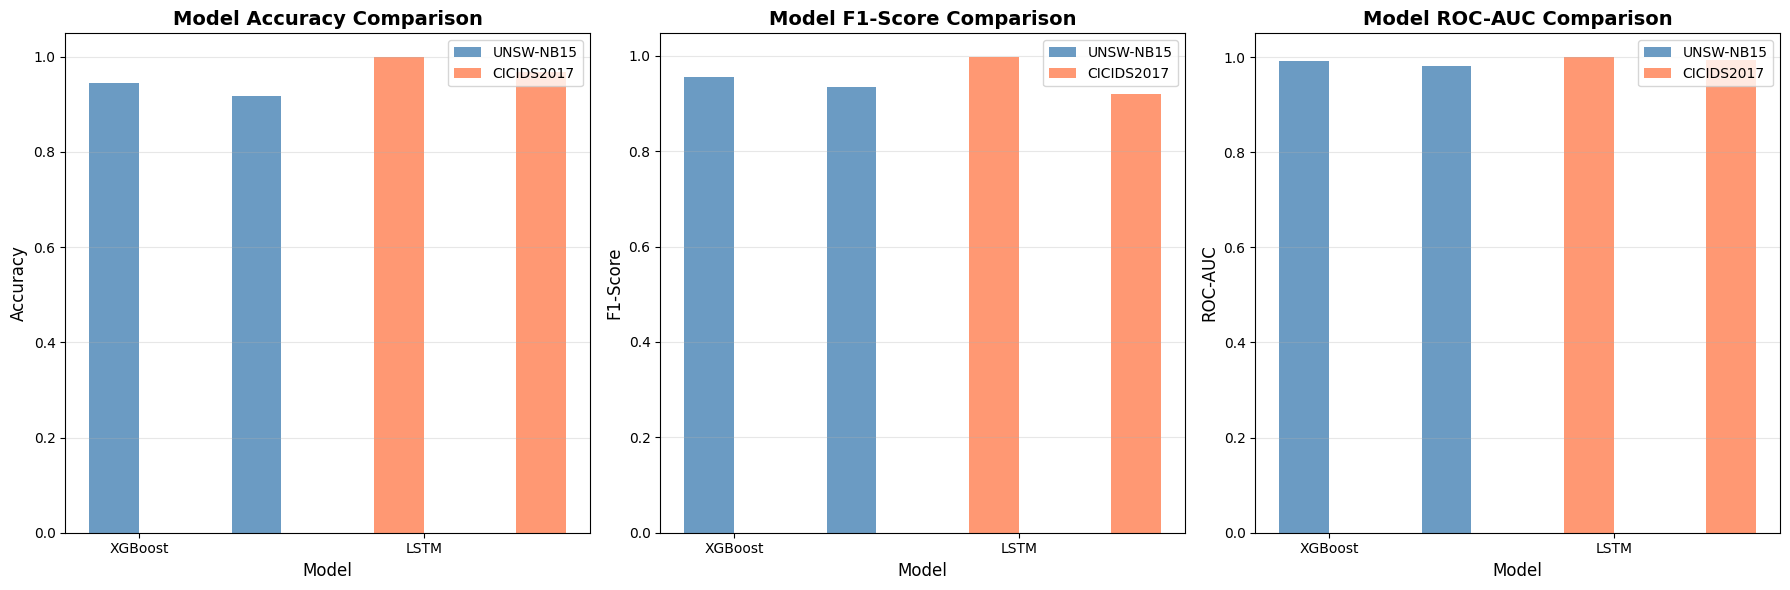


Practical Impact Metrics:

UNSW-NB15:
  Alert Reduction: 41.90%
  Threat Detection Rate: 91.14%

CICIDS2017:
  Alert Reduction: 80.72%
  Threat Detection Rate: 99.59%


In [39]:
print("EVALUATION VISUALIZATION: Model Comparison")

metrics_data = {
    'Model': ['XGBoost', 'LSTM', 'XGBoost', 'LSTM'],
    'Dataset': ['UNSW-NB15', 'UNSW-NB15', 'CICIDS2017', 'CICIDS2017'],
    'Accuracy': [accuracy_unsw, accuracy_lstm_unsw, accuracy_cicids, accuracy_lstm_cicids],
    'F1-Score': [f1_unsw, f1_lstm_unsw, f1_cicids, f1_lstm_cicids],
    'ROC-AUC': [roc_auc_unsw, roc_auc_lstm_unsw, roc_auc_cicids, roc_auc_lstm_cicids]
}

df_metrics = pd.DataFrame(metrics_data)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

x = np.arange(len(df_metrics))
width = 0.35

unsw_mask = df_metrics['Dataset'] == 'UNSW-NB15'
cicids_mask = df_metrics['Dataset'] == 'CICIDS2017'

axes[0].bar(x[unsw_mask] - width/2, df_metrics[unsw_mask]['Accuracy'], width,
           label='UNSW-NB15', color='steelblue', alpha=0.8)
axes[0].bar(x[cicids_mask] - width/2, df_metrics[cicids_mask]['Accuracy'], width,
           label='CICIDS2017', color='coral', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x[::2])
axes[0].set_xticklabels(['XGBoost', 'LSTM'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x[unsw_mask] - width/2, df_metrics[unsw_mask]['F1-Score'], width,
           label='UNSW-NB15', color='steelblue', alpha=0.8)
axes[1].bar(x[cicids_mask] - width/2, df_metrics[cicids_mask]['F1-Score'], width,
           label='CICIDS2017', color='coral', alpha=0.8)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x[::2])
axes[1].set_xticklabels(['XGBoost', 'LSTM'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(x[unsw_mask] - width/2, df_metrics[unsw_mask]['ROC-AUC'], width,
           label='UNSW-NB15', color='steelblue', alpha=0.8)
axes[2].bar(x[cicids_mask] - width/2, df_metrics[cicids_mask]['ROC-AUC'], width,
           label='CICIDS2017', color='coral', alpha=0.8)
axes[2].set_xlabel('Model', fontsize=12)
axes[2].set_ylabel('ROC-AUC', fontsize=12)
axes[2].set_title('Model ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[2].set_xticks(x[::2])
axes[2].set_xticklabels(['XGBoost', 'LSTM'])
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPractical Impact Metrics:")
print(f"\nUNSW-NB15:")
print(f"  Alert Reduction: {reduction_rate_unsw:.2f}%")
print(f"  Threat Detection Rate: {detection_rate_unsw:.2f}%")
print(f"\nCICIDS2017:")
print(f"  Alert Reduction: {reduction_rate_cicids:.2f}%")
print(f"  Threat Detection Rate: {detection_rate_cicids:.2f}%")

CONFUSION MATRICES


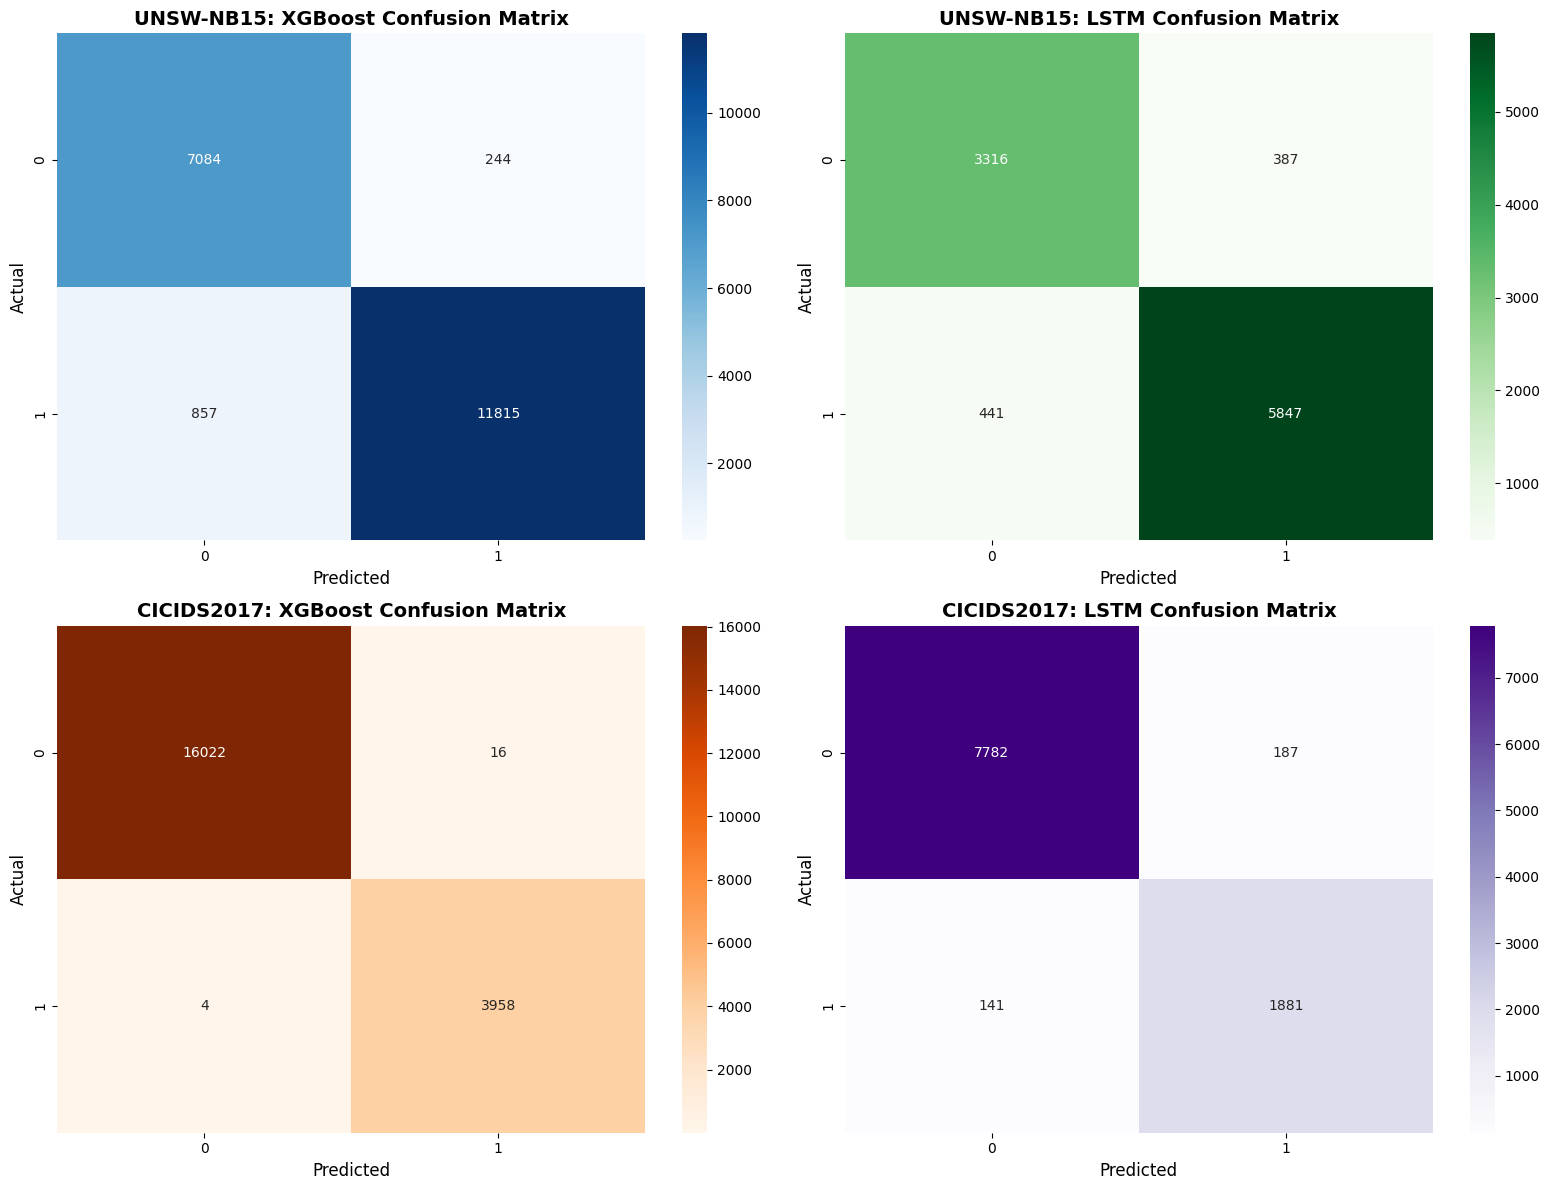

In [40]:
print("CONFUSION MATRICES")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

cm_xgb_unsw = confusion_matrix(y_unsw_test, y_unsw_pred)
sns.heatmap(cm_xgb_unsw, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('UNSW-NB15: XGBoost Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Predicted', fontsize=12)
axes[0, 0].set_ylabel('Actual', fontsize=12)

cm_lstm_unsw = confusion_matrix(y_unsw_test_seq, y_unsw_lstm_pred)
sns.heatmap(cm_lstm_unsw, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1])
axes[0, 1].set_title('UNSW-NB15: LSTM Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Predicted', fontsize=12)
axes[0, 1].set_ylabel('Actual', fontsize=12)

cm_xgb_cicids = confusion_matrix(y_cicids_test, y_cicids_pred)
sns.heatmap(cm_xgb_cicids, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0])
axes[1, 0].set_title('CICIDS2017: XGBoost Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted', fontsize=12)
axes[1, 0].set_ylabel('Actual', fontsize=12)

cm_lstm_cicids = confusion_matrix(y_cicids_test_seq, y_cicids_lstm_pred)
sns.heatmap(cm_lstm_cicids, annot=True, fmt='d', cmap='Purples', ax=axes[1, 1])
axes[1, 1].set_title('CICIDS2017: LSTM Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Predicted', fontsize=12)
axes[1, 1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

## Step 13: Results Summary & Critical Evaluation


In [41]:
print("EXPORTING MODELS AND RESULTS")

os.makedirs('saved_models', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("\n Saving XGBoost models...")
joblib.dump(xgb_unsw, 'saved_models/xgb_unsw.pkl')
joblib.dump(xgb_cicids, 'saved_models/xgb_cicids.pkl')
print("XGBoost models saved")

print("\n Saving LSTM models...")
lstm_unsw.save('saved_models/lstm_unsw.h5')
lstm_cicids.save('saved_models/lstm_cicids.h5')
print("LSTM models saved")

print("\n Saving preprocessing objects...")
joblib.dump(scaler_unsw, 'saved_models/scaler_unsw.pkl')
joblib.dump(scaler_cicids, 'saved_models/scaler_cicids.pkl')
joblib.dump(label_encoders_unsw, 'saved_models/label_encoders_unsw.pkl')
joblib.dump(label_encoders_cicids, 'saved_models/label_encoders_cicids.pkl')
print("Preprocessing objects saved")

print("\n Exporting evaluation metrics...")
results_summary = {
    'Dataset': ['UNSW-NB15', 'UNSW-NB15', 'CICIDS2017', 'CICIDS2017'],
    'Model': ['XGBoost', 'LSTM', 'XGBoost', 'LSTM'],
    'Accuracy': [accuracy_unsw, accuracy_lstm_unsw, accuracy_cicids, accuracy_lstm_cicids],
    'Precision': [precision_unsw, precision_lstm_unsw, precision_cicids, precision_lstm_cicids],
    'Recall': [recall_unsw, recall_lstm_unsw, recall_cicids, recall_lstm_cicids],
    'F1-Score': [f1_unsw, f1_lstm_unsw, f1_cicids, f1_lstm_cicids],
    'ROC-AUC': [roc_auc_unsw, roc_auc_lstm_unsw, roc_auc_cicids, roc_auc_lstm_cicids]
}

df_results = pd.DataFrame(results_summary)
df_results.to_csv('results/model_performance_metrics.csv', index=False)
print("Evaluation metrics exported to results/model_performance_metrics.csv")

practical_metrics = {
    'Dataset': ['UNSW-NB15', 'CICIDS2017'],
    'Alert_Reduction_Rate': [reduction_rate_unsw, reduction_rate_cicids],
    'Threat_Detection_Rate': [detection_rate_unsw, detection_rate_cicids],
    'Filtered_Alerts': [filtered_unsw, filtered_cicids],
    'Total_Alerts': [total_unsw, total_cicids],
    'Detected_Threats': [detected_unsw, detected_cicids],
    'Total_Threats': [total_threats_unsw, total_threats_cicids]
}

df_practical = pd.DataFrame(practical_metrics)
df_practical.to_csv('results/practical_impact_metrics.csv', index=False)
print("Practical impact metrics exported to results/practical_impact_metrics.csv")

alert_queue_unsw.to_csv('results/alert_queue_unsw.csv', index=False)
alert_queue_cicids.to_csv('results/alert_queue_cicids.csv', index=False)
print("Alert priority queues exported")

print("ALL MODELS AND RESULTS EXPORTED SUCCESSFULLY")
print("\nFiles saved:")
print("  - saved_models/xgb_unsw.pkl")
print("  - saved_models/xgb_cicids.pkl")
print("  - saved_models/lstm_unsw.h5")
print("  - saved_models/lstm_cicids.h5")
print("  - saved_models/scaler_unsw.pkl")
print("  - saved_models/scaler_cicids.pkl")
print("  - saved_models/label_encoders_unsw.pkl")
print("  - saved_models/label_encoders_cicids.pkl")
print("  - results/model_performance_metrics.csv")
print("  - results/practical_impact_metrics.csv")
print("  - results/alert_queue_unsw.csv")
print("  - results/alert_queue_cicids.csv")

EXPORTING MODELS AND RESULTS

 Saving XGBoost models...
XGBoost models saved

 Saving LSTM models...
LSTM models saved

 Saving preprocessing objects...
Preprocessing objects saved

 Exporting evaluation metrics...
Evaluation metrics exported to results/model_performance_metrics.csv
Practical impact metrics exported to results/practical_impact_metrics.csv
Alert priority queues exported
ALL MODELS AND RESULTS EXPORTED SUCCESSFULLY

Files saved:
  - saved_models/xgb_unsw.pkl
  - saved_models/xgb_cicids.pkl
  - saved_models/lstm_unsw.h5
  - saved_models/lstm_cicids.h5
  - saved_models/scaler_unsw.pkl
  - saved_models/scaler_cicids.pkl
  - saved_models/label_encoders_unsw.pkl
  - saved_models/label_encoders_cicids.pkl
  - results/model_performance_metrics.csv
  - results/practical_impact_metrics.csv
  - results/alert_queue_unsw.csv
  - results/alert_queue_cicids.csv


In [ ]:
import os
import time
import zipfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import shap
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class SOCAlertFramework:
    def __init__(self):
        self.extract_dir = "extracted_data"
        self.df_unsw = None
        self.df_cicids = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.xgb_model = None
        self.lstm_model = None
        self.dbscan_model = None

    def extract_datasets(self):
        print("EXTRACTING DATASETS")

        os.makedirs(self.extract_dir, exist_ok=True)

        print("\n[1/2] Extracting UNSW-NB15 dataset (archive 1)...")
        start_time = time.time()
        with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(f"Found {len(file_list)} files in archive")
            zip_ref.extractall(os.path.join(self.extract_dir, "UNSW_NB15"))
            print(f"Extracted to: {os.path.join(self.extract_dir, 'UNSW_NB15')}")
        print(f"Extraction time: {time.time() - start_time:.2f} seconds")

        print("\n[2/2] Extracting CICIDS2017 dataset (archive 2)...")
        start_time = time.time()
        with zipfile.ZipFile('archive (2).zip', 'r') as zip_ref:
            file_list = zip_ref.namelist()
            print(f"Found {len(file_list)} files in archive")
            zip_ref.extractall(os.path.join(self.extract_dir, "CICIDS2017"))
            print(f"Extracted to: {os.path.join(self.extract_dir, 'CICIDS2017')}")
        print(f"Extraction time: {time.time() - start_time:.2f} seconds")

        print("EXTRACTION COMPLETE")

    def load_unsw_dataset(self):
        print("LOADING UNSW-NB15 DATASET")

        unsw_path = os.path.join(self.extract_dir, "UNSW_NB15")
        csv_files = [f for f in os.listdir(unsw_path) if f.endswith('.csv')]
        print(f"\nFound {len(csv_files)} CSV files")

        df_train = pd.read_csv(os.path.join(unsw_path, 'UNSW_NB15_training-set.csv'))
        df_test = pd.read_csv(os.path.join(unsw_path, 'UNSW_NB15_testing-set.csv'))

        self.df_unsw = pd.concat([df_train, df_test], ignore_index=True)
        print(f"Combined dataset shape: {self.df_unsw.shape}")
        print(f"Memory usage: {self.df_unsw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    def load_cicids_dataset(self):
        print("LOADING CICIDS2017 DATASET")

        cicids_path = os.path.join(self.extract_dir, "CICIDS2017")
        csv_files = [f for f in os.listdir(cicids_path) if f.endswith('.csv')]
        print(f"\nFound {len(csv_files)} CSV files")

        df_list = []
        for i, csv_file in enumerate(csv_files, 1):
            print(f"[{i}/{len(csv_files)}] Loading {csv_file}...")
            df_temp = pd.read_csv(os.path.join(cicids_path, csv_file))
            print(f"  Shape: {df_temp.shape}")
            df_list.append(df_temp)

        self.df_cicids = pd.concat(df_list, ignore_index=True)
        print(f"\nCombined dataset shape: {self.df_cicids.shape}")
        print(f"Memory usage: {self.df_cicids.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    def visualize_attack_distribution(self):
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('UNSW-NB15: Attack Categories', 'CICIDS2017: Attack Types',
                          'UNSW-NB15: Normal vs Attack', 'CICIDS2017: Normal vs Attack'),
            specs=[[{"type": "bar"}, {"type": "bar"}],
                   [{"type": "pie"}, {"type": "pie"}]]
        )

        unsw_attacks = self.df_unsw['attack_cat'].value_counts()
        fig.add_trace(
            go.Bar(x=unsw_attacks.index, y=unsw_attacks.values, name='UNSW-NB15',
                   marker_color='steelblue'),
            row=1, col=1
        )

        cicids_label_col = ' Label' if ' Label' in self.df_cicids.columns else 'Label'
        cicids_attacks = self.df_cicids[cicids_label_col].value_counts()
        fig.add_trace(
            go.Bar(x=cicids_attacks.index, y=cicids_attacks.values, name='CICIDS2017',
                   marker_color='coral'),
            row=1, col=2
        )

        unsw_normal = (self.df_unsw['label'] == 0).sum()
        unsw_attack = (self.df_unsw['label'] == 1).sum()
        fig.add_trace(
            go.Pie(labels=['Normal', 'Attack'], values=[unsw_normal, unsw_attack],
                   marker_colors=['#2ecc71', '#e74c3c']),
            row=2, col=1
        )

        cicids_normal = cicids_attacks.get('BENIGN', 0)
        cicids_attack = len(self.df_cicids) - cicids_normal
        fig.add_trace(
            go.Pie(labels=['Normal', 'Attack'], values=[cicids_normal, cicids_attack],
                   marker_colors=['#2ecc71', '#e74c3c']),
            row=2, col=2
        )

        fig.update_layout(height=900, title_text="Attack Distribution Analysis", showlegend=False)
        fig.write_html("viz_1_attack_distribution.html")
        print("Visualization 1 saved: viz_1_attack_distribution.html")

    def visualize_feature_correlations(self):
        numeric_cols_unsw = self.df_unsw.select_dtypes(include=[np.number]).columns[:20]
        corr_unsw = self.df_unsw[numeric_cols_unsw].corr()

        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=('UNSW-NB15 Feature Correlations', 'CICIDS2017 Feature Correlations'),
            specs=[[{"type": "heatmap"}, {"type": "heatmap"}]]
        )

        fig.add_trace(
            go.Heatmap(z=corr_unsw.values, x=corr_unsw.columns, y=corr_unsw.columns,
                      colorscale='RdBu_r', zmid=0),
            row=1, col=1
        )

        numeric_cols_cicids = self.df_cicids.select_dtypes(include=[np.number]).columns[:20]
        corr_cicids = self.df_cicids[numeric_cols_cicids].corr()
        fig.add_trace(
            go.Heatmap(z=corr_cicids.values, x=corr_cicids.columns, y=corr_cicids.columns,
                      colorscale='Viridis'),
            row=1, col=2
        )

        fig.update_layout(height=700, title_text="Feature Correlation Heatmaps")
        fig.write_html("viz_2_correlations.html")
        print("Visualization 2 saved: viz_2_correlations.html")

    def visualize_protocol_analysis(self):
        proto_unsw = self.df_unsw['proto'].value_counts().head(10)

        fig = go.Figure()
        fig.add_trace(go.Bar(
            x=proto_unsw.index,
            y=proto_unsw.values,
            marker=dict(
                color=proto_unsw.values,
                colorscale='Plasma',
                showscale=True
            ),
            text=proto_unsw.values,
            textposition='auto',
        ))

        fig.update_layout(
            title="Protocol Distribution Analysis - UNSW-NB15",
            xaxis_title="Protocol",
            yaxis_title="Frequency",
            height=600
        )
        fig.write_html("viz_3_protocols.html")
        print("Visualization 3 saved: viz_3_protocols.html")

    def visualize_advanced_patterns(self):
        sample_size = min(5000, len(self.df_unsw))
        df_sample = self.df_unsw.sample(sample_size)

        fig = px.scatter_3d(
            df_sample,
            x='dur',
            y='spkts',
            z='dpkts',
            color='attack_cat',
            size='sbytes',
            hover_data=['proto', 'service'],
            title='3D Traffic Pattern Analysis - UNSW-NB15'
        )
        fig.update_layout(height=800)
        fig.write_html("viz_4_3d_patterns.html")
        print("Visualization 4 saved: viz_4_3d_patterns.html")

    def preprocess_data(self):
        print("DATA PREPROCESSING")

        df = self.df_unsw.copy()

        print(f"\nInitial shape: {df.shape}")
        df = df.dropna()
        print(f"After dropping NaN: {df.shape}")

        categorical_cols = df.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols if col not in ['attack_cat', 'label']]

        for col in categorical_cols:
            if col in df.columns:
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                self.label_encoders[col] = le

        X = df.drop(['label', 'attack_cat'], axis=1, errors='ignore')
        y = df['label']

        X = X.select_dtypes(include=[np.number])

        print(f"\nFeature matrix shape: {X.shape}")
        print(f"Target distribution:\n{y.value_counts()}")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        self.X_train = self.scaler.fit_transform(self.X_train)
        self.X_test = self.scaler.transform(self.X_test)

        print(f"\nTraining set: {self.X_train.shape}")
        print(f"Testing set: {self.X_test.shape}")

    def train_xgboost_model(self):
        print("TRAINING XGBOOST MODEL")

        self.xgb_model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            eval_metric='logloss'
        )

        print("\nTraining in progress...")
        self.xgb_model.fit(
            self.X_train, self.y_train,
            eval_set=[(self.X_test, self.y_test)],
            verbose=False
        )

        y_pred = self.xgb_model.predict(self.X_test)
        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))

    def train_lstm_model(self):
        print("TRAINING LSTM MODEL")

        X_train_lstm = self.X_train.reshape((self.X_train.shape[0], 1, self.X_train.shape[1]))
        X_test_lstm = self.X_test.reshape((self.X_test.shape[0], 1, self.X_test.shape[1]))

        self.lstm_model = keras.Sequential([
            layers.LSTM(128, return_sequences=True, input_shape=(1, self.X_train.shape[1])),
            layers.Dropout(0.3),
            layers.LSTM(64),
            layers.Dropout(0.3),
            layers.Dense(32, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])

        self.lstm_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        print("\nTraining in progress...")
        history = self.lstm_model.fit(
            X_train_lstm, self.y_train,
            validation_data=(X_test_lstm, self.y_test),
            epochs=20,
            batch_size=128,
            callbacks=[early_stop],
            verbose=1
        )

        self.visualize_training_history(history)

    def visualize_training_history(self, history):
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=('Model Accuracy', 'Model Loss')
        )

        fig.add_trace(
            go.Scatter(y=history.history['accuracy'], name='Train Accuracy', mode='lines'),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(y=history.history['val_accuracy'], name='Val Accuracy', mode='lines'),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(y=history.history['loss'], name='Train Loss', mode='lines'),
            row=1, col=2
        )
        fig.add_trace(
            go.Scatter(y=history.history['val_loss'], name='Val Loss', mode='lines'),
            row=1, col=2
        )

        fig.update_layout(height=500, title_text="LSTM Training History")
        fig.write_html("viz_5_lstm_training.html")
        print("Visualization 5 saved: viz_5_lstm_training.html")

    def train_clustering_model(self):
        print("TRAINING DBSCAN CLUSTERING MODEL")

        sample_size = min(10000, len(self.X_train))
        X_sample = self.X_train[:sample_size]

        self.dbscan_model = DBSCAN(eps=0.5, min_samples=5, n_jobs=-1)
        clusters = self.dbscan_model.fit_predict(X_sample)

        print(f"\nNumber of clusters found: {len(set(clusters)) - (1 if -1 in clusters else 0)}")
        print(f"Number of noise points: {list(clusters).count(-1)}")

        self.visualize_clusters(X_sample, clusters)

    def visualize_clusters(self, X_sample, clusters):
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(X_sample)

        fig = px.scatter(
            x=X_tsne[:, 0],
            y=X_tsne[:, 1],
            color=clusters,
            title='Alert Clustering Visualization (t-SNE)',
            labels={'x': 't-SNE Component 1', 'y': 't-SNE Component 2'},
            color_continuous_scale='Viridis'
        )
        fig.update_layout(height=700)
        fig.write_html("viz_6_clustering.html")
        print("Visualization 6 saved: viz_6_clustering.html")

    def generate_shap_explanations(self):
        print("GENERATING SHAP EXPLANATIONS")

        sample_size = min(1000, len(self.X_test))
        X_explain = self.X_test[:sample_size]

        explainer = shap.TreeExplainer(self.xgb_model)
        shap_values = explainer.shap_values(X_explain)

        shap.summary_plot(shap_values, X_explain, show=False)
        plt.tight_layout()
        plt.savefig("viz_7_shap_summary.png", dpi=300, bbox_inches='tight')
        plt.close()
        print("Visualization 7 saved: viz_7_shap_summary.png")

    def create_priority_dashboard(self):
        print("CREATING PRIORITY DASHBOARD")

        y_pred_xgb = self.xgb_model.predict_proba(self.X_test)[:, 1]

        X_test_lstm = self.X_test.reshape((self.X_test.shape[0], 1, self.X_test.shape[1]))
        y_pred_lstm = self.lstm_model.predict(X_test_lstm, verbose=0).flatten()

        priority_scores = (y_pred_xgb * 0.6 + y_pred_lstm * 0.4) * 10

        priority_categories = pd.cut(priority_scores, bins=[-0.1, 3, 6, 10], labels=['Low', 'Medium', 'High'])
        priority_dist = priority_categories.value_counts()

        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Alert Priority Distribution', 'ROC Curve',
                          'Priority Score Histogram', 'Confusion Matrix'),
            specs=[[{"type": "pie"}, {"type": "scatter"}],
                   [{"type": "histogram"}, {"type": "heatmap"}]]
        )

        fig.add_trace(
            go.Pie(labels=priority_dist.index, values=priority_dist.values,
                   marker_colors=['#2ecc71', '#f39c12', '#e74c3c']),
            row=1, col=1
        )

        fpr, tpr, _ = roc_curve(self.y_test, y_pred_xgb)
        auc_score = roc_auc_score(self.y_test, y_pred_xgb)
        fig.add_trace(
            go.Scatter(x=fpr, y=tpr, name=f'ROC (AUC={auc_score:.3f})', mode='lines'),
            row=1, col=2
        )
        fig.add_trace(
            go.Scatter(x=[0, 1], y=[0, 1], name='Random', mode='lines', line=dict(dash='dash')),
            row=1, col=2
        )

        fig.add_trace(
            go.Histogram(x=priority_scores, nbinsx=50, marker_color='steelblue'),
            row=2, col=1
        )

        cm = confusion_matrix(self.y_test, self.xgb_model.predict(self.X_test))
        fig.add_trace(
            go.Heatmap(z=cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'],
                      colorscale='Blues', text=cm, texttemplate='%{text}'),
            row=2, col=2
        )

        fig.update_layout(height=1000, title_text="SOC Alert Priority Dashboard", showlegend=True)
        fig.write_html("viz_8_priority_dashboard.html")
        print("Visualization 8 saved: viz_8_priority_dashboard.html")

    def evaluate_framework(self):
        print("COMPREHENSIVE EVALUATION")

        y_pred_xgb = self.xgb_model.predict(self.X_test)
        y_pred_proba = self.xgb_model.predict_proba(self.X_test)[:, 1]

        print("\nXGBoost Performance:")
        print(classification_report(self.y_test, y_pred_xgb))

        auc = roc_auc_score(self.y_test, y_pred_proba)
        print(f"\nROC-AUC Score: {auc:.4f}")

        total_alerts = len(self.y_test)
        true_negatives = ((y_pred_xgb == 0) & (self.y_test == 0)).sum()
        true_positives = ((y_pred_xgb == 1) & (self.y_test == 1)).sum()

        alert_reduction_rate = (true_negatives / total_alerts) * 100
        threat_detection_rate = (true_positives / (self.y_test == 1).sum()) * 100

        print(f"\nPractical Metrics:")
        print(f"Alert Reduction Rate: {alert_reduction_rate:.2f}%")
        print(f"Threat Detection Rate: {threat_detection_rate:.2f}%")
        print(f"Estimated Time Savings: {alert_reduction_rate * 0.8:.2f}%")

        results = {
            'AUC': auc,
            'Alert_Reduction': alert_reduction_rate,
            'Threat_Detection': threat_detection_rate,
            'Total_Alerts': total_alerts
        }

        pd.DataFrame([results]).to_csv('evaluation_metrics.csv', index=False)
        print("\nMetrics saved to: evaluation_metrics.csv")

    def save_models(self):
        print("SAVING MODELS")

        joblib.dump(self.xgb_model, 'xgboost_model.pkl')
        print("XGBoost model saved: xgboost_model.pkl")

        self.lstm_model.save('lstm_model.h5')
        print("LSTM model saved: lstm_model.h5")

        joblib.dump(self.scaler, 'scaler.pkl')
        print("Scaler saved: scaler.pkl")

        joblib.dump(self.label_encoders, 'label_encoders.pkl')
        print("Label encoders saved: label_encoders.pkl")

    def run_complete_pipeline(self):
        print("SOC ALERT FRAMEWORK - AI-Driven Alert Prioritization System")

        self.extract_datasets()
        self.load_unsw_dataset()
        self.load_cicids_dataset()

        print("EXPLORATORY DATA ANALYSIS")
        self.visualize_attack_distribution()
        self.visualize_feature_correlations()
        self.visualize_protocol_analysis()
        self.visualize_advanced_patterns()

        self.preprocess_data()
        self.train_xgboost_model()
        self.train_lstm_model()
        self.train_clustering_model()
        self.generate_shap_explanations()
        self.create_priority_dashboard()
        self.evaluate_framework()
        self.save_models()

if __name__ == "__main__":
    framework = SOCAlertFramework()
    framework.run_complete_pipeline()

SOC ALERT FRAMEWORK - AI-Driven Alert Prioritization System
EXTRACTING DATASETS

[1/2] Extracting UNSW-NB15 dataset (archive 1)...
Found 8 files in archive
Extracted to: extracted_data/UNSW_NB15
Extraction time: 14.24 seconds

[2/2] Extracting CICIDS2017 dataset (archive 2)...
Found 8 files in archive
Extracted to: extracted_data/CICIDS2017
Extraction time: 13.52 seconds
EXTRACTION COMPLETE
LOADING UNSW-NB15 DATASET

Found 8 CSV files
Combined dataset shape: (257673, 45)
Memory usage: 132.53 MB
LOADING CICIDS2017 DATASET

Found 8 CSV files
[1/8] Loading Tuesday-WorkingHours.pcap_ISCX.csv...
  Shape: (445909, 79)
[2/8] Loading Monday-WorkingHours.pcap_ISCX.csv...
  Shape: (529918, 79)
[3/8] Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
  Shape: (170366, 79)
[4/8] Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
  Shape: (191033, 79)
[5/8] Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
  Shape: (286467, 79)
[6/8] Loading Thursday-WorkingHours-Afte